Description: this code will completely dulplicate the data processing on MaNGA following the paper (Huang et al. 2018)
1. read MaNGA's drpall and firefly fits file, to get properties we need
1. select galaxies  
    2.1 late-type  
    2.2 star-forming [BPT, nii criteria]  
1. with selected spaxels, we use MappingsV to get the HII region, then we use pyqz to get the observational metallicity
1. every spaxle's expected metallicity
1. ALM criteria
1. galaxy's ALM region
1. ALM region and HI flux

### **并行 | 示例代码 | multiprocessing**

In [ ]:
#**************************************************************************************
''' 【并行版本】简单的修改，直接循环计算所有的spaxel的金属丰度预期值
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
from marvin.tools import Maps
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')    # 不显示warning信息

path_drpall = '/mnt/ddnfs/data_users/yhwang/bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'
drpall = fits.open(path_drpall)
firefly_fits = fits.open('/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")

def _stellar_mass(plateifu):
    mass = firefly_fits[1].data['PHOTOMETRIC_MASS'][(firefly_fits[1].data['PLATEIFU']==plateifu)][0]
    return mass

def _mass_density(plateifu,x2800):
    density = firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plateifu),x2800,0][0]
    return density


# 开始并行
pool = Pool(50)

stellar_mass = pool.map(_stellar_mass, manga_Z['plate-ifu'])

x = manga_Z['plate-ifu']
y =  manga_Z['bin_id_2800']
zip_args = list(zip(x, y))
mass_density = pool.starmap(_mass_density, zip_args)

pool.close()
pool.join()
#**************************************************************************************

### 【示例】解决内存泄漏，内存爆炸
> https://stackoverflow.com/questions/21485319/high-memory-usage-using-python-multiprocessing   
> https://www.cnblogs.com/alan-babyblog/p/5351031.html   
> 实际上，直接shutdown内核也可以解决一大堆进程驻留的问题

In [ ]:
import multiprocessing as mp
import time

def calculate(num):
    l = [num*num for num in range(num)]
    s = sum(l)
    del l       # delete lists as an  option
    return s

if __name__ == "__main__":

    # fix is in the following line #
    pool = mp.Pool(processes=2,maxtasksperchild=1000)

    time.sleep(5)
    print "launching calculation"
    num_tasks = 1000
    tasks =  [pool.apply_async(calculate,(i,)) for i in range(num_tasks)]
    for f in tasks:    
        print f.get(5)
    print "calculation finished"
    time.sleep(10)
    print "closing  pool"
    pool.close()
    print "closed pool"
    print "joining pool"
    pool.join()
    print "joined pool"
    time.sleep(5)

In [ ]:
# 平坦化数组 展开数组为一维
a=firefly_fits[8].data[:,:,0].flatten(order='C')
a = a[(a!=-9999)&(a!=-99)]
sel_Z_dev =a

# data reduction & sample selection

## read fits files and match them to get propoties

## selection: using Marvin BPT diagram to select star-forming spaxels

In [6]:
import time  # estimate running time
from copy import copy as copy  # avoid to change the value of pointer
import warnings  # shut down the annoying messages
from os.path import join  # stick different variables together
from multiprocessing import Pool  # multi-running!!!
from functools import partial  # convert to single parameter function

import math  # just for some specific calculate
import numpy as np  # array
import pandas as pd  # more powerful array
import matplotlib as mpl
import matplotlib.pyplot as plt  # plot

from astropy.io import fits    # read fits file

from marvin.tools import Maps  # use Marvin to get BPT, flux, image etc.

warnings.filterwarnings('ignore')  # ignore Warnings

In [178]:
# plateifu = '8466-12702'
def _get_arr_id(plateifu):
    tmp_id = (lalala_spaxel['plate-ifu']==plateifu)
    arr_id = lalala_spaxel['array_id'][tmp_id].values.astype(int)[0]
    return arr_id
_get_arr_id('8466-12702')

1915

In [3]:
'''Find galaxis which lose HYB10 MAPS data [not necessary]
'''
# read files
path_drpall = '../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'
drpall = fits.open(path_drpall)
firefly_fits = fits.open('../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
path_marvin_data = '../../bak_la/root/bash_file/manga_maps_data'

# check whether data is full
# good is 666, lose is -999
def _check_HYB(MaNGA_plaifu):
    try:
        filename = join(path_marvin_data, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
        maps = Maps(filename=filename)
        return 666
    except:
        return -999

#************************************************************************************
# start multi-run
pool = Pool(processes=50)
start_time = time.time()

check_plifu = firefly_fits[1].data['PLATEIFU']#drpall[1].data['PLATEIFU']  #firefly_fits[1].data['PLATEIFU']
check_it = pool.map(_check_HYB, check_plifu)

end_time = time.time()
print("Used time = %.2f s" % (end_time-start_time))
pool.close() # shut down the process
pool.join()
#************************************************************************************

# convert to numpy array
check_it = np.array(check_it)
# find out lose MAPS data
tmp_id = np.where(check_it!=666)
print("These galaxies don't have HYB10 MAPS data files :\nplate-ifu:\n%s\nTotal number is %s" % \
      (check_plifu[tmp_id],np.size(tmp_id)))

Used time = 8.32 s
These galaxies don't have HYB10 MAPS data files :
plate-ifu:
['8481-6103' '8993-1901' '9507-12702' '8549-12703']
Total number is 4


In [41]:
# use Marvin get star-forming spaxels
# criteria: nii
# exported data file contains: plate-ifu, x2800 location

# read files
firefly_fits = fits.open('../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
path_marvin_data = '../../bak_la/root/bash_file/manga_maps_data'

start_time = time.time()
def _x2800_match(bin_2d,matrix,x2800_ele):
    bin_thin = bin_2d.flatten(order='C')
    mat_thin = matrix.flatten(order='C')
    tmp_id = (bin_thin==x2800_ele)
    if (len(bin_thin[tmp_id])==1)&(mat_thin[tmp_id]==0):
        data = [MaNGA_plaifu,np.where(tmp_id==True)[0][0],666]
        return data
    else:
        return [-999,-999,-999]
def _BPT_sf(MaNGA_plaifu):
    #try:
    filename = join(path_marvin_data, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564    # 获取Hα6564
    hb = maps.emline_gflux_hb_4862    # 获取Hβ4862
    nii = maps.emline_gflux_nii_6585    # 获取Nii_6584
    oii7 = maps.emline_gflux_oii_3727    # 获取Oii_3726
    oii9 = maps.emline_gflux_oii_3729    # 获取Oii_3729
    oiii = maps.emline_gflux_oiii_5008    # 获取Oiii_5007
    # 计算mask
    masks_bpt, __, __ = maps.get_bpt(show_plot=False)    # start BPT diagram selection
    mask_non_sf = ~masks_bpt['sf']['nii']  # nii criteria
    min_snr = 10.    # signal to noise is 10
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
    mask_hb_low_snr = (np.abs(hb.value * np.sqrt(hb.ivar)) < min_snr)
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_oii7_low_snr = (np.abs(oii7.value * np.sqrt(oii7.ivar)) < min_snr)
    mask_oii9_low_snr = (np.abs(oii9.value * np.sqrt(oii9.ivar)) < min_snr)
    mask_oiii_low_snr = (np.abs(oiii.value * np.sqrt(oiii.ivar)) < min_snr)
    mask = mask_non_sf | mask_ha_low_snr | mask_hb_low_snr | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr| mask_oiii_low_snr     # 得到最后的mask

    # get location data
    tmp_id = (firefly_fits[1].data['PLATEIFU']==MaNGA_plaifu)
    x2800 = firefly_fits[4].data[tmp_id,:,0][0]  # 1D location in a galaxy
    bin_2d = firefly_fits[5].data[tmp_id,:,:][0]  # 2D location in a galaxy
    print("bin_2d = ", bin_2d)
    print("bin_2d shape = ", bin_2d.shape)
    tmp_x2800_match = partial(_x2800_match,bin_2d=bin_2d,matrix=mask)  # convert to single param

    # start multi-run
    pool = Pool(processes=10)

    sf = pool.map(tmp_x2800_match,x2800)

    pool.close() # shut down the process
    pool.join()
    return sf

#except:
#return -999
# pool = Pool(processes=30)
# sf_result = pool.map(_BPT_sf,firefly_fits[1].data['PLATEIFU'][0:2])

sf_result = _BPT_sf(firefly_fits[1].data['PLATEIFU'][55])
print(sf_result)

# pool.close() # shut down the process
# pool.join()


end_time = time.time()
print("Used time = %.2f s" % (end_time-start_time))

#************************************************************************************


bin_2d =  [[   -1    -1    -1 ... -9999 -9999 -9999]
 [   -1    -1    -1 ... -9999 -9999 -9999]
 [   -1    -1    -1 ... -9999 -9999 -9999]
 ...
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]]
bin_2d shape =  (76, 76)


TypeError: _x2800_match() got multiple values for argument 'bin_2d'

Process ForkPoolWorker-193:
Process ForkPoolWorker-200:
Process ForkPoolWorker-202:
Process ForkPoolWorker-199:
Process ForkPoolWorker-196:
Process ForkPoolWorker-197:
Process ForkPoolWorker-194:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-198:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yhwang/local/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-195:
  File "/home/yhwang/local/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/yhwang/local/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-201:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yhwang/local/anaconda/lib/python3.7/m

In [44]:
x2800_ele = 9
a = firefly_fits[5].data[777,:,:]
bin_2d = a
matrix = a

bin_thin = bin_2d.flatten(order='C')
mat_thin = matrix.flatten(order='C')
print(mat_thin)
tmp_id = (bin_thin==x2800_ele)
if (len(bin_thin[tmp_id])==1)&(mat_thin[tmp_id]==0):
    data = [MaNGA_plaifu,np.where(tmp_id==True)[0][0],666]





[   -1    -1    -1 ... -9999 -9999 -9999]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [69]:
(len(bin_thin[tmp_id])==1)&(mat_thin[tmp_id]==0)
len(mat_thin[tmp_id]==0)

2

In [147]:
MaNGA_plaifu = '9883-3701'
tmp_id = (firefly_fits[1].data['PLATEIFU']==MaNGA_plaifu)
bin_2d = firefly_fits[4].data[tmp_id,:,0][0]
print(bin_2d)
print(bin_2d.shape)

[ 0.000e+00  5.000e+00  1.550e+02 ... -9.999e+03 -9.999e+03 -9.999e+03]
(2800,)


In [87]:
2*777

1554

## 先使用最原始最慢的代码运行
## 因为并行的出了点问题

In [172]:
_get_arr_id('8466-12702')

1915

原图像大小为：  76 * 76
【用时】 1.55s 已计算 1 个星系，剩余 4674 个星系



【总用时】 1.55s


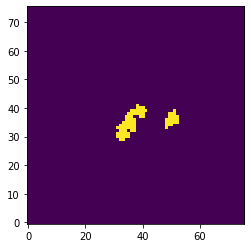

In [182]:
# 重新筛选，进行条件的放宽
# 通过BPT筛选，寻找出pure star forming spaxels
# 获取每个spaxel的物理参数：数组中位置、flux、surface mass density、E(B-V)等
# 结果将存储在/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/galid_ij_den_NO_logOiiioii_logniioii_star_forming.dat
#######################################
#######################################
#######################################
# # 清空内存池当中的巨大数组
# %xdel galid_den_NO 

import time
from copy import copy as copy
import warnings
from os.path import join

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt    # 画图[Matlab形式]

from astropy.io import fits    # 读取fits文件
from marvin.tools import Maps

warnings.filterwarnings('ignore')    # 不显示warning信息
# 打开firefly fits文件
vac = fits.open('../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy(vac[1].data)    # galaxy基本信息
# 下载的离线Marvin数据路径
# path_marvin_data = '../../bak_la/root/bash_file/marvin_vor10_fits'
path_marvin_data = '../../bak_la/root/bash_file/manga_maps_data'
# 存储 数组位置, Nii6584,Oiii5007,Oii3729,Oii3726,Oiii/Oii,Nii/Oii 10个量
#galid_den_NO = np.zeros([basic['plate'].size*2800,12],dtype='float32')-9999
galid_den_NO = np.zeros([basic['plate'].size*2800,11])-9999
# surface mass density
sur_density_all = copy(vac['SURFACE_MASS_DENSITY_VORONOI'].data[:,:,0])

bin1d = vac[4].data    # 获取bin_id数组，为了匹配xy坐标位置
bin_2d = vac[5].data    # 获取bin_id数组，为了匹配xy坐标位置

manga_EBV = vac[10].data    # 获取E（B-V）

# 获取plate-ifu，为了配合Marvin的包
plate_np = basic['plate']
ifu_np = basic['ifudsgn']
plate_np = plate_np.astype(np.int64)    # 数据转化为整型
#ifu_np = ifu_np.astype(np.int64)    # 数据转化为整型

lalala_start = time.time()    # 开始计时
# for i in range(0,basic['plate'].size):
# plateifu =  '8945-12705'
# i = _get_arr_id(plateifu)#0    # 星系的数组位置: i
# j = (_get_arr_id(plateifu))*sur_density_all[0].size#0    # 4675*2800的数组位置: j

i = 0    # 星系的数组位置: i
j = 0    # 4675*2800的数组位置: j
#for j in range(0,1):    # 4675*2800的数组位置: j
#while j<4675*2800:
#while j<10:
#while j<basic['plate'].size*sur_density_all[0].size:
# lala=0
# 控制循环最大值
j_end = basic['plate'].size*sur_density_all[0].size# 正式循环次数控制
# j_end = (_get_arr_id(plateifu)+1)*sur_density_all[0].size# 测试使用
while j<j_end:
    start_for = time.time()    #获取此次循环开始时间
    
    
    
    # 每个星系取值
    plate = plate_np[i]    # 获取plate
    ifu = ifu_np[i]    # 获取ifu
    galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系位置数组，使用plate&ifu进行定位，得到True False数组
    bin_1d = bin1d[galid,:,0][0]    # 获取一维的bin数据
    sur_density = sur_density_all[galid][0]
    
    filename = join(path_marvin_data, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    try:
        new_maps = Maps(filename=filename)
    except:
        print("oops! %d galaxy loses MAPS data" % i)
        i += 1
        j = i*2800-1
        continue
        pass
    ha = new_maps.emline_gflux_ha_6564    # 获取Hα6564
    hb = new_maps.emline_gflux_hb_4862    # 获取Hβ4862
    nii = new_maps.emline_gflux_nii_6585    # 获取Nii_6584
    oii7 = new_maps.emline_gflux_oii_3727    # 获取Oii_3726
    oii9 = new_maps.emline_gflux_oii_3729    # 获取Oii_3729
    oiii = new_maps.emline_gflux_oiii_5008    # 获取Oiii_5007
    # 计算金属丰度
    RR = (oii7+oii9) / nii;    # Oii/Nii
    # 计算mask
    masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
    mask_non_sf = ~masks_bpt['sf']['nii']*RR.pixmask.labels_to_value('DONOTUSE')
    mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 10.    #信噪比设定为10
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
    mask_hb_low_snr = (np.abs(hb.value * np.sqrt(hb.ivar)) < min_snr)
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    #mask_oii7_low_snr = (np.abs(oii7.value * np.sqrt(oii7.ivar)) < min_snr)
    #mask_oii9_low_snr = (np.abs(oii9.value * np.sqrt(oii9.ivar)) < min_snr)
    mask_oiii_low_snr = (np.abs(oiii.value * np.sqrt(oiii.ivar)) < min_snr)
    
    #new_mask = mask_non_sf | mask_ha_low_snr | mask_hb_low_snr | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr| mask_oiii_low_snr     # 得到最后的mask
    new_mask = mask_non_sf | mask_bad_data | mask_ha_low_snr | mask_hb_low_snr | mask_nii_low_snr | mask_oiii_low_snr
    #print("BPT分类得到的mask矩阵大小为",new_mask.shape)
    # star forming spaxel 个数
    #num_sfr = np.argwhere(lala1_sfr==0).size/2
    
    
    # 每个spaxel取值
    image_sz = np.shape(nii)[0]    # 图像边长
    ## 临时测试，画图数组
    print("原图像大小为： ",image_sz,'*',image_sz)
    maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
    for y in range(0,image_sz):
        for x in range(0,image_sz):
            id_bin = (bin_1d==bin_2d[galid,y,x])    # 搜索二维bin的值在一维bin数组中的位置
            #if (len(bin_1d[id_bin])==1):
            if (len(bin_1d[id_bin])==1)&(new_mask[y,x]==0):    # 挑选出 一维2800的bin和二维76*76的bin相同的数值，以及sf的spaxel
                id_bin_num = np.where(id_bin==True)[0][0]    # 2800长度数组中的位置
                #print( np.where(id_bin==True))
                # spaxel所在的星系的数组位置
                galid_den_NO[j,0] = i
                # spaxel在2800数组中的位置
                galid_den_NO[j,1] = id_bin_num
                # 星系中的y位置
                galid_den_NO[j,2] = y
                # 星系中的x位置
                galid_den_NO[j,3] = x
                # spaxel's surface mass density
                galid_den_NO[j,4] = sur_density[id_bin]
                # ha
                galid_den_NO[j,5] = ha.value[y,x]
                # hb
                galid_den_NO[j,6] = hb.value[y,x]
                # nii 6584
                galid_den_NO[j,7] = nii.value[y,x]
                # oiii 5007
                galid_den_NO[j,8] = oiii.value[y,x]
                # oii 3729
                galid_den_NO[j,9] = oii9.value[y,x]
                # oii 3726
                galid_den_NO[j,10] = oii7.value[y,x]
                
                
                j+=1
                
                # 临时测试，画图数组
                maps[y,x] = ha.value[y,x]
                
                
                
    end_for = time.time()    # 获取此次循环结束时间
    print('【用时】 %.2fs 已计算 %d 个星系，剩余 %d 个星系'% (end_for-start_for,i+1,4675-i-1))
    
    # 跳过无效数据，直接进入下一个星系
    i += 1
    j = i*2800-1
    
    # 临时测试
    #print("j = ",j)
    #print("j与上一次的差值 = ",j-lala)
    #lala =j
    
    # 限制循环次数，防止超过数组实际大小
    if j>=j_end-1:
        break
    
    
    
lalala_end = time.time()
print('\n\n\n【总用时】 %.2fs' % (lalala_end-lalala_start))

# 将得到的结果进行保存 (4675*2800,10)
# 无效数据为-9999
# np.savetxt("./tmp_storage/MaNGA_star_forming_spaxels_data_v3.0.dat", galid_den_NO)

# 简单画图测试
fig, ax = plt.subplots()
p = ax.imshow(maps , origin='lower',vmin=0,vmax=1)
plt.show()


vac.close()

## 改写为并行！！！

In [2]:
# 重新筛选，进行条件的放宽
# 通过BPT筛选，寻找出pure star forming spaxels
# 获取每个spaxel的物理参数：数组中位置、flux、surface mass density、E(B-V)等
# 结果将存储在/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/galid_ij_den_NO_logOiiioii_logniioii_star_forming.dat
#######################################
#######################################
#######################################
# # 清空内存池当中的巨大数组
# %xdel galid_den_NO 

import time
from copy import copy as copy
import warnings
from os.path import join
from multiprocessing import Pool  # multi-running!!!

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt    # 画图[Matlab形式]

from astropy.io import fits    # 读取fits文件
from marvin.tools import Maps

warnings.filterwarnings('ignore')    # 不显示warning信息
# 打开firefly fits文件
vac = fits.open('../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy(vac[1].data)    # galaxy基本信息
# 下载的离线Marvin数据路径
# path_marvin_data = '../../bak_la/root/bash_file/marvin_vor10_fits'
path_marvin_data = '../../bak_la/root/bash_file/manga_maps_data'
# 存储 数组位置, Nii6584,Oiii5007,Oii3729,Oii3726,Oiii/Oii,Nii/Oii 10个量
#galid_den_NO = np.zeros([basic['plate'].size*2800,12],dtype='float32')-9999
#galid_den_NO = np.zeros([basic['plate'].size*2800,11])-9999
# surface mass density
sur_density_all = copy(vac['SURFACE_MASS_DENSITY_VORONOI'].data[:,:,0])

bin1d = copy(vac[4].data)    # 获取bin_id数组，为了匹配xy坐标位置
bin_2d = copy(vac[5].data)    # 获取bin_id数组，为了匹配xy坐标位置
vac.close()
# 获取plate-ifu，为了配合Marvin的包
plateifu_4675 = basic['PLATEIFU']

def _BPT_all(plateifu):
    i = np.where(basic['PLATEIFU']==plateifu)[0][0]  # 4675 id
    #print("i = ",i)
    j = 0
    #print("j = ",j)
    galid_den_NO = np.zeros([2800,11])-999
    plateifu = plateifu_4675[i]
    # 星系位置数组，使用plate-ifu进行定位，得到True False数组
    galid = (plateifu_4675==plateifu)
    bin_1d = bin1d[galid,:,0][0]    # 获取一维的bin数据
    sur_density = sur_density_all[galid][0]
    
    filename = join(path_marvin_data, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plateifu))
    try:
        new_maps = Maps(filename=filename)
        
        ha = new_maps.emline_gflux_ha_6564    # 获取Hα6564
        hb = new_maps.emline_gflux_hb_4862    # 获取Hβ4862
        nii = new_maps.emline_gflux_nii_6585    # 获取Nii_6584
        oii7 = new_maps.emline_gflux_oii_3727    # 获取Oii_3726
        oii9 = new_maps.emline_gflux_oii_3729    # 获取Oii_3729
        oiii = new_maps.emline_gflux_oiii_5008    # 获取Oiii_5007
        # 计算金属丰度
        RR = (oii7+oii9) / nii;    # Oii/Nii
        # 计算mask
        masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
        mask_non_sf = ~masks_bpt['sf']['nii']*RR.pixmask.labels_to_value('DONOTUSE')
        mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
        min_snr = 10.    #信噪比设定为10
        mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
        mask_hb_low_snr = (np.abs(hb.value * np.sqrt(hb.ivar)) < min_snr)
        mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
        #mask_oii7_low_snr = (np.abs(oii7.value * np.sqrt(oii7.ivar)) < min_snr)
        #mask_oii9_low_snr = (np.abs(oii9.value * np.sqrt(oii9.ivar)) < min_snr)
        mask_oiii_low_snr = (np.abs(oiii.value * np.sqrt(oiii.ivar)) < min_snr)
        
        new_mask = mask_non_sf | mask_bad_data | mask_ha_low_snr | mask_hb_low_snr | mask_nii_low_snr | mask_oiii_low_snr
        
        # 每个spaxel取值
        image_sz = np.shape(nii)[0]    # 图像边长
        ## 临时测试，画图数组
        #print("原图像大小为： ",image_sz,'*',image_sz)
        #maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
        for y in range(0,image_sz):
            for x in range(0,image_sz):
                id_bin = (bin_1d==bin_2d[galid,y,x])    # 搜索二维bin的值在一维bin数组中的位置
                #if (len(bin_1d[id_bin])==1):
                if (len(bin_1d[id_bin])==1)&(new_mask[y,x]==0):    # 挑选出 一维2800的bin和二维76*76的bin相同的数值，以及sf的spaxel
                    id_bin_num = np.where(id_bin==True)[0][0]    # 2800长度数组中的位置
                    #print( np.where(id_bin==True))
                    # spaxel所在的星系的数组位置
                    galid_den_NO[j,0] = i
                    # spaxel在2800数组中的位置
                    galid_den_NO[j,1] = id_bin_num
                    # 星系中的y位置
                    galid_den_NO[j,2] = y
                    # 星系中的x位置
                    galid_den_NO[j,3] = x
                    # spaxel's surface mass density
                    galid_den_NO[j,4] = sur_density[id_bin]
                    # ha
                    galid_den_NO[j,5] = ha.value[y,x]
                    # hb
                    galid_den_NO[j,6] = hb.value[y,x]
                    # nii 6584
                    galid_den_NO[j,7] = nii.value[y,x]
                    # oiii 5007
                    galid_den_NO[j,8] = oiii.value[y,x]
                    # oii 3729
                    galid_den_NO[j,9] = oii9.value[y,x]
                    # oii 3726
                    galid_den_NO[j,10] = oii7.value[y,x]
                    j +=1
                    # 临时测试，画图数组
                    #maps[y,x] = ha.value[y,x]
        return galid_den_NO
    except:
        print("oops! %s galaxy loses MAPS data" % plateifu)
        return np.zeros([2800,11])-999
    
    
#lalala_end = time.time()
#print('\n\n\n【总用时】 %.2fs' % (lalala_end-lalala_start))

# 将得到的结果进行保存 (4675*2800,10)
# 无效数据为-9999
# np.savetxt("./tmp_storage/MaNGA_star_forming_spaxels_data_v3.0.dat", galid_den_NO)

# # 简单画图测试
# fig, ax = plt.subplots()
# p = ax.imshow(maps , origin='lower',vmin=0,vmax=1)
# plt.show()

start_time = time.time()
pool = Pool(processes=50,maxtasksperchild=1000)

# sel_BPT = np.array(list(map(_BPT_all, plateifu_4675)))#['8252-9102','9883-3701','8466-12702'])))
sel_all_BPT = np.array(pool.map(_BPT_all, plateifu_4675))

pool.close() # shut down the process
pool.join()
end_time = time.time()
print("Used time is %.2f s" % (end_time-start_time))

oops! 8549-12703 galaxy loses MAPS data
oops! 8481-6103 galaxy loses MAPS data
oops! 9507-12702 galaxy loses MAPS data
oops! 8993-1901 galaxy loses MAPS data
Used time is 159.85 s


In [3]:
# 存储至文件
# 拼接数组
galid_den_NO = np.concatenate(sel_all_BPT).copy()
np.savetxt("./tmp_storage/MaNGA_star_forming_spaxels_data_v3.0.dat", galid_den_NO)

In [64]:
np.shape(np.where(lala[:,0]!=-999))

(1, 772077)

In [ ]:
# plateifu = '8466-12702'
def _get_arr_id(plateifu):
    tmp_id = (lalala_spaxel['plate-ifu']==plateifu)
    arr_id = lalala_spaxel['array_id'][tmp_id].values.astype(int)[0]
    return arr_id
_get_arr_id('8466-12702')

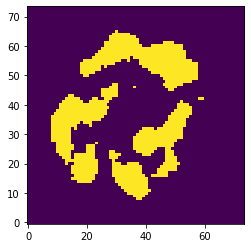

In [66]:
# 检测是否和论文的星系区域一致
lala = np.concatenate(sel_all_BPT)
# plateifu = '8466-12702'
def _get_arr_id(plateifu):
    tmp_id = (lalala_spaxel['plate-ifu']==plateifu)
    arr_id = lalala_spaxel['array_id'][tmp_id].values.astype(int)[0]
    return arr_id

i = _get_arr_id('8945-12705')#666
start = 2800*i
end = start+2800
plateifu = plateifu_4675[i]#['8252-9102','9883-3701','8466-12702'][i]
filename = join(path_marvin_data, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plateifu))
new_maps = Maps(filename=filename)
ha = new_maps.emline_gflux_ha_6564    # 获取Hα6564
image_sz = np.shape(ha)[0]    # 图像边长
maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
def _plt(x,y,ha):
    if ha>=0:
        maps[x,y] = ha
    else:
        pass
    #print("x = ",x)
    #print("y = ",y)
    #print("ha = ",ha)
    return None
[ _plt(int(x),int(y),ha) for (y,x,ha) in zip(lala[start:end,3],lala[start:end,2],lala[start:end,5])]
fig, ax = plt.subplots()
p = ax.imshow(maps , origin='lower')#,vmin=0,vmax=1)
plt.show()


In [5]:
a = np.concatenate(sel_all_BPT)
a.shape

(13090000, 11)

In [6]:
4675*2800

13090000

## selection

In [8]:
# read Nair and Abraham's Visual Morphology data 
# http://www.bo.astro.it/~nair/Morphology/Visual_Morphology.html
# cross match base on IAU_NAME(nsa) and JID(Nair)

# read Nair's data
nair_data = pd.read_table("./tmp_storage/NairAbrahamMorphology.dat")
# read NSA data
nsa_fits = fits.open('../../bak_la/root/cosmos/data/nsa_v1_0_1.fits')
# read drp_all data
drp_fits = fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')
# read firefly pipline data
firefly_fits = fits.open("../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits")

class Multi_Matched(Exception):
    pass

# input IAUNAME in nsa, format is string [you can check as type(variable)]
# output b/a ellipticity
def _match_nsa_Nair(iau_name):
    tmp_id = nair_data["#JID"].str.contains(iau_name)
    b_over_a = nair_data['bOverA'].values[np.where(tmp_id==True)]
    if len(b_over_a)==0:
        return -999
    elif len(b_over_a)==1:
        return b_over_a[0]
    else:
        raise Multi_Matched("There exist two or more values matched between Nair and NSA")

# input plate-ifu, format is string [you can check as type(variable)]
# output b/a ellipticity
def _ba_Nair(plate_ifu):
    tmp_id = (plate_ifu==drp_fits[1].data['PLATEIFU'])
    iau_name = drp_fits[1].data['NSA_IAUNAME'][tmp_id][0]
    return _match_nsa_Nair(iau_name)

# # close all fits files
# nsa_fits.close()
# drp_fits.close()
# firefly_fits.close()

In [317]:
# check for matching Nair and Firefly data [not necessary]
def _match_nsa_firefly(plate_ifu):
    tmp_id = (plate_ifu==drp_fits[1].data['PLATEIFU'])
    if len(drp_fits[1].data['PLATEIFU'][tmp_id])==1:
        return 666
    else:
        print(len(tmp_id))
        return -999
result_mat = np.array(list(map(_match_nsa_firefly, firefly_fits[1].data["PLATEIFU"])))
num = np.shape(np.where(np.array(result_mat)!=-999))[1]
print("Nair & MaNGA 共匹配到  %d  个星系" % num)

Nair & MaNGA 共匹配到  4675  个星系，单射匹配，精确！完美！直观！


In [301]:
# check for matching Nair and NSA data [not necessary]

# start multi-run
pool = Pool(processes=70)

# ba_Nair = pool.map(_ba_Nair,firefly_fits[1].data["PLATEIFU"][0:100])
ba_Nair = pool.map(_match_nsa_Nair, nsa_fits[1].data["IAUNAME"])

pool.close() # shut down the process
pool.join()

In [303]:
num = np.shape(np.where(np.array(ba_Nair)!=-999))[1]
print("Nair & NSA 共匹配到  %d  个星系" % num)

Nair & NSA 共匹配到  967  个星系，单射匹配，精确！完美！直观！


In [318]:
# get MaNGA 4675 galaxies' b over a from Nair
# unmatched data is set to -999

ba_Nair = np.array(list(map(_ba_Nair, firefly_fits[1].data["PLATEIFU"])))

In [319]:
num = np.shape(np.where(np.array(ba_Nair)!=-999))[1]
print("Nair & MaNGA 共匹配到  %d  个星系，单射匹配，精确！完美！直观！" % num)

Nair & MaNGA 共匹配到  34  个星系，单射匹配，精确！完美！直观！


In [9]:
# get every spaxel's plate-ifu, according to array_id
def _spaxel_plateifu(array_id):
    array_id = int(array_id)
    if array_id==-999:
        return -999
    else:
        return firefly_fits[1].data["PLATEIFU"][array_id]
spaxel_plifu = np.array(list(map(_spaxel_plateifu, galid_den_NO[:,0])))
print(spaxel_plifu)

['8252-12701' '8252-12701' '8252-12701' ... '-999' '-999' '-999']


In [11]:
galid_den_NO.shape

(13090000, 11)

In [12]:


# galid_den_NO = np.loadtxt("./tmp_storage/MaNGA_star_forming_spaxels_data_v3.0.dat")
tmp_data = {'plate-ifu':spaxel_plifu[:,np.newaxis][:,0],
        'array_id':galid_den_NO[:,0],
        'bin_id_2800':galid_den_NO[:,1],
        'spaxel_x':galid_den_NO[:,3],
        'spaxel_y':galid_den_NO[:,2],
        'surface_mass_density_VOR':galid_den_NO[:,4],
        'flux_ha':galid_den_NO[:,5],
        'flux_hb':galid_den_NO[:,6],
        'flux_nii':galid_den_NO[:,7],
        'flux_oii7':galid_den_NO[:,10],
        'flux_oii9':galid_den_NO[:,9],
        'flux_oiii':galid_den_NO[:,8]
       }
# 转换为 pandas 数组， dataframe类型
df = pd.DataFrame(tmp_data,columns=['plate-ifu','array_id','bin_id_2800','spaxel_x','spaxel_y',\
                                    'surface_mass_density_VOR',\
                                    'flux_ha','flux_hb','flux_nii','flux_oii7','flux_oii9','flux_oiii'])

# pandas 导出为压缩的 序列化 数据
df.to_pickle("./tmp_storage/MaNGA_spaxel.v3.0.pd.pkl")

# numpy 导出为二进制文件 npy
# np.save("./tmp_storage/MaNGA_Z.npy",save_np)



In [13]:
df

plate-ifu  array_id  bin_id_2800  spaxel_x  spaxel_y  \
0         8252-12701       0.0         17.0      32.0      29.0   
1         8252-12701       0.0         17.0      33.0      29.0   
2         8252-12701       0.0         17.0      31.0      30.0   
3         8252-12701       0.0         17.0      32.0      30.0   
4         8252-12701       0.0         17.0      33.0      30.0   
5         8252-12701       0.0         17.0      34.0      30.0   
6         8252-12701       0.0         21.0      35.0      30.0   
7         8252-12701       0.0         17.0      31.0      31.0   
8         8252-12701       0.0         17.0      32.0      31.0   
9         8252-12701       0.0         17.0      33.0      31.0   
10        8252-12701       0.0         17.0      34.0      31.0   
11        8252-12701       0.0         17.0      35.0      31.0   
12        8252-12701       0.0         17.0      32.0      32.0   
13        8252-12701       0.0         17.0      33.0      32.0   
14        8252-12701       0.0         17.0      34.0      32.0   
15        8252-12701       0.0         14.0      36.0      32.0   
16        8252-12701       0.0         14.0      37.0      32.0   
17        8252-12701       0.0         17.0      31.0      33.0   
18        8252-12701       0.0         17.0      32.0      33.0   
19        8252-12701       0.0         17.0      33.0      33.0   
20        8252-12701       0.0         17.0      34.0      33.0   
21        8252-12701       0.0         17.0      35.0      33.0   
22        8252-12701       0.0         17.0      36.0      33.0   
23        8252-12701       0.0         11.0      37.0      33.0   
24        8252-12701       0.0         18.0      48.0      33.0   
25        8252-12701       0.0         17.0      32.0      34.0   
26        8252-12701       0.0         17.0      33.0      34.0   
27        8252-12701       0.0         17.0      34.0      34.0   
28        8252-12701       0.0          9.0      35.0      34.0   
29        8252-12701       0.0          9.0      36.0      34.0   
...              ...       ...          ...       ...       ...   
13089970        -999    -999.0       -999.0    -999.0    -999.0   
13089971        -999    -999.0       -999.0    -999.0    -999.0   
13089972        -999    -999.0       -999.0    -999.0    -999.0   
13089973        -999    -999.0       -999.0    -999.0    -999.0   
13089974        -999    -999.0       -999.0    -999.0    -999.0   
13089975        -999    -999.0       -999.0    -999.0    -999.0   
13089976        -999    -999.0       -999.0    -999.0    -999.0   
13089977        -999    -999.0       -999.0    -999.0    -999.0   
13089978        -999    -999.0       -999.0    -999.0    -999.0   
13089979        -999    -999.0       -999.0    -999.0    -999.0   
13089980        -999    -999.0       -999.0    -999.0    -999.0   
13089981        -999    -999.0       -999.0    -999.0    -999.0   
13089982        -999    -999.0       -999.0    -999.0    -999.0   
13089983        -999    -999.0       -999.0    -999.0    -999.0   
13089984        -999    -999.0       -999.0    -999.0    -999.0   
13089985        -999    -999.0       -999.0    -999.0    -999.0   
13089986        -999    -999.0       -999.0    -999.0    -999.0   
13089987        -999    -999.0       -999.0    -999.0    -999.0   
13089988        -999    -999.0       -999.0    -999.0    -999.0   
13089989        -999    -999.0       -999.0    -999.0    -999.0   
13089990        -999    -999.0       -999.0    -999.0    -999.0   
13089991        -999    -999.0       -999.0    -999.0    -999.0   
13089992        -999    -999.0       -999.0    -999.0    -999.0   
13089993        -999    -999.0       -999.0    -999.0    -999.0   
13089994        -999    -999.0       -999.0    -999.0    -999.0   
13089995        -999    -999.0       -999.0    -999.0    -999.0   
13089996        -999    -999.0       -999.0    -999.0    -999.0   
13089997        -999    -999.0       -999.0    -999.0    -

In [343]:
# numpy 导出为二进制文件 npy
# np.save("./tmp_storage/MaNGA_star_forming_spaxels_data_v3.0.npy",galid_den_NO)

# numpy export data as txt file
# np.savetxt("./tmp_storage/MaNGA_star_forming_spaxels_data_v3.0.txt",galid_den_NO)
np.savetxt("./tmp_storage/MaNGA_star_forming_spaxels_data_v3.0.csv.np",galid_den_NO,delimiter=',')

# pandas export data as csv file
# df.to_csv("./tmp_storage/MaNGA_star_forming_spaxels_data_v3.0.csv")

## Data Interpretation
created on `2019.12.4`  
file name:
> `MaNGA_star_forming_spaxels_data_v3.0`   
> `MaNGA_spaxel.v3.0.pd.pkl`   

flux data:    
> manga-{}-MAPS-**`HYB10`**-GAU-MILESHC.fits.gz 

array data:  
> 0. plate-ifu
> 1. array_id
> 1. bin_id_2800
> 1. spaxel_x
> 1. spaxel_y
> 1. surface_mass_density
> 1. flux_ha
> 1. flux_hb
> 1. flux_nii
> 1. flux_oii7
> 1. flux_oii9
> 1. flux_oiii

In [14]:
import time  # estimate running time
from copy import copy as copy  # avoid to change the value of pointer
import warnings  # shut down the annoying messages
from os.path import join  # stick different variables together
from multiprocessing import Pool  # multi-running!!!
from functools import partial  # convert to single parameter function

import math  # just for some specific calculate
import numpy as np  # array
import pandas as pd  # more powerful array
import matplotlib as mpl
import matplotlib.pyplot as plt  # plot

from astropy.io import fits    # read fits file

from marvin.tools import Maps  # use Marvin to get BPT, flux, image etc.

warnings.filterwarnings('ignore')  # ignore Warnings

In [12]:
# number of star forming spaxels per galaxy in MaNGA
# input is plate ifu
# output is the number of sf spaxels.

# read the spaxle data, containing surface mass density, flux, location.
# lalala_spaxel = pd.read_pickle("./tmp_storage/MaNGA_spaxel.v3.0.pd.pkl")
# read firefly pipline data
firefly_fits = fits.open("../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits")
lalala_spaxel = pd.read_pickle("./tmp_storage/MaNGA_spaxel.v3.0.pd.pkl")
def _num_sf_spaxel(plateifu):
    #lalala_spaxel = pd.read_pickle("./tmp_storage/MaNGA_spaxel.v3.0.pd.pkl")
    tmp_plifu = lalala_spaxel["plate-ifu"]
    sel_spaxel = tmp_plifu[tmp_plifu==plateifu]
    num_sf = sel_spaxel.size
    return num_sf

# sf_num_4675 = np.array(list(map(_num_sf_spaxel, firefly_fits[1].data["PLATEIFU"])))
start_time = time.time()
# start multi-run
pool = Pool(processes=100)#,maxtasksperchild=1000)



sf_num_4675 = np.array(pool.map(_num_sf_spaxel, firefly_fits[1].data["PLATEIFU"]))


print("calculation finished")
# time.sleep(2)
print("closing  pool")
pool.close()
print("closed pool")
print("joining pool")
pool.join()
print("joined pool")

end_time = time.time()
print("Used time is %.2f s"%(end_time-start_time))

calculation finished
closing  pool
closed pool
joining pool
joined pool


In [16]:
# [test] [not necessary]
# list comprehension replace the for the above loop
start_time = time.time()
a = [lalala_spaxel["plate-ifu"][lalala_spaxel["plate-ifu"]==plateifu].size \
     for plateifu in firefly_fits[1].data["PLATEIFU"][0:10]]
end_time = time.time()
print("it takes  %.2f  s" % (end_time-start_time))

it takes  11.20  s


In [4]:
# read drp_all data
drp_fits = fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')
def _stellar_mass(plateifu):
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    
    ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
    #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id]
    return math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun
def _fracDeV(plateifu):
    # estimate the age of galaxy
    # fracDeV<0.7 is late-type galaxy
    fracDeV_txt = np.loadtxt('lalala_manga_fradeV.txt')
    tmp_id = (plateifu==firefly_fits[1].data["PLATEIFU"])
    fracdev = fracDeV_txt[tmp_id][0]
    return fracdev
_stellar_mass("9883-3701")

10.030891042714531

In [15]:
# test!!!  [this is wrong!!!]
# You can't put the loading file outside the function, otherwise the multiprocessing won't work.
# multi run without read file

# read drp_all data
drp_fits = fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')
firefly_fits = fits.open("../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits")
def _stellar_mass(plateifu):
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    
    ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
    #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id][0]
    
    try:
        ste_mass = math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun
        return ste_mass
    except:
        return -999

start_time = time.time()

pool = Pool(processes=1,maxtasksperchild=1000)

stellar_mass_4675 = np.array(pool.map(_stellar_mass, firefly_fits[1].data["PLATEIFU"][0:50]))

pool.close()
pool.join()

end_time = time.time()

print("used time is %.2f s" % (end_time-start_time))
print(stellar_mass_4675)

used time is 0.26 s
[ 9.14708243 10.6359831   9.79170468  9.82096425  9.90862494 10.09450607
 10.92523059  9.13614641 10.20818597  8.85117699  9.04267787 10.40679557
 10.54556687 10.47444501 10.18783082 10.34581075 10.05772695 11.21692031
 10.46320145  9.97320685  9.48779569  9.6871364  10.74296459 10.38954526
 11.05221669  9.52931997 10.83282494 10.39446919 10.27714603 10.15648858
 10.33697178 10.71183     9.33050306 10.90364282 10.95914351  9.77623687
  8.81677406 10.17408308  8.97748308 10.07902922 11.2618051  10.43476365
  9.00012593 10.05996459  9.04781205  9.55150367 10.06166731 10.71907511
  9.07992615 10.79542672]


In [10]:
a = np.array(drp_fits[1].data["NSA_ELPETRO_MASS"])
a.min()

-9999.0

In [6]:
# test!!!
# multi run within read file

def _stellar_mass(plateifu):
    # read drp_all data
    drp_fits = fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')
    
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
    #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id][0]
    
    drp_fits.close()
    
    try:
        ste_mass = math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun
        return ste_mass
    except:
        return -999

start_time = time.time()

pool = Pool(processes=50)#,maxtasksperchild=1000)
firefly_fits = fits.open("../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits")

stellar_mass_4675 = np.array(pool.map(_stellar_mass, firefly_fits[1].data["PLATEIFU"]))

pool.close()
pool.join()

end_time = time.time()

print("used time is %.2f s" % (end_time-start_time))

used time is 8.61 s


In [ ]:
_fracDeV("9883-3701")

In [7]:
# 单核，需要322秒，50核，只需要8.6s，快了 37.5 倍
firefly_fits = fits.open("../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits")

start_time = time.time()

test_4675 = list(map(_stellar_mass, firefly_fits[1].data["PLATEIFU"]))

end_time = time.time()
print("used time is %.2f s" % (end_time-start_time))

used time is 322.60 s


In [9]:
lalala_spaxel = pd.read_pickle("./tmp_storage/MaNGA_spaxel.v3.0.pd.pkl")
lalala_spaxel.shape

(13090000, 11)

In [10]:
4675*2800

13090000

In [15]:
import time  # estimate running time
from copy import copy as copy  # avoid to change the value of pointer
import warnings  # shut down the annoying messages
from os.path import join  # stick different variables together
from multiprocessing import Pool  # multi-running!!!
from functools import partial  # convert to single parameter function

import math  # just for some specific calculate
import numpy as np  # array
import pandas as pd  # more powerful array
import matplotlib as mpl
import matplotlib.pyplot as plt  # plot

from astropy.io import fits    # read fits file

from marvin.tools import Maps  # use Marvin to get BPT, flux, image etc.

warnings.filterwarnings('ignore')  # ignore Warnings

## 正式 筛选 星系 spaxels

In [16]:
'''select from 4675 galaxies
using several criteria:
b/a > 0.7  # ellipticity
Nair_b/a > 0.7  # Nair Visual Morphology, only match 39 galaxies with MaNGA dr15
stellar mass > 8.5(log10 M_sun)  # constrain the stellar mass of galaxy
fracDeV < 0.7  # late type galaxies
number of star forming spaxels >= 20  # more than 20 sf-spaxel due to PSF
'''
# read data [prepare]
drp_fits = copy(fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'))
firefly_fits = copy(fits.open("../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits"))
lalala_spaxel = copy(pd.read_pickle("./tmp_storage/MaNGA_spaxel.v3.0.pd.pkl"))
fracDeV_txt = copy(np.loadtxt('lalala_manga_fradeV.txt'))
class Multi_Matched(Exception):
    pass
def _ba(plateifu):
    #drp_fits = fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    ba = drp_fits[1].data["NSA_ELPETRO_BA"][tmp_id][0]
    return ba
#***************************************************************************************************
def _match_nsa_Nair(iau_name):
    nair_data = pd.read_table("./tmp_storage/NairAbrahamMorphology.dat")
    tmp_id = nair_data["#JID"].str.contains(iau_name)
    b_over_a = nair_data['bOverA'].values[np.where(tmp_id==True)]
    if len(b_over_a)==0:
        return -999
    elif len(b_over_a)==1:
        return b_over_a[0]
    else:
        raise Multi_Matched("There exist two or more values matched between Nair and NSA")
def _ba_Nair(plate_ifu):
    # read drp_all data
    #drp_fits = fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')
    tmp_id = (plate_ifu==drp_fits[1].data['PLATEIFU'])
    iau_name = drp_fits[1].data['NSA_IAUNAME'][tmp_id][0]
    return _match_nsa_Nair(iau_name)
#***************************************************************************************************
def _stellar_mass(plateifu):
    # read drp_all data
    #drp_fits = fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')
    
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
    #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id][0]
    
    #drp_fits.close()
    
    try:
        ste_mass = math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun
        return ste_mass
    except:
        return -999
def _fracDeV(plateifu):
    # read firefly pipline data
    #firefly_fits = fits.open("../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits")
    # fracDeV<0.7 is late-type galaxy
    #fracDeV_txt = np.loadtxt('lalala_manga_fradeV.txt')
    
    tmp_id = (plateifu==firefly_fits[1].data["PLATEIFU"])
    fracdev = fracDeV_txt[tmp_id][0]
    return fracdev
def _num_sf_spaxel(plateifu):
    #lalala_spaxel = pd.read_pickle("./tmp_storage/MaNGA_spaxel.v3.0.pd.pkl")
    tmp_plifu = lalala_spaxel["plate-ifu"]
    sel_spaxel = tmp_plifu[tmp_plifu==plateifu]
    num_sf = sel_spaxel.size
    return num_sf
def _select_galaxy(plateifu):
    sel_ba = (_ba(plateifu)>=0.3)
    sel_nair_ba = (_ba_Nair(plateifu) <= 0.3)
    sel_stellar_mass = (_stellar_mass(plateifu)>8.5)
    sel_fracDeV = (_fracDeV(plateifu) < 0.7)
    sel_sf_gal = (_num_sf_spaxel(plateifu) >= 20)
    sel = sel_ba&sel_nair_ba&sel_stellar_mass&sel_fracDeV&sel_sf_gal
    return sel




In [17]:
start_time = time.time()

pool = Pool(processes=60)#,maxtasksperchild=1000)

sel_gal_4675 = np.array(pool.map(_select_galaxy, firefly_fits[1].data["PLATEIFU"]))
# _select_spaxel("9883-3701")

pool.close()
pool.join()

end_time = time.time()

print("used time is %.2f s" % (end_time-start_time))

used time is 129.28 s


In [20]:
np.shape(np.where(sel_gal_4675==True))

(1, 1547)

In [22]:
# start_time = time.time()

# pool = Pool(processes=10)#,maxtasksperchild=1000)

# test_gal_4675 = np.array(pool.map(_select_galaxy, firefly_fits[1].data["PLATEIFU"][0:50]))
# test_gal_4675 = np.array(pool.map(_select_galaxy, firefly_fits[1].data["PLATEIFU"][0:50]))

# pool.close()
# pool.join()

# end_time = time.time()

# print("used time is %.2f s" % (end_time-start_time))

used time is 22.92 s


In [21]:
# drp_fits = fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')

a = copy(sel_gal_4675)
start_time = time.time()
test_mass = [drp_fits[1].data["NSA_SERSIC_MASS"][plifu==drp_fits[1].data["PLATEIFU"]][0] \
             for plifu in firefly_fits[1].data["PLATEIFU"]]
test_mass = np.array(test_mass)
tmp_id = (test_mass>10**9)
end_time = time.time()

print("used time is %.2f s" % (end_time-start_time))

np.shape(np.where(a[tmp_id]==True))

used time is 3.07 s


(1, 1361)

In [40]:
# drp_fits = copy(fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'))
# def _stellar_mass(plateifu):
#     # read drp_all data
    
#     #drp_fits = fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')
#     tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
#     ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
#     #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id][0]
#     try:
#         ste_mass = math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun
#         return ste_mass
#     except:
#         return -999

# start_time = time.time()
# pool = Pool(processes=7,maxtasksperchild=1000)

# firefly_fits = copy(fits.open("../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits"))
# test_4675 = np.array(pool.map(_stellar_mass, firefly_fits[1].data["PLATEIFU"]))
# # _select_spaxel("9883-3701")

# pool.close()
# pool.join()
# end_time = time.time()

# print("used time is %.2f s" % (end_time-start_time))


# a = copy(sel_gal_4675)
# tmp_id = (test_4675>9)
# np.shape(np.where(a[tmp_id]==True))

used time is 2.28 s


(1, 1283)

In [34]:
在函数内部进行读写文件

used time is 22.44 s


(1, 1283)

In [50]:
np.shape(np.where(test_4675==True))

(1, 1468)

+ 筛选结果为 1468 个星系【stellar mass > 8.5】
+ 若按照论文将 stellar mass > 9 的挑出来，则筛选出1283个，几乎和论文【1222】一致
  + 不一致的原因有两个：论文排除了 deprojected surface mass density < 10^-7
  + 还有一个就是 Nair 肉眼判断 b/a ，论文是直接与 Preethi Niar合作，但是我们只能根据Nair发布的结果进行匹配来判断，结果只有34个星系匹配成功，也就是这个星系倾斜程度的条件没有筛选好【显然，这个原因的可能性更大】  
  
**总的来说，筛选是成功的，由于改进了匹配的方式，全部都是`一一匹配`，没有用之前的 ra, dec, z 做粗略的匹配，所以结果可信度为`100%`**

In [8]:
# # reduce spaxels' data 
# sel_gal_plifu = firefly_fits[1].data["PLATEIFU"][sel_gal_4675]  # bridge of matching data
# def _sel_spaxel_id(plateifu):
#     tmp_id = (sel_gal_plifu==plateifu)
#     if len(sel_gal_plifu[tmp_id])==1:
#         return True
#     else:
#         return False
# start_time = time.time()


# sel_spaxel_id = np.array(list(map(_sel_spaxel_id, lalala_spaxel["plate-ifu"].values)))


# end_time = time.time()

# print("used time is %.2f s" % (end_time-start_time))
# # 连接数组
# # np.concatenate(sel_spaxel_id).ravel()

used time is 1165.13 s


In [23]:
# reduce spaxels' data 
sel_gal_plifu = firefly_fits[1].data["PLATEIFU"][sel_gal_4675]  # bridge of matching data
def _sel_spaxel_id(plateifu):
    try:
        tmp_id = (sel_gal_plifu==plateifu)
        if len(sel_gal_plifu[tmp_id])==1:
            return True
        else:
            return False
    except Exception as e:
        raise Exception(repr(e)) 
start_time = time.time()
pool = Pool(processes=50,maxtasksperchild=1000)

try:
    sel_spaxel_id = np.array(pool.map(_sel_spaxel_id, lalala_spaxel["plate-ifu"].values))
except Exception as e:
    pool.close()
    print("There is something wrong!")

pool.close()
pool.join()
end_time = time.time()
print("used time is %.2f s" % (end_time-start_time))

used time is 61.96 s


In [48]:
dep_sur_density.shape

(641525,)

In [68]:
sel_spaxel = copy(lalala_spaxel[sel_spaxel_id])
print("we get total %d seleted spaxels" % sel_spaxel.shape[0])

we get total 641525 seleted spaxels


### 调整 surface mass density

In [25]:
# redshift of spaxels
def _sel_spx_z(plateifu):
    try:
        tmp_id = (drp_fits[1].data["PLATEIFU"]==plateifu)
        z = drp_fits[1].data["Z"][tmp_id][0]
        return z
    except Exception as e:
        raise Exception(repr(e))
# b/a of spaxels
def _sel_spx_ba(plateifu):
    try:
        tmp_id = (drp_fits[1].data["PLATEIFU"]==plateifu)
        ba = drp_fits[1].data["NSA_ELPETRO_BA"][tmp_id][0]
        return ba
    except Exception as e:
        raise Exception(repr(e))
# surface mass density of spaxels
sel_spx_density = sel_spaxel['surface_mass_density_VOR'].values


start_time = time.time()
pool = Pool(processes=50,maxtasksperchild=1000)

try:
    sel_spx_z = np.array(pool.map(_sel_spx_z, sel_spaxel['plate-ifu'].values))
    sel_spx_ba = np.array(pool.map(_sel_spx_ba, sel_spaxel['plate-ifu'].values))
except Exception as e:
    pool.close()
    print("There is something wrong!")

pool.close()
pool.join()
end_time = time.time()
print("used time is %.2f s" % (end_time-start_time))

used time is 55.10 s


In [ ]:
# from astropy.cosmology import LambdaCDM

# # redshift of spaxels
# sel_spx_z = [drp_fits[1].data["Z"][drp_fits[1].data["PLATEIFU"]==plifu][0] \
#              for plifu in sel_spaxel['plate-ifu']]
# # b/a of spaxels
# sel_spx_ba =[drp_fits[1].data["NSA_ELPETRO_BA"][drp_fits[1].data["PLATEIFU"]==plifu][0] \
#              for plifu in sel_spaxel['plate-ifu']]
# # surface mass density of spaxels
# sel_spx_density = sel_spaxel['surface_mass_density_VOR'].values

In [154]:
from astropy.cosmology import LambdaCDM

# cosmos model
cosmo = LambdaCDM(H0=70., Om0=0.3, Ode0=0.7)
# comoving distance
com_dis = cosmo.comoving_distance(sel_spx_z).value
# change unit of surface mass density
add_orig_density = 2*np.log10(com_dis) + 2*np.log10(math.pi/1296)

# deprojected surface mass density with unit of M_sun/kpc^2
dep_sur_density = sel_spx_density + np.log10(sel_spx_ba) #- add_orig_density

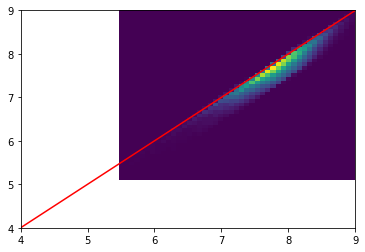

In [155]:
a = sel_spaxel['surface_mass_density_VOR']
b = dep_sur_density[:,np.newaxis][:,0]
plt.hist2d(a[a>0],b[a>0],bins=(50,50))
yy=np.linspace(0,10,50)
plt.plot(yy,yy,color = 'r')
plt.xlim(4,9)
plt.ylim(4,9)
plt.show()

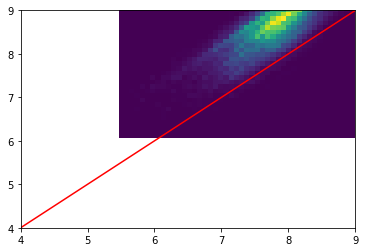

In [28]:
"""
Balmer decrement ha/hb=2.86
实现 intrinsic extinction correction

函数说明：
calzetti00_dered(wave,flux,ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit):
    dereddening函数，进行extinction correction

calzetti00k_wave(wave,Rv,unit)：
    计算 k(lambda)

calzetti00_EBV(ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit):
    可以得到E(B-V)

calzetti00_extinction(wave,A_v,Rv,unit):
    这个是 A(lambda)，用来画extinction curve
    即令A_v=1，则得到消光曲线 A(lambda)/A_v

参数说明：
wave：波长【可以单个数字，也可以一个数组】
flux：需要进行修正的flux
ha_lam：Hα波长
hb_lam：Hβ波长
ha_flux：Hα观测到的flux
hb_flux：Hβ观测到的flux
Rv：calzetti00取的4.05
unit: aa[Angstrom] or um[micron]【波长的单位埃或者微米】

"""
import numpy as np

# 判断输入的flux是数组还是单个数字
def isiterable(obj):
    #a number or an array
    try:
        iter(obj)
        return True
    except TypeError:
        return False

# k(lambda), only a number of the x=1/lambda, not an array
# 只能输入数字，不能是数组
def calzetti00k_x(x,Rv):
	if x>1./0.63:
		# wavelength UV
		k = 2.659 * (((0.011*x - 0.198)*x + 1.509)*x - 2.156) + Rv
	elif 0<=x<=1./0.63:
		k = 2.659 * (1.040*x - 1.857) + Rv
	elif x<0:
		raise ValueError("wavelength negative error")
	return k

# standard form中的 k(lambda)此函数为了同时接收数字和数组变量
def calzetti00k_wave(wave,Rv,unit):
	# judge the unit
	if unit == 'um':
		pass
	elif unit == 'aa':
		wave = wave/1e4
	else:
		raise ValueError("unrecognized unit \nunit = 'aa' or 'um' ")
			
	# x = 1/lambda
	x = 1./wave
	
	if isiterable(x):
		return np.array([calzetti00k_x(i,Rv) for i in x])
	else:
		return calzetti00k_x(x,Rv)

# extinction,即消光函数 A(lambda)
# 令A_v=1，即可画出extinction curve
def calzetti00_extinction(wave,A_v,Rv,unit):
	k = calzetti00k_wave(wave,Rv,unit)
	A_lam = k * A_v / Rv
	return A_lam

# 求出 intrinsic E(B-V)
def calzetti00_EBV(ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit):
	ha_k = calzetti00k_wave(ha_lam,Rv,unit)
	hb_k = calzetti00k_wave(hb_lam,Rv,unit)
	empirical_ratio_ha_hb = 2.86
	EBV = (1/(hb_k-ha_k))*2.5*np.log10(ha_flux/hb_flux/empirical_ratio_ha_hb)
	return EBV

# 消光修正函数 使用的是Balmer decrement
def calzetti00_dered(wave,flux,ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit):
	k = calzetti00k_wave(wave,Rv,unit)
	EBV = calzetti00_EBV(ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit)
	trans = 10.**(0.4 * EBV * k)
	return flux * trans

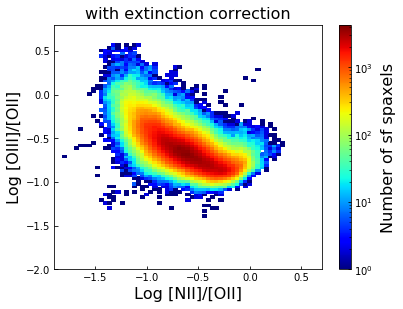

In [29]:
# wave = np.logspace(np.log10(910.), np.log10(30000.), 2000)
# flux = np.ones(1)


# y_wave = red_corr_calzetti00(wave,flux,2.86,ha_lam,hb_lam)
# 元素的波长设定
# ha_6564    hb_4862    nii_6585    oii_3727    oii_3729    oiii_5008    
ha_lam = 0.65645377
hb_lam = 0.48613615
nii_lam = 0.6585
oii7_lam = 0.3727
oii9_lam = 0.3729
oiii_lam = 0.5008

# 获取元素的flux
ha = sel_spaxel['flux_ha'].values.copy()
hb = sel_spaxel['flux_hb'].values.copy()
nii = sel_spaxel['flux_nii'].values.copy()
oiii = sel_spaxel['flux_oiii'].values.copy()
oii9 = sel_spaxel['flux_oii9'].values.copy()
oii7 = sel_spaxel['flux_oii7'].values.copy()
#########################################################
# Hα/Hβ > 2.86 的才做消光修正操作
ha_hb = ha/hb
id_286 = np.where(ha_hb<2.86)
# 临时存储一下flux
tmp_ha = ha.copy()
tmp_hb = hb.copy()
tmp_nii = nii.copy()
tmp_oiii = oiii.copy()
tmp_oii9 = oii9.copy()
tmp_oii7 = oii7.copy()

# 开始消光修正
Rv=4.05
nii = calzetti00_dered(nii_lam,nii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oiii = calzetti00_dered(oiii_lam,oiii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii9 = calzetti00_dered(oii9_lam,oii9,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii7 = calzetti00_dered(oii7_lam,oii7,ha_lam,hb_lam,ha,hb,Rv,unit='um')

#Hα/Hβ <= 2.86 的不做修正
ha[id_286] = tmp_ha[id_286]
hb[id_286] = tmp_hb[id_286]
nii[id_286] = tmp_nii[id_286]
oiii[id_286] = tmp_oiii[id_286]
oii9[id_286] = tmp_oii9[id_286]
oii7[id_286] = tmp_oii7[id_286]
# 消光修正完毕


# 计算元素的flux之比，并log
lg_oiii_oii = np.log10(oiii/(oii7+oii9))
lg_nii_oii = np.log10(nii/(oii7+oii9))

# 画图
y = lg_oiii_oii
x = lg_nii_oii

fig = plt.figure(figsize=(6,4.5))    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置


# hist2d画图
xbins,ybins,hist,cax = ax1.hist2d(x,y,bins=(65,90),range=[[-1.9,0.7],[-2.,0.8]],cmap='jet',norm= mpl.colors.LogNorm(),vmin=1,vmax=(3500./526613.)*x.size) 
# ax1.set_aspect(1)
plt.xlabel('Log [NII]/[OII]',fontsize=16)    # x轴标签
plt.ylabel('Log [OIII]/[OII]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# # colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of sf spaxels",fontsize=16,labelpad=8)
plt.title('with extinction correction',fontsize=16)
plt.show() 


In [75]:
for j in np.arange(5):
    print(j)


0
1
2
3
4


## 金属丰度计算-插值【外插 & 内插】【pyqz】

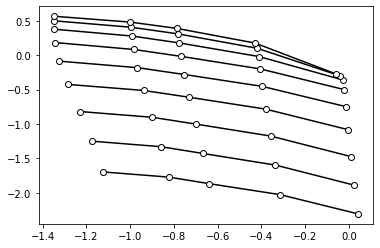

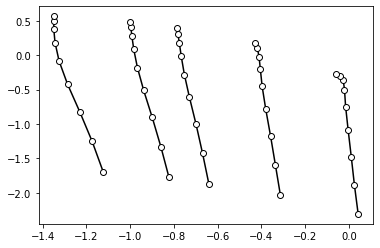

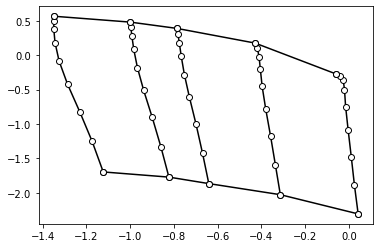

In [31]:
# 读取pq_data的数据
qZ_xy = np.loadtxt("./tmp_storage/pyqz_grid.dat")
logq = qZ_xy[:,0]# value of ionization parameter Log(q)
Z = qZ_xy[:,1]# value of gas matellicity
x_no = qZ_xy[:,2]# value of [NII]/[OII]
y_oo = qZ_xy[:,3]# value of [OIII]/[OII]
# 取出待插值的原数据，9条横线
for i in np.arange(9):
    # 分别给x轴和y轴赋值
    for xy in ['x','y','Z']:
        locals()['line'+str(i+1)+xy]=np.zeros(5)# 初始化数组
        # 横线赋值
        for j in np.arange(5):
            if xy=='x':
                locals()['line'+str(i+1)+xy][j] = x_no[i*5+j]
            elif xy=='y':
                locals()['line'+str(i+1)+xy][j] = y_oo[i*5+j]
            elif xy=='Z':
                locals()['line'+str(i+1)+xy][j] = Z[i*5+j]
# 竖线，5条
for i in range(5):
    # 分别给x轴和y轴赋值
    for xy in ['x','y']:
        locals()['line1'+str(i+1)+xy]=np.zeros(9)
        # 竖线赋值
        for j in range(9):
            if xy=='x':
                locals()['line1'+str(i+1)+xy][j] = x_no[i+5*j]
            elif xy=='y':
                locals()['line1'+str(i+1)+xy][j] = y_oo[i+5*j]
                
# 横线，2条
line16x = x_no[0:5]
line16y = y_oo[0:5]
line17x = x_no[40:45]
line17y = y_oo[40:45]
# 9条横线
for i in range(9):
    xx=locals()['line'+str(i+1)+'x']#[1:5]
    yy=locals()['line'+str(i+1)+'y']#[1:5]
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
plt.show()
# 5条竖线
for i in range(5):
    xx=locals()['line1'+str(i+1)+'x']#[1:5]
    yy=locals()['line1'+str(i+1)+'y']#[1:5]
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
plt.show()
# 论文格子
for i in range(7):
    xx=locals()['line1'+str(i+1)+'x']#[1:5]
    yy=locals()['line1'+str(i+1)+'y']#[1:5]
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
plt.show()

In [59]:
x_no

array([-1.1233, -0.8229, -0.6404, -0.3132,  0.0428, -1.1744, -0.8598,
       -0.6689, -0.3357,  0.0258, -1.2313, -0.8994, -0.6989, -0.3579,
        0.0112, -1.2863, -0.9382, -0.729 , -0.38  , -0.0032, -1.3251,
       -0.9669, -0.7522, -0.3964, -0.0146, -1.3439, -0.9836, -0.7664,
       -0.4048, -0.0197, -1.3495, -0.9923, -0.7752, -0.4106, -0.0255,
       -1.3495, -0.997 , -0.7819, -0.4183, -0.0395, -1.3484, -0.9999,
       -0.7875, -0.4284, -0.06  ])

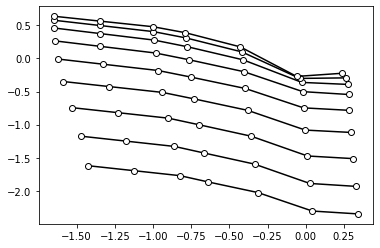

In [32]:
'''
进行外插：extrapolate
1.读取pyqz网格数据
2.使用1D外插反复操作2次进行2D外插
3.得到完整的金属丰度分布图

'''
'''
将grid进行外插
使用1D外插，分别进行多次，得到左右扩展0.3dex的grid
'''
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
# 读取pq_data的数据
qZ_xy = np.loadtxt("./tmp_storage/pyqz_grid.dat")
logq = qZ_xy[:,0]# value of ionization parameter Log(q)
Z = qZ_xy[:,1]# value of gas matellicity
x_no = qZ_xy[:,2]# value of [NII]/[OII]
y_oo = qZ_xy[:,3]# value of [OIII]/[OII]

# 取出待插值的原数据，9条横线
for i in range(9):
    # 分别给x轴和y轴赋值
    for xy in ['x','y','Z']:
        locals()['line'+str(i+1)+xy]=np.zeros(7)# 初始化数组
        # 竖线赋值
        for j in range(5):
            if xy=='x':
                locals()['line'+str(i+1)+xy][j+1] = x_no[i*5+j]
            elif xy=='y':
                locals()['line'+str(i+1)+xy][j+1] = y_oo[i*5+j]
            elif xy=='Z':
                locals()['line'+str(i+1)+xy][j+1] = Z[i*5+j]
# 竖线，5条
for i in range(5):
    # 分别给x轴和y轴赋值
    for xy in ['x','y']:
        locals()['line1'+str(i+1)+xy]=np.zeros(9)
        # 竖线赋值
        for j in range(9):
            if xy=='x':
                locals()['line1'+str(i+1)+xy][j] = x_no[i+5*j]
            elif xy=='y':
                locals()['line1'+str(i+1)+xy][j] = y_oo[i+5*j]
                
# 横线，2条
line16x = x_no[0:5]
line16y = y_oo[0:5]
line17x = x_no[40:45]
line17y = y_oo[40:45]

########################################
############# interpolate ##############
########################################
# 外插[Oiii]/[Oii]-[Nii]/[Oii]格点
for i in range(9):
    # 待插值的样本点
    x=locals()['line'+str(i+1)+'x']
    y=locals()['line'+str(i+1)+'y']
    # 用来插值的点，扩展0.3dex
    xnew = np.array([x[1]-0.3,x[5]+0.3])
    #plt.plot(x,y,"ro",label='sample')# 样本点画图
    kind ='linear'# 'cubic'# interpolation method 
    f=interpolate.interp1d(x[1:5],y[1:5],fill_value="extrapolate",kind=kind)# 使用插值函数
    ynew=f(xnew)# 得到插值结果
    # 将结果赋值给原数组
    x[0]=xnew[0]
    x[6]=xnew[1]
    y[0]=ynew[0]
    y[6]=ynew[1]
    # 外插金属丰度，沿着x方向 [Nii]/[Oii]
    z = locals()['line'+str(i+1)+'Z']
    # 用来插值的点，扩展0.3dex
    xnew = np.array([x[1]-0.3,x[5]+0.3])
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    kind ='linear'# 'cubic'# interpolation method 
    f=interpolate.interp1d(x[1:5],z[1:5],kind=kind,fill_value="extrapolate")# 使用插值函数
    znew=f(xnew)# 得到插值结果
    # 将结果赋值给原数组
    z[0]=znew[0]
    z[6]=znew[1]
############################################################################################
for i in range(9):
    xx=locals()['line'+str(i+1)+'x']
    yy=locals()['line'+str(i+1)+'y']
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
plt.show()
'''
使用girddata函数进行内插
'''
# 初始化待插值数据点
xy_point = np.ones([7*9,2])*np.nan
z_value = np.ones(7*9)*np.nan
# 提取坐标和金属丰度
for i in range(9):
    xy_point[7*i:7*i+7,0] = locals()['line'+str(i+1)+'x']
    xy_point[7*i:7*i+7,1] = locals()['line'+str(i+1)+'y']
    z_value[7*i:7*i+7] = locals()['line'+str(i+1)+'Z']

# 元素的波长设定
# ha_6564    hb_4862    nii_6585    oii_3727    oii_3729    oiii_5008    
ha_lam = 0.65645377
hb_lam = 0.48613615
nii_lam = 0.6585
oii7_lam = 0.3727
oii9_lam = 0.3729
oiii_lam = 0.5008
# 获取元素的flux
ha = sel_spaxel['flux_ha'].values.copy()
hb = sel_spaxel['flux_hb'].values.copy()
nii = sel_spaxel['flux_nii'].values.copy()
oiii = sel_spaxel['flux_oiii'].values.copy()
oii9 = sel_spaxel['flux_oii9'].values.copy()
oii7 = sel_spaxel['flux_oii7'].values.copy()
#########################################################
# Hα/Hβ > 2.86 的才做消光修正操作
ha_hb = ha/hb
id_286 = np.where(ha_hb<2.86)
# 临时存储一下flux
tmp_ha = ha.copy()
tmp_hb = hb.copy()
tmp_nii = nii.copy()
tmp_oiii = oiii.copy()
tmp_oii9 = oii9.copy()
tmp_oii7 = oii7.copy()

# 开始消光修正
Rv=4.05
nii = calzetti00_dered(nii_lam,nii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oiii = calzetti00_dered(oiii_lam,oiii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii9 = calzetti00_dered(oii9_lam,oii9,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii7 = calzetti00_dered(oii7_lam,oii7,ha_lam,hb_lam,ha,hb,Rv,unit='um')

#Hα/Hβ <= 2.86 的不做修正
ha[id_286] = tmp_ha[id_286]
hb[id_286] = tmp_hb[id_286]
nii[id_286] = tmp_nii[id_286]
oiii[id_286] = tmp_oiii[id_286]
oii9[id_286] = tmp_oii9[id_286]
oii7[id_286] = tmp_oii7[id_286]
# 消光修正完毕
#######################################################################


# 计算元素的flux之比，并log
lg_oiii_oii = np.log10(oiii/(oii7+oii9))
lg_nii_oii = np.log10(nii/(oii7+oii9))

x = np.log10(nii/(oii7+oii9))
y = np.log10(oiii/(oii7+oii9))
new_xy = (x,y)
# new_xy = np.append(x,y).reshape(x.size,2).T

# 插值
points = xy_point
values = z_value
method = 'linear'
Znew = griddata(points=points, values=values,xi=new_xy, method=method, fill_value=np.nan, rescale=False)

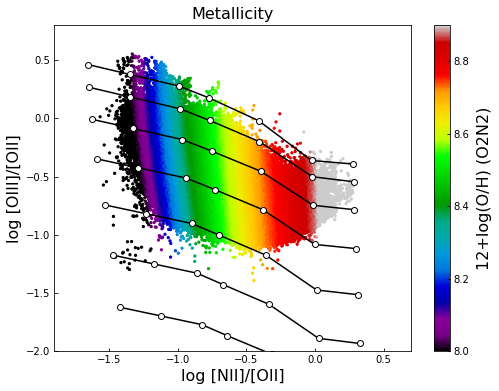

In [33]:
'''做出pyqz计算得到金属丰度的分布图
'''
# 金属丰度分布图.
# import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
# 设置colorbar颜色样式，可以在下面网站查询：
# https://matplotlib.org/tutorials/colors/colormaps.html
cm = plt.cm.get_cmap('nipy_spectral')
z = Znew
# 开始画散点图
sc = plt.scatter(x, y,c=z, vmin=8, vmax=8.9, s=5, cmap=cm)
# 开始画grid格子
for i in range(7):
    xx=locals()['line'+str(i+1)+'x']
    yy=locals()['line'+str(i+1)+'y']
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# 坐标轴范围调整
plt.xlim(-1.9, 0.7)
plt.ylim(-2.0, 0.8)
# 坐标轴标题设置
plt.xlabel('log [NII]/[OII]',fontsize=16)    # x轴标签
plt.ylabel('log [OIII]/[OII]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("12+log(O/H) (O2N2)",fontsize=16,labelpad=8)
plt.title('Metallicity',fontsize=16)
plt.show()

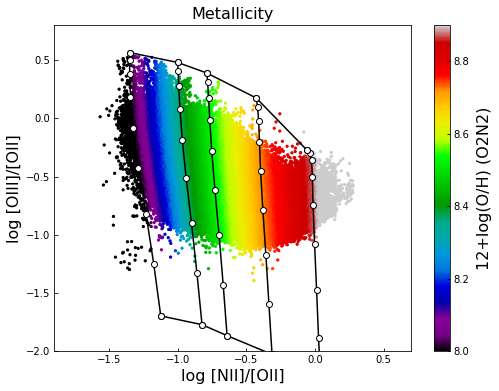

In [34]:
'''做出pyqz计算得到金属丰度的分布图
'''
# 金属丰度分布图.
# import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
# 设置colorbar颜色样式，可以在下面网站查询：
# https://matplotlib.org/tutorials/colors/colormaps.html
cm = plt.cm.get_cmap('nipy_spectral')
z = Znew
# 开始画散点图
sc = plt.scatter(x, y,c=z, vmin=8, vmax=8.9, s=5, cmap=cm)
# 论文格子
for i in range(7):
    xx=locals()['line1'+str(i+1)+'x']
    yy=locals()['line1'+str(i+1)+'y']
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')

# 坐标轴范围调整
plt.xlim(-1.9, 0.7)
plt.ylim(-2.0, 0.8)
# 坐标轴标题设置
plt.xlabel('log [NII]/[OII]',fontsize=16)    # x轴标签
plt.ylabel('log [OIII]/[OII]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("12+log(O/H) (O2N2)",fontsize=16,labelpad=8)
plt.title('Metallicity',fontsize=16)
plt.show()

In [38]:
sel_spaxel

plate-ifu  array_id  bin_id_2800  spaxel_x  spaxel_y  \
0         8252-12701       0.0         17.0      32.0      29.0   
1         8252-12701       0.0         17.0      33.0      29.0   
2         8252-12701       0.0         17.0      31.0      30.0   
3         8252-12701       0.0         17.0      32.0      30.0   
4         8252-12701       0.0         17.0      33.0      30.0   
5         8252-12701       0.0         17.0      34.0      30.0   
6         8252-12701       0.0         21.0      35.0      30.0   
7         8252-12701       0.0         17.0      31.0      31.0   
8         8252-12701       0.0         17.0      32.0      31.0   
9         8252-12701       0.0         17.0      33.0      31.0   
10        8252-12701       0.0         17.0      34.0      31.0   
11        8252-12701       0.0         17.0      35.0      31.0   
12        8252-12701       0.0         17.0      32.0      32.0   
13        8252-12701       0.0         17.0      33.0      32.0   
14        8252-12701       0.0         17.0      34.0      32.0   
15        8252-12701       0.0         14.0      36.0      32.0   
16        8252-12701       0.0         14.0      37.0      32.0   
17        8252-12701       0.0         17.0      31.0      33.0   
18        8252-12701       0.0         17.0      32.0      33.0   
19        8252-12701       0.0         17.0      33.0      33.0   
20        8252-12701       0.0         17.0      34.0      33.0   
21        8252-12701       0.0         17.0      35.0      33.0   
22        8252-12701       0.0         17.0      36.0      33.0   
23        8252-12701       0.0         11.0      37.0      33.0   
24        8252-12701       0.0         18.0      48.0      33.0   
25        8252-12701       0.0         17.0      32.0      34.0   
26        8252-12701       0.0         17.0      33.0      34.0   
27        8252-12701       0.0         17.0      34.0      34.0   
28        8252-12701       0.0          9.0      35.0      34.0   
29        8252-12701       0.0          9.0      36.0      34.0   
...              ...       ...          ...       ...       ...   
13087372  8485-12704    4674.0         86.0      31.0      48.0   
13087373  8485-12704    4674.0         86.0      32.0      48.0   
13087374  8485-12704    4674.0         86.0      33.0      48.0   
13087375  8485-12704    4674.0         84.0      34.0      48.0   
13087376  8485-12704    4674.0         84.0      35.0      48.0   
13087377  8485-12704    4674.0         84.0      36.0      48.0   
13087378  8485-12704    4674.0         84.0      37.0      48.0   
13087379  8485-12704    4674.0         84.0      38.0      48.0   
13087380  8485-12704    4674.0         96.0      25.0      49.0   
13087381  8485-12704    4674.0         96.0      26.0      49.0   
13087382  8485-12704    4674.0         96.0      27.0      49.0   
13087383  8485-12704    4674.0         96.0      28.0      49.0   
13087384  8485-12704    4674.0         90.0      29.0      49.0   
13087385  8485-12704    4674.0         90.0      30.0      49.0   
13087386  8485-12704    4674.0         90.0      31.0      49.0   
13087387  8485-12704    4674.0         90.0      32.0      49.0   
13087388  8485-12704    4674.0         90.0      33.0      49.0   
13087389  8485-12704    4674.0         97.0      25.0      50.0   
13087390  8485-12704    4674.0         97.0      26.0      50.0   
13087391  8485-12704    4674.0         97.0      27.0      50.0   
13087392  8485-12704    4674.0         90.0      28.0      50.0   
13087393  8485-12704    4674.0         90.0      29.0      50.0   
13087394  8485-12704    4674.0         90.0      30.0      50.0   
13087395  8485-12704    4674.0         97.0      26.0      51.0   
13087396  8485-12704    4674.0         97.0      27.0      51.0   
13087397  8485-12704    4674.0         90.0      28.0      51.0   
13087398  8485-12704    4674.0         90.0      29.0      51.0   
13087399  8485-12704    4674.0         97.0      27.0     

In [40]:
df

plate-ifu  array_id  bin_id_2800  spaxel_x  spaxel_y  \
0         8252-12701       0.0         17.0      32.0      29.0   
1         8252-12701       0.0         17.0      33.0      29.0   
2         8252-12701       0.0         17.0      31.0      30.0   
3         8252-12701       0.0         17.0      32.0      30.0   
4         8252-12701       0.0         17.0      33.0      30.0   
5         8252-12701       0.0         17.0      34.0      30.0   
6         8252-12701       0.0         21.0      35.0      30.0   
7         8252-12701       0.0         17.0      31.0      31.0   
8         8252-12701       0.0         17.0      32.0      31.0   
9         8252-12701       0.0         17.0      33.0      31.0   
10        8252-12701       0.0         17.0      34.0      31.0   
11        8252-12701       0.0         17.0      35.0      31.0   
12        8252-12701       0.0         17.0      32.0      32.0   
13        8252-12701       0.0         17.0      33.0      32.0   
14        8252-12701       0.0         17.0      34.0      32.0   
15        8252-12701       0.0         14.0      36.0      32.0   
16        8252-12701       0.0         14.0      37.0      32.0   
17        8252-12701       0.0         17.0      31.0      33.0   
18        8252-12701       0.0         17.0      32.0      33.0   
19        8252-12701       0.0         17.0      33.0      33.0   
20        8252-12701       0.0         17.0      34.0      33.0   
21        8252-12701       0.0         17.0      35.0      33.0   
22        8252-12701       0.0         17.0      36.0      33.0   
23        8252-12701       0.0         11.0      37.0      33.0   
24        8252-12701       0.0         18.0      48.0      33.0   
25        8252-12701       0.0         17.0      32.0      34.0   
26        8252-12701       0.0         17.0      33.0      34.0   
27        8252-12701       0.0         17.0      34.0      34.0   
28        8252-12701       0.0          9.0      35.0      34.0   
29        8252-12701       0.0          9.0      36.0      34.0   
...              ...       ...          ...       ...       ...   
13087372  8485-12704    4674.0         86.0      31.0      48.0   
13087373  8485-12704    4674.0         86.0      32.0      48.0   
13087374  8485-12704    4674.0         86.0      33.0      48.0   
13087375  8485-12704    4674.0         84.0      34.0      48.0   
13087376  8485-12704    4674.0         84.0      35.0      48.0   
13087377  8485-12704    4674.0         84.0      36.0      48.0   
13087378  8485-12704    4674.0         84.0      37.0      48.0   
13087379  8485-12704    4674.0         84.0      38.0      48.0   
13087380  8485-12704    4674.0         96.0      25.0      49.0   
13087381  8485-12704    4674.0         96.0      26.0      49.0   
13087382  8485-12704    4674.0         96.0      27.0      49.0   
13087383  8485-12704    4674.0         96.0      28.0      49.0   
13087384  8485-12704    4674.0         90.0      29.0      49.0   
13087385  8485-12704    4674.0         90.0      30.0      49.0   
13087386  8485-12704    4674.0         90.0      31.0      49.0   
13087387  8485-12704    4674.0         90.0      32.0      49.0   
13087388  8485-12704    4674.0         90.0      33.0      49.0   
13087389  8485-12704    4674.0         97.0      25.0      50.0   
13087390  8485-12704    4674.0         97.0      26.0      50.0   
13087391  8485-12704    4674.0         97.0      27.0      50.0   
13087392  8485-12704    4674.0         90.0      28.0      50.0   
13087393  8485-12704    4674.0         90.0      29.0      50.0   
13087394  8485-12704    4674.0         90.0      30.0      50.0   
13087395  8485-12704    4674.0         97.0      26.0      51.0   
13087396  8485-12704    4674.0         97.0      27.0      51.0   
13087397  8485-12704    4674.0         90.0      28.0      51.0   
13087398  8485-12704    4674.0         90.0      29.0      51.0   
13087399  8485-12704    4674.0         97.0      27.0     

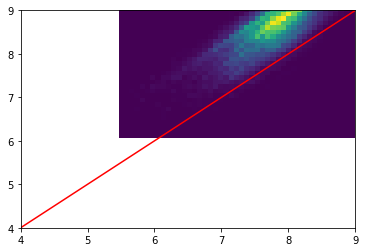

In [133]:
a = sel_spaxel['surface_mass_density_VOR']
b = dep_sur_density[:,np.newaxis][:,0]
plt.hist2d(a[a>0],b[a>0],bins=(50,50))
yy=np.linspace(0,10,50)
plt.plot(yy,yy,color = 'r')
plt.xlim(4,9)
plt.ylim(4,9)
plt.show()


### 导出数据 包含 deprojected surface mass density

In [156]:
# save sel_spaxel
tmp_data = {'plate-ifu':sel_spaxel['plate-ifu'],
            'array_id':sel_spaxel['array_id'],
            'bin_id_2800':sel_spaxel['bin_id_2800'],
            'spaxel_x':sel_spaxel['spaxel_x'],
            'spaxel_y':sel_spaxel['spaxel_y'],
            'metallicity_pyqz':Znew[:,np.newaxis][:,0],
            'surface_mass_density_VOR':sel_spaxel['surface_mass_density_VOR'],
            'dep_surface_mass_density':dep_sur_density[:,np.newaxis][:,0],
            'flux_ha':sel_spaxel['flux_ha'],
            'flux_hb':sel_spaxel['flux_hb'],
            'flux_nii':sel_spaxel['flux_nii'],
            'flux_oii7':sel_spaxel['flux_oii7'],
            'flux_oii9':sel_spaxel['flux_oii9'],
            'flux_oiii':sel_spaxel['flux_oiii']
           }
# 转换为 pandas 数组， dataframe类型
df = pd.DataFrame(tmp_data,columns=['plate-ifu','array_id','bin_id_2800','spaxel_x','spaxel_y',\
                                    'metallicity_pyqz','surface_mass_density_VOR','dep_surface_mass_density',\
                                    'flux_ha','flux_hb','flux_nii','flux_oii7','flux_oii9','flux_oiii'])
# df
# pandas 导出为压缩的 序列化 数据
df.to_pickle("./tmp_storage/MaNGA_metal_spaxel.v3.0.pd.pkl")

In [51]:
Znew.shape

(641525,)

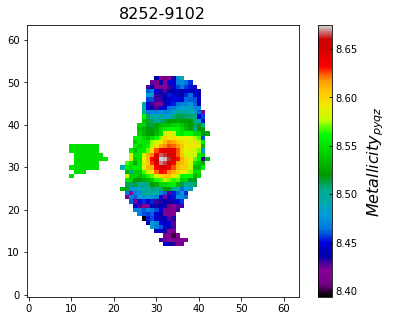

In [70]:
'''得到指定星系的金属丰度分布图
'''

arr_id = sel_spaxel['array_id'].values.copy()  # 4675数组中位置
x2800 = sel_spaxel['bin_id_2800'].values.copy()  # 2800定位数组中的值

# manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")
# firefly_fits = fits.open('/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
plateifu = sel_spaxel['plate-ifu'].values.copy()
# path_marvin_maps = '/mnt/ddnfs/data_users/yhwang/bak_la/root/bash_file/marvin_vor10_fits'#'/root/bash_file/manga_maps_data'
path_marvin_maps = '/mnt/ddnfs/data_users/yhwang/bak_la/root/bash_file/manga_maps_data'
def _Zpyqz_plot(plifu,x2800):
    tmp_id = (plifu==plateifu)
    xx2800 = x2800[tmp_id].astype(int)
    Z = Znew[tmp_id].copy()
    # 一维转二维   
    # 使用Marvin读取数据
    #filename = join(path_marvin_maps, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(plifu))
    filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564
    image_sz = np.shape(ha)[0]    # 图像边长
    # 2800数组转为二维正方形矩阵，导出 mask
    #read in the vac file
    tmp_iid = (plifu==firefly_fits[1].data['PLATEIFU'])
    binid = firefly_fits[5].data[tmp_iid,:,:][0]
    bin1d = firefly_fits[4].data[tmp_iid,:,0][0][xx2800]    # 获取一维的bin数据
    arr_2800 = Z
    # 画图
    image_sz = np.shape(ha)[0]    # 图像边长
    matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                matrix[i,j] = arr_2800[idbin]
    return matrix
#******************************************************************************************************************
plifu = '8252-9102'#'8252-9102'#'8551-3701'
x2800 = sel_spaxel['bin_id_2800'].values.copy()  # 2800定位数组中的值
mtx_plt = _Zpyqz_plot(plifu,x2800)
# 开始画图
fig, ax = plt.subplots(figsize=(7, 5))
# cm = plt.cm.get_cmap('rainbow')
sc = plt.imshow(mtx_plt,origin='lower',cmap=cm)#,vmin=0,vmax=8.8)
# #sc = plt.imshow(mtx_plt,origin='lower',cmap=cm)
# fig.set_size_inches(7, 5)    # 调整大小
# plt.xlabel('spaxel',fontsize=16)    # x轴标签
# plt.ylabel('spaxel',fontsize=16)    # y轴标签
# plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
# cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
cbar.set_label('$Metallicity_{pyqz}$',fontsize=16,labelpad=8)
plt.title(plifu,fontsize=16)
plt.show()

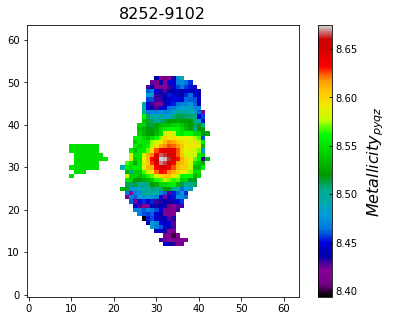

In [71]:

plifu = '8252-9102'#'8252-9102'#'8551-3701'
x2800 = sel_spaxel['bin_id_2800'].values.copy()  # 2800定位数组中的值
mtx_plt = _Zpyqz_plot(plifu,x2800)
# 开始画图
fig, ax = plt.subplots(figsize=(7, 5))
# cm = plt.cm.get_cmap('rainbow')
sc = plt.imshow(mtx_plt,origin='lower',cmap=cm)#,vmin=0,vmax=8.8)
# #sc = plt.imshow(mtx_plt,origin='lower',cmap=cm)
# fig.set_size_inches(7, 5)    # 调整大小
# plt.xlabel('spaxel',fontsize=16)    # x轴标签
# plt.ylabel('spaxel',fontsize=16)    # y轴标签
# plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
# cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
cbar.set_label('$Metallicity_{pyqz}$',fontsize=16,labelpad=8)
plt.title(plifu,fontsize=16)
plt.show()

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fff7c8c2b70>)

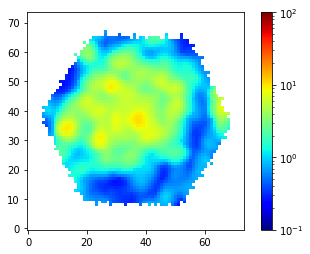

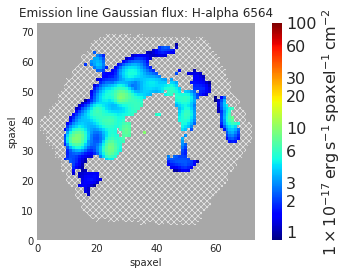

In [165]:
import matplotlib as mpl
from marvin.tools import Maps
plateifu = '8466-12702'#'8945-12705'# '8252-9102'
# path_marvin_maps = '/mnt/ddnfs/data_users/yhwang/bak_la/root/bash_file/marvin_vor10_fits'
# filename = join(path_marvin_maps, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(plateifu))
path_marvin_data = '../../bak_la/root/bash_file/manga_maps_data'
filename = join(path_marvin_data, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plateifu))
new_maps = Maps(filename=filename)

# new_maps = Maps(plateifu)


# ha = new_maps.emline_gflux_ha_6564    # 获取Hα
# nii = new_maps.emline_gflux_nii_6585    # 获取Nii
# oii7 = new_maps.emline_gflux_oii_3727    # 获取O
# oii9 = new_maps.emline_gflux_oii_3729    # 获取O
ha = new_maps.emline_gflux_ha_6564    # 获取Hα6564
hb = new_maps.emline_gflux_hb_4862    # 获取Hβ4862
nii = new_maps.emline_gflux_nii_6585    # 获取Nii_6584
oii7 = new_maps.emline_gflux_oii_3727    # 获取Oii_3726
oii9 = new_maps.emline_gflux_oii_3729    # 获取Oii_3729
oiii = new_maps.emline_gflux_oiii_5008    # 获取Oiii_5007
# 计算金属丰度
RR = (oii7+oii9) / nii;    # Oii/Nii
# 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
oh =  logRR + 8.93;

# 利用Marvin计算mask
masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
mask_non_sf = ~masks_bpt['sf']['nii'] * RR.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
# mask_bad_data = RR.pixmask.get_mask([ 'DONOTUSE'])
min_snr = 10.
# mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
# mask_oii7_low_snr = (np.abs(ha.value * np.sqrt(oii7.ivar)) < min_snr)
# mask_oii9_low_snr = (np.abs(ha.value * np.sqrt(oii9.ivar)) < min_snr)
mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
mask_hb_low_snr = (np.abs(hb.value * np.sqrt(hb.ivar)) < min_snr)
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_oii7_low_snr = (np.abs(oii7.value * np.sqrt(oii7.ivar)) < min_snr)
mask_oii9_low_snr = (np.abs(oii9.value * np.sqrt(oii9.ivar)) < min_snr)
mask_oiii_low_snr = (np.abs(oiii.value * np.sqrt(oiii.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr | mask_hb_low_snr | mask_oiii_low_snr #| mask_oii7_low_snr | mask_oii9_low_snr
# new_mask = mask_non_sf | mask_ha_low_snr | mask_hb_low_snr | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr| mask_oiii_low_snr
# ha.plot(cmap='jet',norm=mpl.colors.LogNorm())
fig, ax = plt.subplots()
p = ax.imshow(ha.value , cmap='jet',origin='lower',vmin=0.1,vmax=100,norm=mpl.colors.LogNorm())
fig.colorbar(p)
ha.plot(cmap='jet',mask=new_mask,log_cb=True,cbrange=(0.1,100))

## 1D -> 2D 匹配时，需要做一下矩阵的转置
**直接使用已提取的(x,y)信息即可，无需再进行匹配**

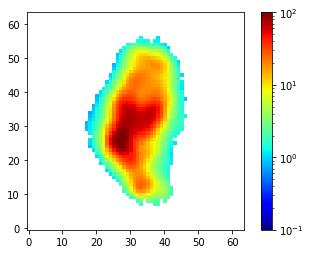

In [88]:
# 检测是否和论文的星系区域一致

plateifu = '8252-9102'#'8945-12705'
lala = sel_spaxel[(sel_spaxel['plate-ifu']==plateifu)]#&sel_spaxel['plate-ifu']!='-999']

def _get_arr_id(plateifu):
    tmp_id = (lalala_spaxel['plate-ifu']==plateifu)
    arr_id = lalala_spaxel['array_id'][tmp_id].values.astype(int)[0]
    return arr_id

# i = _get_arr_id(plateifu)#666
# start = 2800*i
# end = start+2800
# plateifu = plateifu_4675[i]#['8252-9102','9883-3701','8466-12702'][i]
filename = join(path_marvin_data, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plateifu))
new_maps = Maps(filename=filename)
ha = new_maps.emline_gflux_ha_6564    # 获取Hα6564
image_sz = np.shape(ha)[0]    # 图像边长
maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
def _plt(x,y,ha):
    if ha>=0:
        maps[x,y] = ha
    else:
        pass
    #print("x = ",x)
    #print("y = ",y)
    #print("ha = ",ha)
    return None
[ _plt(int(x),int(y),ha) for (x,y,ha) in zip(lala['spaxel_x'],lala['spaxel_y'],lala['flux_ha'])]
fig, ax = plt.subplots()

# p = ax.imshow(maps.T , origin='lower',cmap='jet',vmin=0.1,vmax=100)
p = ax.imshow(maps.T , cmap='jet',origin='lower',vmin=0.1,vmax=100,norm=mpl.colors.LogNorm())
fig.colorbar(p)
plt.show()
# ha.plot(cmap='jet',mask=new_mask,log_cb=True,cbrange=(0.1,100))

In [90]:
dep_sur_density

array([6.15155316, 6.15155316, 6.15155316, ..., 6.03848188, 5.71388119,
       5.71388119])

In [157]:
def _stellar_mass(plateifu):
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    
    ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
    #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id][0]
    
    try:
        ste_mass = math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun
        return ste_mass
    except:
        return -999


# read the data containing metallicity etc.
manga_Z = pd.read_pickle("./tmp_storage/MaNGA_metal_spaxel.v3.0.pd.pkl")

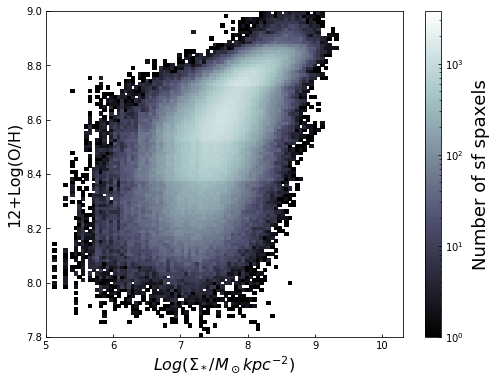

In [159]:
# 画图
y = manga_Z['metallicity_pyqz'].copy()
# x = spaxel_density# PIPE3D surface mass density
x = manga_Z['dep_surface_mass_density']


fig = plt.figure(figsize=(8,6))    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置

# hist2d画图
xbins,ybins,hist,cax = ax1.hist2d(x,y,bins=(100,100),# 分组个数
                                  range=[[5,10.3],[7.8,9.0]],# 坐标轴范围
                                  cmap='bone',norm= mpl.colors.LogNorm(),vmin=1,vmax=3800)# colorbar样式
# ax1.set_aspect(1)    # 1：1图的大小
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of sf spaxels",fontsize=18,labelpad=8)
# plt.title('with intrinsic extinction correction',fontsize=16)
plt.show()

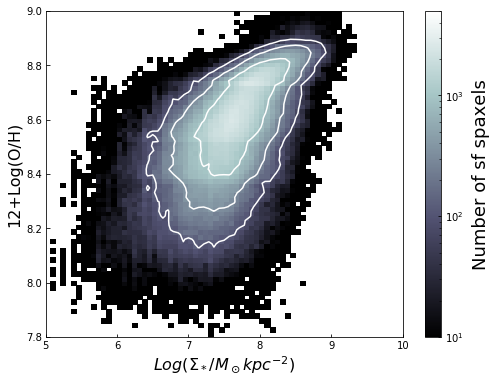

In [161]:
# 加入等高线 contour

y = manga_Z['metallicity_pyqz'].copy()
# x = spaxel_density# PIPE3D surface mass density
x = manga_Z['dep_surface_mass_density']
# x = firefly_spaxel_density.copy()# firefly surface mass density
fig = plt.figure(figsize=(8,6))    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置

# hist2d画图
nhist,xbins,ybins,cax = ax1.hist2d(x,y,bins=(70,70),# 分组个数
                                  range=[[5,10],[7.8,9]],# 坐标轴范围
                                  cmap='bone',norm= mpl.colors.LogNorm(),vmin=10**1,vmax=10**3.7)# colorbar样式

plt.contour(xbins[1:],ybins[1:],nhist.transpose(),[10**2,10**2.5,10**3],colors='white',norm= mpl.colors.LogNorm(),linewidth=0.5,vmin=0.1,vmax=3800)
# ax1.set_aspect(1)    # 1：1图的大小
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of sf spaxels",fontsize=18,labelpad=8)
# plt.title('with intrinsic extinction correction',fontsize=16)
plt.show()

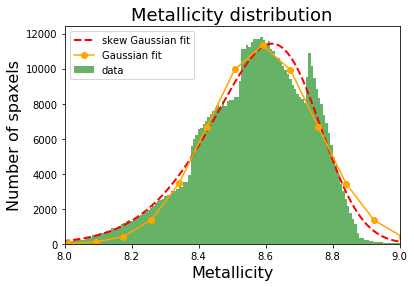

In [170]:
# 全部 >10^9Msun 的spaxel的金属丰度分布拟合 
# 偏态分布【倾斜版高斯分布】的拟合
######################################################
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import asarray as ar,exp
from scipy.optimize import curve_fit

# 一般高斯函数
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
# 加强版高斯函数【plus=0就是一般高斯函数】
def gua_plus(x,a,x0,sigma,plus):
    #norm = a/sigma*exp(-(x-x0)**2/(2*sigma**2))
    #cdf = stats.norm.cdf(plus*x, loc=x0, scale=sigma)
    #cdf = stats.norm.cdf(plus*(x-x0)/sigma, loc=0, scale=1)
    #return 2*norm*cdf
    result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return result

# spaxels筛选
# 去除 surface mass density 为 inf 的 spaxel
del_id = ~np.isinf(manga_Z['surface_mass_density_VOR'].values)
sel_manga_Z = manga_Z[del_id]
# deprojected surface mass density
sel_density = sel_manga_Z['dep_surface_mass_density'].values.copy()
# metallicity of every spaxel
sel_Z = sel_manga_Z['metallicity_pyqz'].copy()

# 生成一个符合skewnorm分布的随机数组
# sel_Z = stats.skewnorm.rvs(-10,loc=10, size=1000)

# 金属丰度分布画图
hist,bins,__ = plt.hist(sel_Z,bins=200, alpha=0.6, color='g',label='data')
xmin, xmax = plt.xlim()
# plt.show()

# 定义直方图中的各个点的坐标
x = (bins[1:]-(bins[1]-bins[0])/2).copy()
y = hist.copy()

n = len(x)# 拟合数据长度
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差
ymax = np.max(y)# y轴最大值，即拟合函数的幅度[高度]大小

# 开始拟合！！！
popt,pcov = curve_fit(gua_plus,x,y,p0=[ymax,mean,sigma,-3])
popt0,pcov0 = curve_fit(gaus,x,y,p0=[ymax,mean,sigma])

# 拟合曲线画图
newx = np.linspace(xmin,xmax,200)
newx0 = np.linspace(xmin,xmax,20)
# plt.show()
plt.plot(newx,gua_plus(newx,*popt), 'r--', linewidth=2,label='skew Gaussian fit')
# plt.show()
plt.plot(newx0,gaus(newx0,*popt0),'o-',color='orange',label='Gaussian fit')


plt.legend(loc='best')
plt.title('Metallicity distribution',fontsize=18)
plt.xlabel('Metallicity',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.xlim([8,9])
plt.show()

### 检查金属丰度数据正确！！！

In [173]:
'''extinction correction'''
# 元素的波长设定
# ha_6564    hb_4862    nii_6585    oii_3727    oii_3729    oiii_5008    
ha_lam = 0.65645377
hb_lam = 0.48613615
nii_lam = 0.6585
oii7_lam = 0.3727
oii9_lam = 0.3729
oiii_lam = 0.5008
# 获取元素的flux
ha = sel_manga_Z['flux_ha'].values.copy()
hb = sel_manga_Z['flux_hb'].values.copy()
nii = sel_manga_Z['flux_nii'].values.copy()
oiii = sel_manga_Z['flux_oiii'].values.copy()
oii9 = sel_manga_Z['flux_oii9'].values.copy()
oii7 = sel_manga_Z['flux_oii7'].values.copy()
#########################################################
# Hα/Hβ > 2.86 的才做消光修正操作
ha_hb = ha/hb
id_286 = np.where(ha_hb<2.86)
# 临时存储一下flux
tmp_ha = ha.copy()
tmp_hb = hb.copy()
tmp_nii = nii.copy()
tmp_oiii = oiii.copy()
tmp_oii9 = oii9.copy()
tmp_oii7 = oii7.copy()

# 开始消光修正
Rv=4.05
nii = calzetti00_dered(nii_lam,nii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oiii = calzetti00_dered(oiii_lam,oiii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii9 = calzetti00_dered(oii9_lam,oii9,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii7 = calzetti00_dered(oii7_lam,oii7,ha_lam,hb_lam,ha,hb,Rv,unit='um')

#Hα/Hβ <= 2.86 的不做修正
ha[id_286] = tmp_ha[id_286]
hb[id_286] = tmp_hb[id_286]
nii[id_286] = tmp_nii[id_286]
oiii[id_286] = tmp_oiii[id_286]
oii9[id_286] = tmp_oii9[id_286]
oii7[id_286] = tmp_oii7[id_286]
# 消光修正完毕
#######################################################################


# 计算元素的flux之比，并log
lg_oiii_oii = np.log10(oiii/(oii7+oii9))
lg_nii_oii = np.log10(nii/(oii7+oii9))

x = np.log10(nii/(oii7+oii9))
y = np.log10(oiii/(oii7+oii9))

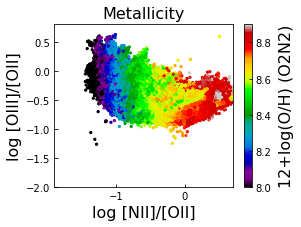

'with extinction correction'

In [179]:
# 检查数据是否正确
'''做出pyqz计算得到金属丰度的分布图
'''
# 金属丰度分布图.
# import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
# 设置colorbar颜色样式，可以在下面网站查询：
# https://matplotlib.org/tutorials/colors/colormaps.html
cm = plt.cm.get_cmap('nipy_spectral')
x = np.log10(sel_manga_Z['flux_nii'].values/(sel_manga_Z['flux_oii7'].values+sel_manga_Z['flux_oii9'].values))
y = np.log10(sel_manga_Z['flux_oiii'].values/(sel_manga_Z['flux_oii7'].values+sel_manga_Z['flux_oii9'].values))
z = sel_manga_Z['metallicity_pyqz']
# 开始画散点图
sc = plt.scatter(x, y,c=z, vmin=8, vmax=8.9, s=5, cmap=cm)
# # 开始画grid格子
# for i in range(7):
#     xx=locals()['line'+str(i+1)+'x']
#     yy=locals()['line'+str(i+1)+'y']
#     plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# 坐标轴范围调整
plt.xlim(-1.9, 0.7)
plt.ylim(-2.0, 0.8)
# 坐标轴标题设置
plt.xlabel('log [NII]/[OII]',fontsize=16)    # x轴标签
plt.ylabel('log [OIII]/[OII]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("12+log(O/H) (O2N2)",fontsize=16,labelpad=8)
plt.title('Metallicity',fontsize=16)
plt.show()
'''with extinction correction'''

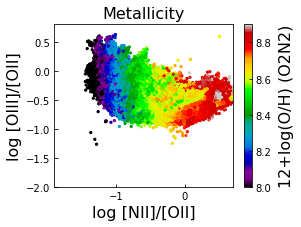

In [178]:
'''without extinction correction'''

### 正式开始求`金属丰度预期值`

In [16]:
import time  # estimate running time
from copy import copy as copy  # avoid to change the value of pointer
import warnings  # shut down the annoying messages
from os.path import join  # stick different variables together
from multiprocessing import Pool  # multi-running!!!
from functools import partial  # convert to single parameter function

import math  # just for some specific calculate
import numpy as np  # array
import pandas as pd  # more powerful array
import matplotlib as mpl
import matplotlib.pyplot as plt  # plot
from scipy import stats
from scipy import asarray as ar,exp
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import griddata

from astropy.io import fits    # read fits file
from marvin.tools import Maps  # use Marvin to get BPT, flux, image etc.

warnings.filterwarnings('ignore')  # ignore Warnings

# read the data containing metallicity etc.
manga_Z = pd.read_pickle("./tmp_storage/MaNGA_metal_spaxel.v3.0.pd.pkl")
# read data [prepare]
drp_fits = copy(fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'))
firefly_fits = copy(fits.open("../../bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits"))
# lalala_spaxel = copy(pd.read_pickle("./tmp_storage/MaNGA_spaxel.v3.0.pd.pkl"))
# fracDeV_txt = copy(np.loadtxt('lalala_manga_fradeV.txt'))

# spaxels筛选
# 去除 surface mass density 为 inf 的 spaxel
del_id = ~np.isinf(manga_Z['surface_mass_density_VOR'].values)
sel_manga_Z = manga_Z[del_id]
# deprojected surface mass density
sel_density = sel_manga_Z['dep_surface_mass_density'].values.copy()
# metallicity of every spaxel
sel_Z = sel_manga_Z['metallicity_pyqz'].copy()

In [3]:
'''
mass_spaxel    # 每个spaxel所在的星系质量stellar mass
firefly_spaxel_density     # 每个spaxel的质量密度
Znew    # 每个spaxel的金属丰度
得到的最终结果为：expeted_data
    第一列：surface mass density
    第二列：metallicity mode
'''
#import matplotlib.mlab as mlab
# 高斯分布【正态分布】
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result
def _stellar_mass(plateifu):
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    
    ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
    #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id][0]
    ste_mass = math.log10(ste_mass)
    return ste_mass
# mass_spaxel = np.array(list(map(_stellar_mass, sel_manga_Z['plate-ifu'].values)))
#     try:
#         ste_mass = math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun
#         return ste_mass
#     except:
#         return -999
start_time = time.time()
pool = Pool(processes=30,maxtasksperchild=1000)

mass_spaxel = np.array(pool.map(_stellar_mass, sel_manga_Z['plate-ifu'].values))

pool.close()
pool.join()
end_time = time.time()
print("used time is %.2f s" % (end_time-start_time))

used time is 18.27 s


max is  8.647837348991475
min is  7.859303050872051
mean =  8.253570199931762
expected Z is 8.25
stellar mass range =  [8.5 9. ] 
surface mass density =  6.8 
expected metallicity =  8.246847272747576


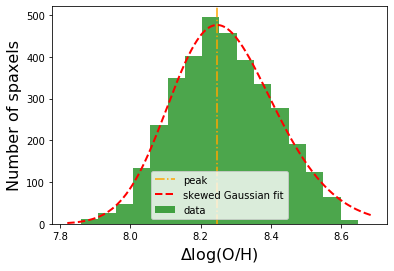

max is  8.722491312541813
min is  7.856094839923161
mean =  8.289293076232488
expected Z is 8.30
stellar mass range =  [8.5 9. ] 
surface mass density =  7.0 
expected metallicity =  8.303923643729403


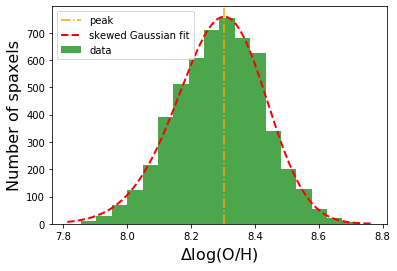

max is  8.734335276690263
min is  7.838860473123493
mean =  8.311472175005955
expected Z is 8.35
stellar mass range =  [8.5 9. ] 
surface mass density =  7.2 
expected metallicity =  8.349793373970474


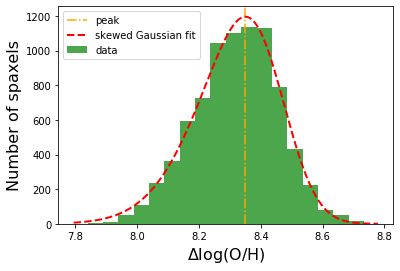

max is  8.767521820473094
min is  7.783722870146969
mean =  8.324812292826337
expected Z is 8.39
stellar mass range =  [8.5 9. ] 
surface mass density =  7.4 
expected metallicity =  8.390723575636965


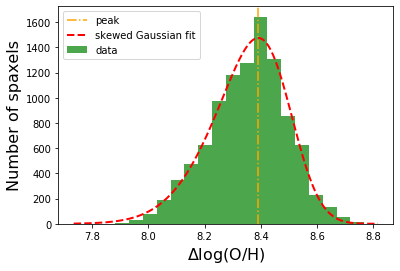

max is  8.741999187293972
min is  7.750354178380208
mean =  8.32055005850562
expected Z is 8.42
stellar mass range =  [8.5 9. ] 
surface mass density =  7.6000000000000005 
expected metallicity =  8.422960042236953


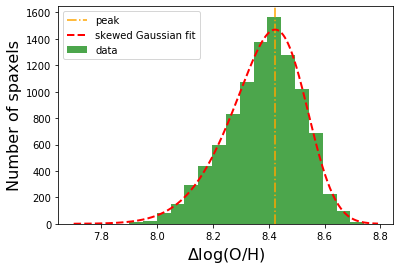

max is  8.8276412540131
min is  7.918962237820382
mean =  8.37330174591674
expected Z is 8.47
stellar mass range =  [8.5 9. ] 
surface mass density =  7.800000000000001 
expected metallicity =  8.465119312074389


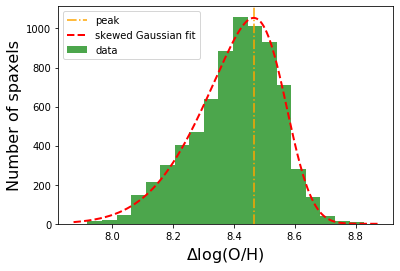

max is  8.815229760672487
min is  7.853858593543581
mean =  8.38261273546448
expected Z is 8.49
stellar mass range =  [8.5 9. ] 
surface mass density =  8.0 
expected metallicity =  8.491018175102226


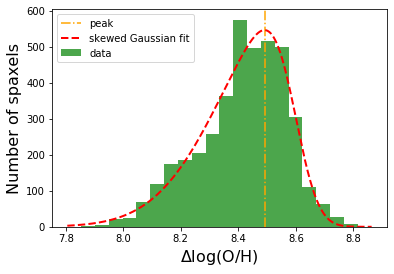

max is  8.827810653801432
min is  7.9135183889114975
mean =  8.394724844116727
expected Z is 8.48
stellar mass range =  [8.5 9. ] 
surface mass density =  8.200000000000001 
expected metallicity =  8.477331952260291


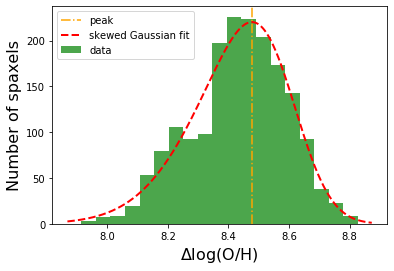

max is  8.790765979163467
min is  8.072333019639174
mean =  8.431549499401319
expected Z is 8.51
stellar mass range =  [8.5 9. ] 
surface mass density =  8.400000000000002 
expected metallicity =  8.505408201345816


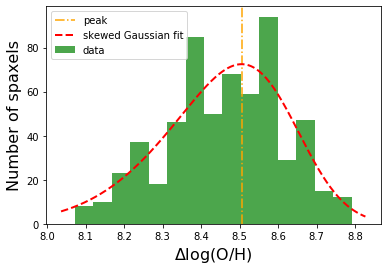

max is  8.793972195941802
min is  8.179482745378955
mean =  8.49618115451519
expected Z is 8.58
stellar mass range =  [8.5 9. ] 
surface mass density =  8.600000000000001 
expected metallicity =  8.581264309208509


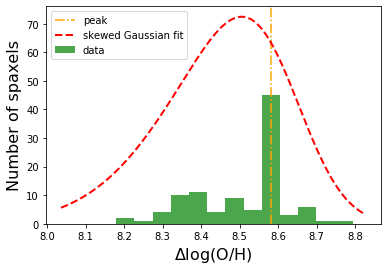

max is  8.79875460556581
min is  7.899926082177458
mean =  8.349340343871633
expected Z is 8.43
stellar mass range =  [9.  9.5] 
surface mass density =  6.8 
expected metallicity =  8.428395723899026


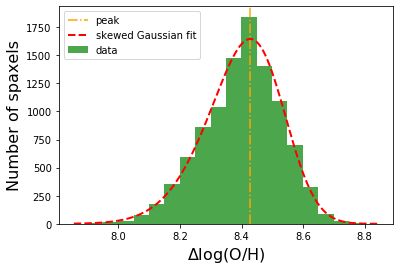

max is  8.801868356382549
min is  7.865934009238286
mean =  8.333901182810418
expected Z is 8.44
stellar mass range =  [9.  9.5] 
surface mass density =  7.0 
expected metallicity =  8.439901668001287


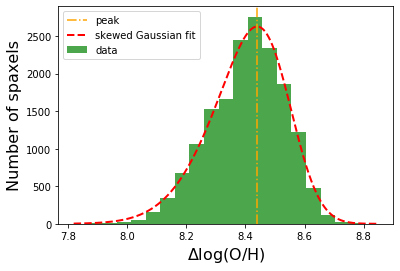

max is  8.793825617643929
min is  7.929439076717853
mean =  8.361632347180892
expected Z is 8.46
stellar mass range =  [9.  9.5] 
surface mass density =  7.2 
expected metallicity =  8.461716707392629


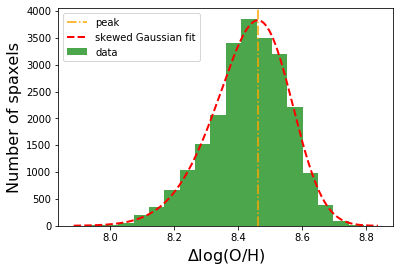

max is  8.813064467439197
min is  7.751858019397342
mean =  8.354816228512032
expected Z is 8.48
stellar mass range =  [9.  9.5] 
surface mass density =  7.4 
expected metallicity =  8.483903677532266


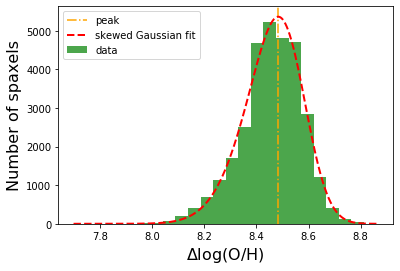

max is  8.841884738834025
min is  7.683835736160642
mean =  8.431742383720536
expected Z is 8.51
stellar mass range =  [9.  9.5] 
surface mass density =  7.6000000000000005 
expected metallicity =  8.512369475312056


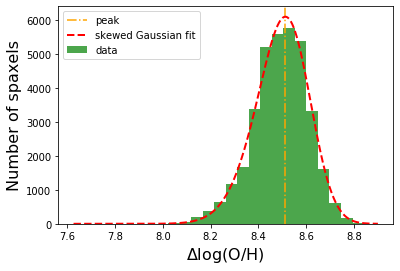

max is  8.843235835180849
min is  7.883504537417043
mean =  8.459343316075326
expected Z is 8.55
stellar mass range =  [9.  9.5] 
surface mass density =  7.800000000000001 
expected metallicity =  8.54935111930345


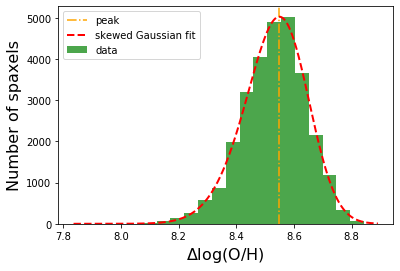

max is  8.946751609930882
min is  7.995116341391444
mean =  8.497523784635057
expected Z is 8.59
stellar mass range =  [9.  9.5] 
surface mass density =  8.0 
expected metallicity =  8.5912755313472


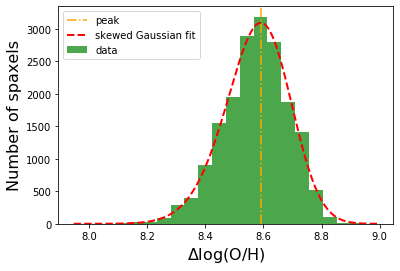

max is  8.96702876981039
min is  8.138468509603001
mean =  8.552748639706696
expected Z is 8.63
stellar mass range =  [9.  9.5] 
surface mass density =  8.200000000000001 
expected metallicity =  8.629998894990058


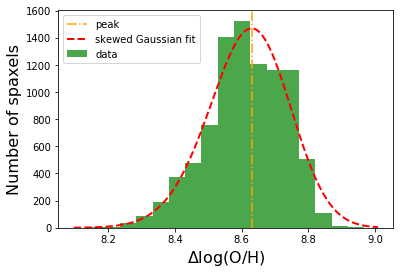

max is  8.967325373408336
min is  8.245235701588353
mean =  8.582210881771012
mean =  8.630685501473002


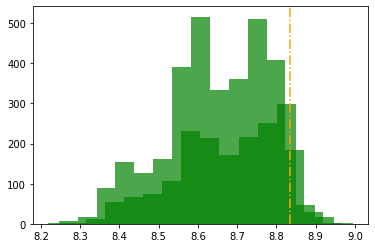

expected Z is 8.84
expected Z is 8.84
stellar mass range =  [9.  9.5] 
surface mass density =  8.5 
expected metallicity =  8.835486951433769


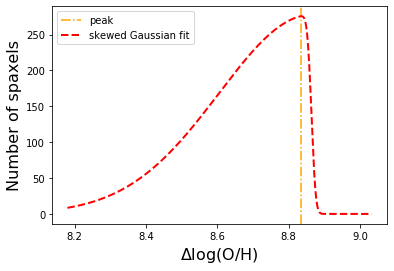

max is  8.99422180608089
min is  8.218677689584059
mean =  8.654921255113527
expected Z is 8.82
stellar mass range =  [9.  9.5] 
surface mass density =  8.600000000000001 
expected metallicity =  8.824571530597208


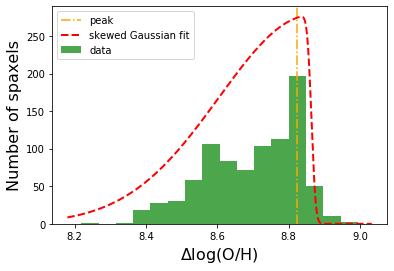

max is  8.936301986748367
min is  8.378302955927737
delta_bins =  0.06
mean =  8.759602293655165
expected Z is 8.85
stellar mass range =  [9.  9.5] 
surface mass density =  8.8 
expected metallicity =  8.852602132125273


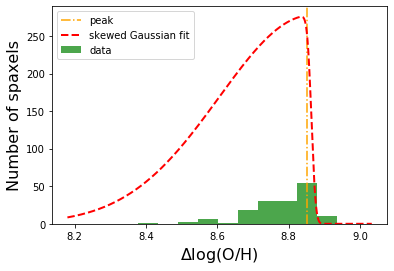

max is  8.875930822456187
min is  8.702314871029145
delta_bins =  0.06
mean =  8.789122846742666
expected Z is 8.85
stellar mass range =  [9.  9.5] 
surface mass density =  9.000000000000002 
expected metallicity =  8.84699483055168


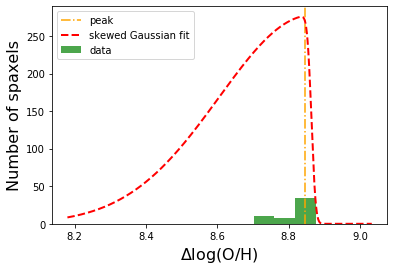

max is  8.795025919641374
min is  7.837792474724688
mean =  8.436063377797618
expected Z is 8.51
stellar mass range =  [ 9.5 10. ] 
surface mass density =  6.8 
expected metallicity =  8.51443752426398


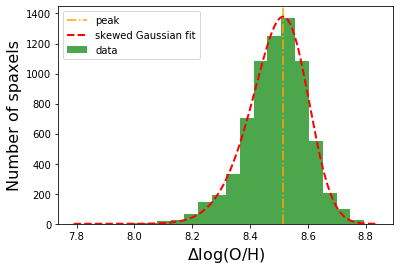

max is  8.802562390097561
min is  7.918088305001683
mean =  8.409462796721618
expected Z is 8.52
stellar mass range =  [ 9.5 10. ] 
surface mass density =  7.0 
expected metallicity =  8.517711137719322


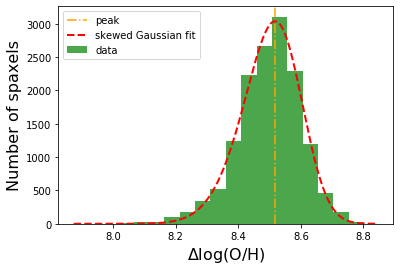

max is  8.843904034022259
min is  7.700779515910725
mean =  8.37174390697619
expected Z is 8.55
stellar mass range =  [ 9.5 10. ] 
surface mass density =  7.2 
expected metallicity =  8.545547277232421


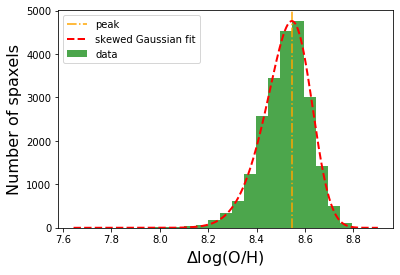

max is  8.828429768802252
min is  7.714464172640719
mean =  8.416746831090379
expected Z is 8.57
stellar mass range =  [ 9.5 10. ] 
surface mass density =  7.4 
expected metallicity =  8.569055931148139


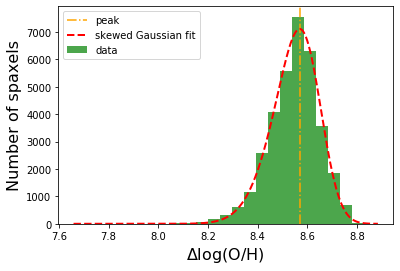

max is  8.873338378846599
min is  7.914647105718819
mean =  8.441927305939098
expected Z is 8.60
stellar mass range =  [ 9.5 10. ] 
surface mass density =  7.6000000000000005 
expected metallicity =  8.602447450900646


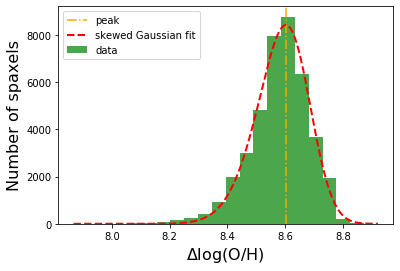

max is  8.897469103935814
min is  7.929649144424813
mean =  8.486145621143638
expected Z is 8.65
stellar mass range =  [ 9.5 10. ] 
surface mass density =  7.800000000000001 
expected metallicity =  8.64582526737869


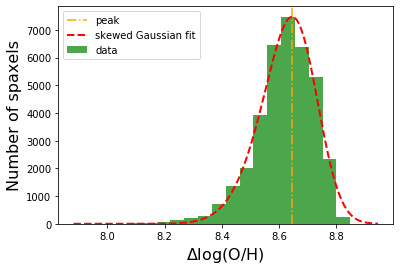

max is  8.900082730595066
min is  7.742618870765399
mean =  8.490147613572061
expected Z is 8.72
stellar mass range =  [ 9.5 10. ] 
surface mass density =  8.0 
expected metallicity =  8.721497135060291


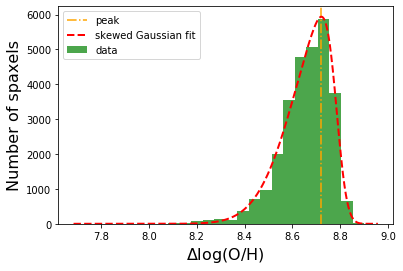

max is  8.960065590773912
min is  7.664917735908686
mean =  8.561558558507688
expected Z is 8.76
stellar mass range =  [ 9.5 10. ] 
surface mass density =  8.200000000000001 
expected metallicity =  8.756532179258514


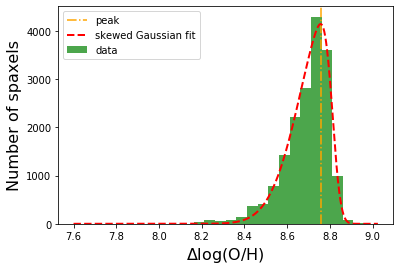

max is  8.962381378998558
min is  7.8820768116387505
mean =  8.569543354504082
expected Z is 8.78
stellar mass range =  [ 9.5 10. ] 
surface mass density =  8.400000000000002 
expected metallicity =  8.782746576626241


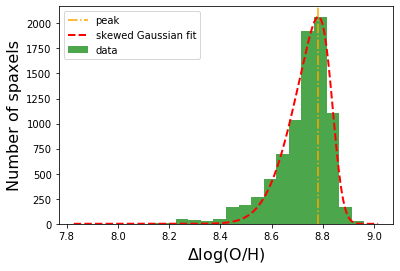

max is  8.9841583660406
min is  8.22974199371395
mean =  8.606950179877277
expected Z is 8.81
stellar mass range =  [ 9.5 10. ] 
surface mass density =  8.600000000000001 
expected metallicity =  8.808003388013832


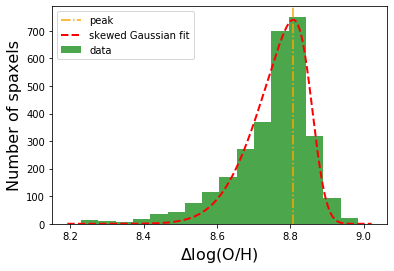

max is  8.99541960999454
min is  8.377936905596203
mean =  8.734176927364473
expected Z is 8.80
stellar mass range =  [ 9.5 10. ] 
surface mass density =  8.8 
expected metallicity =  8.800019280049346


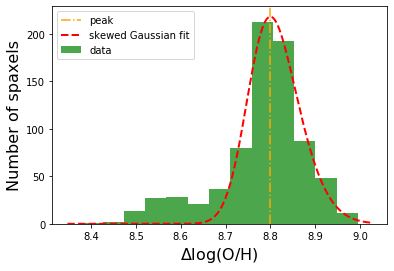

max is  8.998057906988553
min is  8.50028869954329
mean =  8.781172752315975
expected Z is 8.83
stellar mass range =  [ 9.5 10. ] 
surface mass density =  9.000000000000002 
expected metallicity =  8.831121776196815


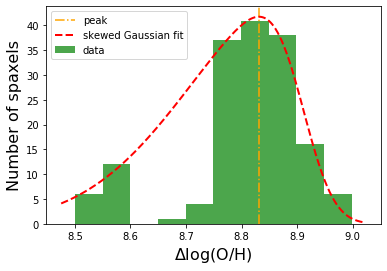

max is  8.976714729449514
min is  8.586362836606101
mean =  8.854729762935946
expected Z is 8.85
stellar mass range =  [ 9.5 10. ] 
surface mass density =  9.200000000000003 
expected metallicity =  8.854729762935946


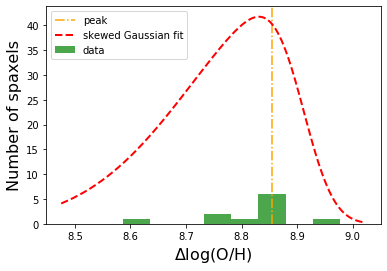

max is  8.815251184407273
min is  8.088832604729497
mean =  8.500469799880237
expected Z is 8.59
stellar mass range =  [10. 12.] 
surface mass density =  6.8 
expected metallicity =  8.591771585059758


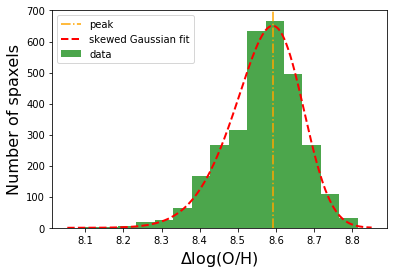

max is  8.839489227761808
min is  8.043659958990915
mean =  8.491313922674541
expected Z is 8.59
stellar mass range =  [10. 12.] 
surface mass density =  7.0 
expected metallicity =  8.592817174432657


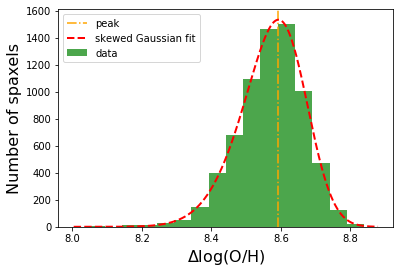

max is  8.922244311467942
min is  8.060954640181638
mean =  8.539448902007361
expected Z is 8.62
stellar mass range =  [10. 12.] 
surface mass density =  7.2 
expected metallicity =  8.620413921161834


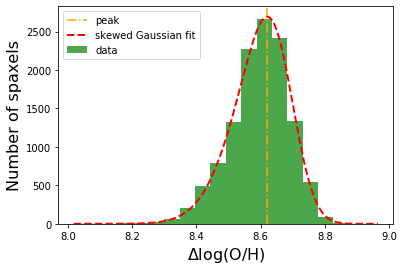

max is  8.901107765481331
min is  7.706656629633083
mean =  8.527841785528754
expected Z is 8.64
stellar mass range =  [10. 12.] 
surface mass density =  7.4 
expected metallicity =  8.640470380667798


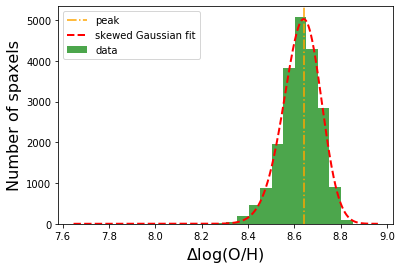

max is  9.019336547225613
min is  7.891802600520083
mean =  8.553616004021155
expected Z is 8.68
stellar mass range =  [10. 12.] 
surface mass density =  7.6000000000000005 
expected metallicity =  8.67506036800876


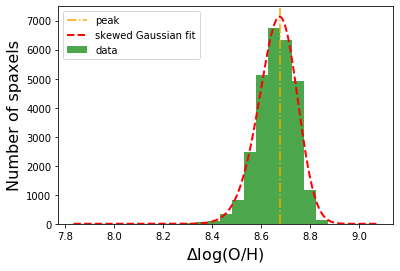

max is  9.033965700994576
min is  7.880678681605542
mean =  8.59224198683756
expected Z is 8.73
stellar mass range =  [10. 12.] 
surface mass density =  7.800000000000001 
expected metallicity =  8.725597813137036


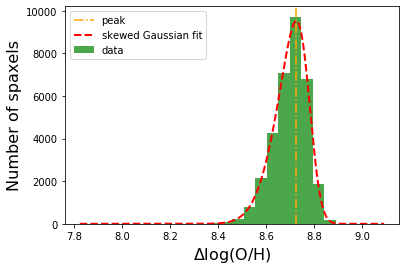

max is  8.973618143204883
min is  7.8775154037882915
mean =  8.633161989295184
expected Z is 8.76
stellar mass range =  [10. 12.] 
surface mass density =  8.0 
expected metallicity =  8.757954804431883


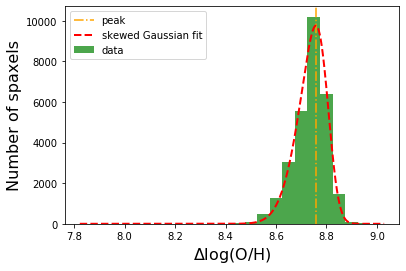

max is  9.04481033182784
min is  7.737654921438305
mean =  8.705918188393516
expected Z is 8.78
stellar mass range =  [10. 12.] 
surface mass density =  8.200000000000001 
expected metallicity =  8.782444540160546


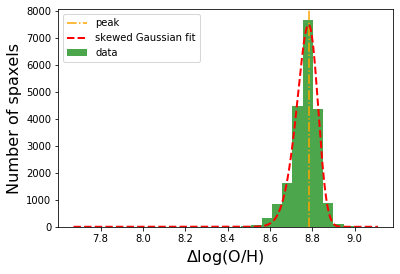

max is  9.091319820299699
min is  7.780407977371374
mean =  8.775729932187323
expected Z is 8.81
stellar mass range =  [10. 12.] 
surface mass density =  8.400000000000002 
expected metallicity =  8.805125700135642


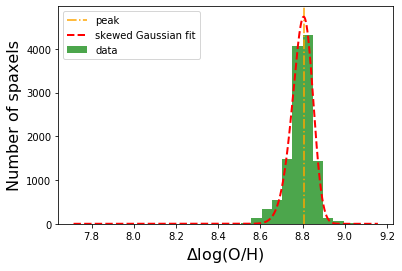

max is  9.101639270939566
min is  7.996554034422168
mean =  8.813356165761116
expected Z is 8.83
stellar mass range =  [10. 12.] 
surface mass density =  8.600000000000001 
expected metallicity =  8.833391682999451


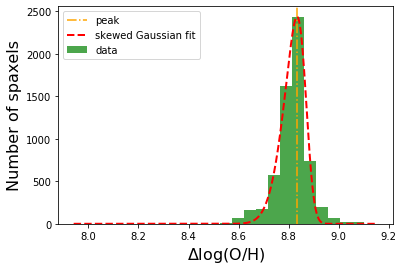

max is  9.094079865132633
min is  8.606822610502302
mean =  8.850451237817467
expected Z is 8.84
stellar mass range =  [10. 12.] 
surface mass density =  8.8 
expected metallicity =  8.837398747003112


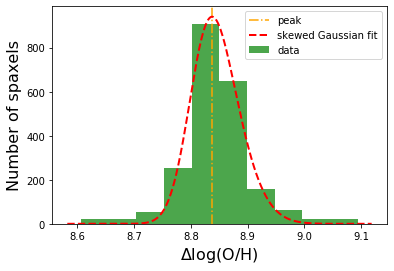

max is  9.098759857054072
min is  8.639622495797331
mean =  8.895495921081034
expected Z is 8.85
stellar mass range =  [10. 12.] 
surface mass density =  9.000000000000002 
expected metallicity =  8.845678696594566


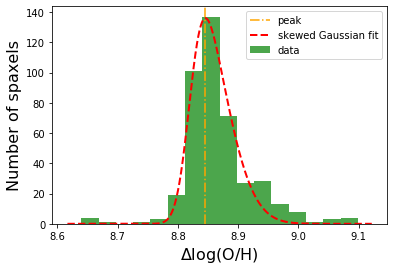

max is  8.996183435895448
min is  8.789780883685001
mean =  8.863496080903017
expected Z is 8.88
stellar mass range =  [10. 12.] 
surface mass density =  9.200000000000003 
expected metallicity =  8.875804653657418


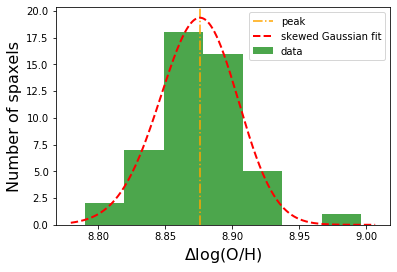

In [4]:
# 选择样本种类 Firefly或者PIPE3D
data_style = 'Firefly'# 'Firefly' #'PIPE3D'

# 按照 星系质量stellar mass分组
# 8.5-9，9-9.5，9.5-10，10-12
range_mass = np.array([[8.5,9],[9,9.5],[9.5,10],[10,12]])
# range_mass = np.array([[9.5,10.]])
# 初始化 预期金属丰度的数据点
expeted_data = np.ones([20*4,2])*np.nan
i_mass = 0
# j_density = 0
#def _expected_Z(mass_range):
for i in range_mass:
    idspaxel = (mass_spaxel>=i[0])&(mass_spaxel<i[1])
    tmp_density = sel_manga_Z['dep_surface_mass_density'].values[idspaxel]
    tmp_Z = sel_manga_Z['metallicity_pyqz'].values[idspaxel]
    #tmp_Z = Znew[idspaxel[:,0]]
    j_density=0
    #for j in np.arange(9.2,np.max(tmp_density[~np.isnan(tmp_density)]),0.2):
    for j in np.arange(6.8,np.max(tmp_density[~np.isnan(tmp_density)]),0.2):#9.5,0.2):
        if (i==np.array([ 9.5,10.])).all()&(j>=9.3):
            iddensity = (tmp_density>=j-0.4)&(tmp_density<=j+0.4)
        else:
            iddensity = (tmp_density>=j-0.1)&(tmp_density<=j+0.1)
        fix_density = tmp_density[iddensity]
        fix_Z = tmp_Z[iddensity]
        fix_density = fix_density[~np.isnan(fix_Z)]
        fix_Z = fix_Z[~np.isnan(fix_Z)]
        #print("fix_Z = ",fix_Z)
        print("max is ",np.max(fix_Z))
        print("min is ",np.min(fix_Z))
        if fix_Z.size==0:
            j_density+=1
            continue
        # 金属丰度分布
        #hist,bins,__ = plt.hist(tmp_Znew,bins=100,label='data',normed=1)#,normed=1
        if (i==np.array([ 10,12])).all()&(j >=9.):
            delta_bins = 0.03
        elif (i==np.array([ 9.0,9.5 ])).all()&(j>=8.7):#&(j<8.9):
            delta_bins = 0.06
            print("delta_bins = ", delta_bins)
        else:
            delta_bins = 0.05
        hist,bins,__ = plt.hist(fix_Z,bins=int(((np.max(fix_Z)-np.min(fix_Z))/delta_bins)+1),alpha=0.7, color='g',label='data');
        #hist,bins = np.histogram(fix_Z,bins=int((np.max(fix_Z)-np.min(fix_Z))/0.03+1));
        if len(hist)==1:
            j_density+=1
            continue
        # 预期金属丰度
        #modeZ = (bins[np.where(hist==np.max(hist))]+(bins[1]-bins[0])/2)[0]
        #expeted_data[i_mass*20+j_density,0] = j
        #expeted_data[i_mass*20+j_density,1] = expcted_Z
        #num_Z = hist[np.where(hist==np.max(hist))][0]
        #plt.axvline(expcted_Z,color='orange',linestyle='-.',label='mode');
        
        # 高斯分布拟合
        #mu =np.mean(fix_Z) #计算均值 
        #sigma =np.std(fix_Z)
        #y = mlab.normpdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y 
        #plt.plot(bins, y, 'r--',label='Gaussian fit') #绘制y的曲线
        #plt.legend(loc='best')
        #plt.title('Metallicity distribution',fontsize=18)
        #plt.xlabel('Metallicity',fontsize=16)
        #plt.ylabel('Number of spaxels',fontsize=16)
        #plt.show()
        
        x = bins[1:]-(bins[1]-bins[0])/2
        y = hist
        # 去除无用数据
        x = x[np.where(y!=0)]
        y = y[np.where(y!=0)]
        x = x[np.where(y!=1)]
        y = y[np.where(y!=1)]
        if (i==np.array([ 10,12])).all()&(j >=9.):
            pass
        else:
            x = x[np.where(y>5)]
            y = y[np.where(y>5)]
        n = len(x)                          #the number of data
        mean = sum(x)/n                   #note this correction
        print("mean = ",mean)
        sigma = (sum((x-mean)**2)/n)**0.5        #note this correction
        
        a = np.max(y)
        #popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
        try:
            popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
            #popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])
            # popt,pcov = curve_fit(gaus,x,y)
            # plt.plot(x,y,'b+:',label='data')
            xmin,xmax = plt.xlim()
            newxx = np.linspace(xmin,xmax,10000)
            newx = np.linspace(xmin,xmax,10000)
            # 预期金属丰度，skewed Gaussian fit中的peak值
            newy = gaus_plus(newx,*popt)
            newyy = gaus_plus(newxx,*popt)
            expcted_Z = newx[np.where(newy==newy.max())[0]][0]
        except:
            expcted_Z = x[np.where(y==a)][0]
            pass
        # 存储expected metallicity
        expeted_data[i_mass*20+j_density,0] = j
        expeted_data[i_mass*20+j_density,1] = expcted_Z
        # 修正绿色的点
        if (8.4<j<8.6)&(i==np.array([ 9.0,9.5 ])).all():
            j = 8.5
            j_density+=1
            iddensity = (tmp_density>=j-0.1)&(tmp_density<=j+0.1)
            fix_density = tmp_density[iddensity]
            fix_Z = tmp_Z[iddensity]
            fix_density = fix_density[~np.isnan(fix_Z)]
            fix_Z = fix_Z[~np.isnan(fix_Z)]
            delta_bins = 0.05
            hist,bins,__ = plt.hist(fix_Z,bins=int(((np.max(fix_Z)-np.min(fix_Z))/delta_bins)+1),alpha=0.7, color='g',label='data');
            x = bins[1:]-(bins[1]-bins[0])/2
            y = hist
            # 去除无用数据
            x = x[np.where(y>5)]
            y = y[np.where(y>5)]
            n = len(x)                          #the number of data
            mean = sum(x)/n                   #note this correction
            print("mean = ",mean)
            sigma = (sum((x-mean)**2)/n)**0.5        #note this correction
            a = np.max(y)
            popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
            xmin,xmax = plt.xlim()
            newxx = np.linspace(xmin,xmax,10000)
            newx = np.linspace(xmin,xmax,10000)
            # 预期金属丰度，skewed Gaussian fit中的peak值
            newy = gaus_plus(newx,*popt)
            newyy = gaus_plus(newxx,*popt)
            expcted_Z = newx[np.where(newy==newy.max())[0]][0]
            expeted_data[i_mass*20+j_density,0] = j
            expeted_data[i_mass*20+j_density,1] = expcted_Z
            plt.axvline(expcted_Z,color='orange',linestyle='-.',label='peak');
            plt.show()
            print("expected Z is %.2f" % expcted_Z)
        else:
            pass
        plt.axvline(expcted_Z,color='orange',linestyle='-.',label='peak');
        print("expected Z is %.2f" % expcted_Z)
        newxxx = (newxx - expeted_data[i_mass*20+j_density,1]).copy()
        #plt.show()
        plt.plot(newxx,newyy, 'r--', linewidth=2,label='skewed Gaussian fit')
        
        # 检查错误
        print('stellar mass range = ',i,'\nsurface mass density = ',j,'\nexpected metallicity = ',expcted_Z,)
        #print('x = ',list(x))
        #print('y = ',list(y))
        #plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')
        #plt.plot(x,gaus(x,*popt),'ro:',label='Gaussian fit')
        
        # 画图调整
        plt.legend(loc='best')
        ##plt.title('Metallicity distribution',fontsize=18)
        #plt.xlabel('Metallicity',fontsize=16)
        plt.xlabel('$\Delta$log(O/H)',fontsize=16)
        plt.ylabel('Number of spaxels',fontsize=16)
        #plt.xlim([-0.5,0.5])
        plt.show()
        # np.histogram
        j_density+=1
    i_mass+=1

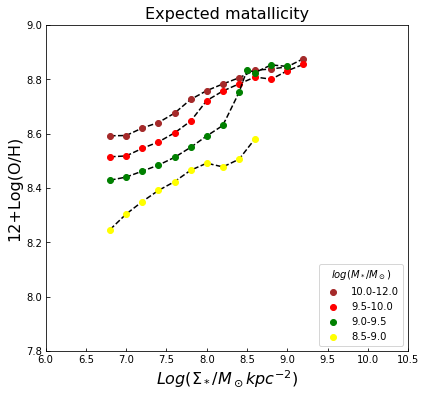

In [5]:
from scipy import interpolate
from scipy.interpolate import griddata
# expected metallicity plot
kind = 'linear'#'linear'# 'cubic'# interpolation method 
a = expeted_data[::-1].copy()# 倒序排列数组
i = 0# 循环计数
plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    x = a[20*i:20*i+20,0]
    y = a[20*i:20*i+20,1]
    
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    f=interpolate.interp1d(x[~np.isnan(x)],y[~np.isnan(y)],fill_value="extrapolate",kind=kind)# 使用插值函数
    xnew = np.linspace(x[~np.isnan(x)].min(),x[~np.isnan(x)].max(),50)
    ynew=f(xnew)# 得到插值结果
    plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
    plt.plot(x,y,'o',color=c,label=label)
    i+=1



plt.title("Expected matallicity",fontsize=16)
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
plt.legend(loc='lower right',title='$log(M_*/M_\odot)$')
plt.xlim([6,10.5])
plt.ylim([7.8,9])
plt.show()

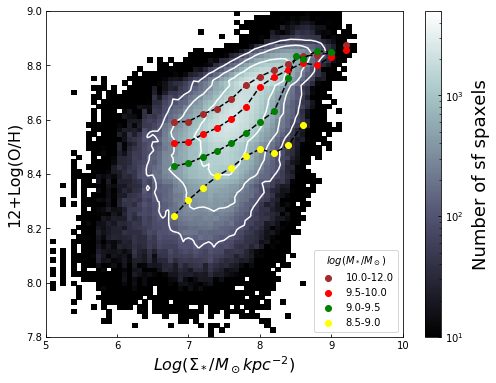

In [8]:
# 加入等高线 contour

y = manga_Z['metallicity_pyqz'].copy()
# x = spaxel_density# PIPE3D surface mass density
x = manga_Z['dep_surface_mass_density']
# x = firefly_spaxel_density.copy()# firefly surface mass density
fig = plt.figure(figsize=(8,6))    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置

# hist2d画图
nhist,xbins,ybins,cax = ax1.hist2d(x,y,bins=(70,70),# 分组个数
                                  range=[[5,10],[7.8,9]],# 坐标轴范围
                                  cmap='bone',norm= mpl.colors.LogNorm(),vmin=10**1,vmax=10**3.7)# colorbar样式

plt.contour(xbins[1:],ybins[1:],nhist.transpose(),[10**2,10**2.5,10**3],colors='white',norm= mpl.colors.LogNorm(),linewidth=0.5,vmin=0.1,vmax=3800)
# ax1.set_aspect(1)    # 1：1图的大小
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of sf spaxels",fontsize=18,labelpad=8)
# plt.title('with intrinsic extinction correction',fontsize=16)
# expected metallicity plot
kind = 'linear'#'linear'# 'cubic'# interpolation method 
a = expeted_data[::-1].copy()# 倒序排列数组
i = 0# 循环计数
# plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    x = a[20*i:20*i+20,0]
    y = a[20*i:20*i+20,1]
    
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    f=interpolate.interp1d(x[~np.isnan(x)],y[~np.isnan(y)],fill_value="extrapolate",kind=kind)# 使用插值函数
    xnew = np.linspace(x[~np.isnan(x)].min(),x[~np.isnan(x)].max(),50)
    ynew=f(xnew)# 得到插值结果
    plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
    plt.plot(x,y,'o',color=c,label=label)
    i+=1



plt.tick_params(which='both',direction='in')
plt.legend(loc='lower right',title='$log(M_*/M_\odot)$')

plt.show()

In [38]:
# 计算每个spaxel的预期金属丰度
# 得到 number of spaxels - metallicity deviation图
# 再加上高斯分布的拟合，对比二者得到ALM区域的标准

'''
1. 求出 expected metallicity
2. obs - exp 求出偏差
3. 得到 金属丰度偏差 的分布直方图
'''
# from scipy import interpolate
# from scipy.optimize import curve_fit
# from scipy import asarray as ar,exp

# 读取数据
sel_mass_spaxel = mass_spaxel[~np.isnan(sel_manga_Z['metallicity_pyqz'].values)]
sel_manga_Z = sel_manga_Z[~np.isnan(sel_manga_Z['metallicity_pyqz'].values)]
sel_density = sel_manga_Z['dep_surface_mass_density'].values.copy()
sel_Znew = sel_manga_Z['metallicity_pyqz'].values.copy()
den_Z = expeted_data[::-1].copy()# 待插值的 密度，金属丰度 数据点

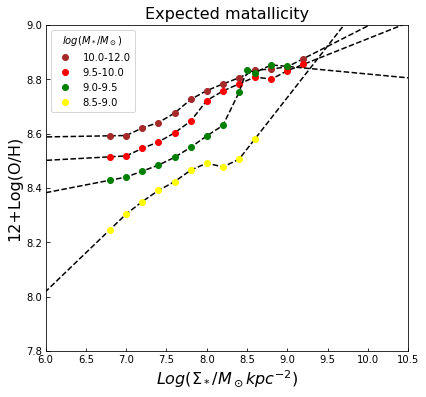

In [39]:
# 插值方法
kind = 'linear'#'linear'# 'cubic'# interpolation method 

range_mass = np.array([[8.5,9.],[9.,9.5],[9.5,10.],[10,12]])
for_mass = range_mass[::-1]

# 初始化 预期金属丰度 数组
Z_exp = np.ones([sel_Znew.size,1])*np.nan
Z_dev = np.ones([sel_Znew.size,1])*np.nan
i = 0# 循环计数变量
plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    x = den_Z[20*i:20*i+20,0]
    y = den_Z[20*i:20*i+20,1]
    ## 去除不想要的黄色点
    #if c=='yellow0':
    #    x[np.where(x>8.7)[0]]=np.nan
    #    y[np.where(x>8.7)[0]]=np.nan
    ## 去除不想要的绿色点
    #if c=='green':
    #    x[np.where(x>8.5)[0]]=np.nan
    #    y[np.where(x>8.5)[0]]=np.nan
    ## 去除不想要的红色点
    #if c=='red':
    #    x[np.where(x>8.9)[0]]=np.nan
    #    y[np.where(x>8.7)[0]]=np.nan
    ## 去除不想要的褐色点
    #if c=='brown0':
    #    x[np.where(x>8.7)[0]]=np.nan
    #    y[np.where(x>8.7)[0]]=np.nan
    #
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    lala = (~np.isnan(x))&(~np.isnan(y))
    f=interpolate.interp1d(x[lala],y[lala],fill_value="extrapolate",kind=kind)# 使用插值函数
    #xnew = np.linspace(7,x[~np.isnan(x)].max(),50)
    xnew = np.linspace(4.8,11.4,100)
    ynew=f(xnew)# 得到插值结果
    plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
    plt.plot(x,y,'o',color=c,label=label)
    
    # 获取每个spaxel的预期金属丰度
    ii = for_mass[i]
    idspaxel = (sel_mass_spaxel>=ii[0])&(sel_mass_spaxel<ii[1])
    #print("idspaxel = \n",idspaxel.shape)
    #print("Z_exp = \n",Z_exp.shape)
    #print("sel_density = \n",sel_density.shape)
    Z_exp[idspaxel,0] = f(sel_density[idspaxel])
    Z_dev[idspaxel,0] = sel_Znew[idspaxel] - Z_exp[idspaxel,0]
    i+=1

plt.title("Expected matallicity",fontsize=16)
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
plt.legend(loc='best',title='$log(M_*/M_\odot)$')#loc='lower right'
plt.xlim([6,10.5])
plt.ylim([7.8,9])
plt.show()

In [40]:
print(Z_exp.shape)
print(Z_dev.shape)
print(Z_exp.max())
print(Z_dev.max())
print(sel_mass_spaxel.shape)
print(sel_mass_spaxel.min())
print(sel_mass_spaxel.max())

(641500, 1)
(641500, 1)
8.891923301089983
0.5812694693660827
(641500,)
8.507048574935917
11.091677507131081


In [45]:
Z_exp.shape

(641500, 1)

In [48]:
'''数据转移备份 | 数据存储'''
sel_spaxel = sel_manga_Z
# save sel_spaxel
tmp_data = {'plate-ifu':sel_spaxel['plate-ifu'],
            'array_id':sel_spaxel['array_id'],
            'bin_id_2800':sel_spaxel['bin_id_2800'],
            'spaxel_x':sel_spaxel['spaxel_x'],
            'spaxel_y':sel_spaxel['spaxel_y'],
            'metallicity_pyqz':sel_spaxel['metallicity_pyqz'],
            'metallicity_expected':Z_exp[:,0],
            'metallicity_deviation':Z_dev[:,0],
            'surface_mass_density_VOR':sel_spaxel['surface_mass_density_VOR'],
            'dep_surface_mass_density':sel_spaxel['dep_surface_mass_density'],
            'stellar_mass_global':sel_mass_spaxel[:,np.newaxis][:,0],
            'flux_ha':sel_spaxel['flux_ha'],
            'flux_hb':sel_spaxel['flux_hb'],
            'flux_nii':sel_spaxel['flux_nii'],
            'flux_oii7':sel_spaxel['flux_oii7'],
            'flux_oii9':sel_spaxel['flux_oii9'],
            'flux_oiii':sel_spaxel['flux_oiii']
           }
# 转换为 pandas 数组， dataframe类型
df = pd.DataFrame(tmp_data,columns=['plate-ifu','array_id','bin_id_2800','spaxel_x','spaxel_y',\
                                    'metallicity_pyqz','metallicity_expected','metallicity_deviation',\
                                    'surface_mass_density_VOR','dep_surface_mass_density',\
                                    'stellar_mass_global',\
                                    'flux_ha','flux_hb','flux_nii','flux_oii7','flux_oii9','flux_oiii'])
df
# pandas 导出为压缩的 序列化 数据
# df.to_pickle("./tmp_storage/MaNGA_exp_metal_spaxel.v3.0.pd.pkl")

In [ ]:
#***********************************************************************************************************#
'''警告！！！⚠ 重大bug！！！
将下列的一维数组减去二维数组，会导致卡死，CPU占用率100%
原因：numpy用C语言写成，不受python的GIL锁限制【https://www.jianshu.com/p/d0e634840b14】
下面的数组虽然是64万长度的两个数组进行加减运算，但是一个是一维数组，一个是二维数组，因此在运算时，会比同等shape的情况更加消耗内存和CPU
也就是说，numpy会自动多线程，若想限制其多线程，可以在 import numpy之前，在终端运行：
export MKL_NUM_THREADS=1
export NUMEXPR_NUM_THREADS=1
export OMP_NUM_THREADS=1
'''
# Z_dev = sel_Znew - Z_exp
#***********************************************************************************************************#

'''同样的，对于一个超级大的多维数组，例如 100000*100000   
使用最慢的for 循环，使用 np.where 对其进行索引，会消耗大量内存   
'''   
````
lalala = np.ones((10**5,10**5))
for i in range(lalala.size):
    tmp_id = np.where(lalala==7)
    res = lalala[tmp_id]
```    
`请勿轻易尝试！！！`

In [24]:
np.where(sel_mass_spaxel>=8.5)

(array([     0,      1,      2, ..., 641520, 641521, 641522]),)

xx =  [0.00250734 0.01220098 0.02189463 0.03158827 0.04128192 0.05097556
 0.0606692  0.07036285 0.08005649 0.08975014 0.09944378 0.10913743
 0.11883107 0.12852471 0.13821836 0.147912   0.15760565 0.16729929
 0.17699293 0.18668658 0.19638022 0.20607387 0.21576751 0.22546116
 0.2351548  0.24484844 0.25454209 0.26423573 0.27392938 0.28362302
 0.29331667 0.30301031 0.31270395 0.3223976  0.33209124 0.34178489
 0.35147853] 
yy =  [2.5172e+04 2.4698e+04 2.3137e+04 2.1738e+04 1.9731e+04 1.7747e+04
 1.5588e+04 1.3639e+04 1.1862e+04 9.8260e+03 8.4690e+03 7.1970e+03
 5.9600e+03 4.9920e+03 4.0290e+03 3.2210e+03 2.6450e+03 2.0420e+03
 1.5720e+03 1.1720e+03 9.1300e+02 6.4500e+02 4.6800e+02 3.5600e+02
 2.4100e+02 1.8900e+02 1.1600e+02 9.1000e+01 6.0000e+01 4.7000e+01
 3.0000e+01 2.1000e+01 1.3000e+01 1.0000e+01 3.0000e+00 2.0000e+00
 3.0000e+00]


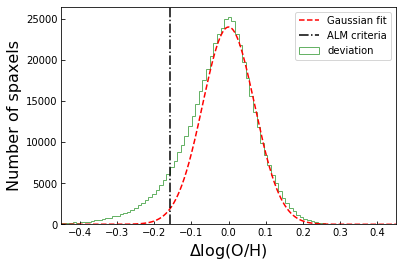

In [10]:
# 金属丰度偏差
ZZ_exp = Z_exp[:,0]
Z_dev = sel_Znew - ZZ_exp
sel_density = sel_manga_Z['dep_surface_mass_density'].values.copy()

# 筛选出 星系质量>10^9Msun 的spaxels
cc = np.where(sel_mass_spaxel>=9.0)[0]# 挑选出星系质量>10^9Msun 的spaxels
sel_density = sel_density[cc]
Z_dev = Z_dev[cc]
ZZ_exp = ZZ_exp[cc]
dd = np.where(sel_density>7)[0]# 挑选出surface mass density>10^7的spaxels
sel_Z_dev = Z_dev[dd]
ZZ_exp = ZZ_exp[dd]
sel_density = sel_density[dd]

# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation');
plt.xlim([-0.45,0.45])
###################################################################################
# 高斯拟合
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

xx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
yy = hist.copy()# 数量
yy = yy[np.where(xx>0.)]
xx = xx[np.where(xx>0.)]
print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差

popt,pcov = curve_fit(gaus,x,y,p0=[y.max(),mean,sigma])# 开始拟合
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')# 画图
###########################################################################

# ALM 标准
y_exp = gaus(x,*popt)
delta_y = y - y_exp
delta_y = delta_y[np.where(x<-0.1)]
x = x[np.where(x<-0.1)]
ALM = x[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.show()

xx =  [0.00250734 0.01220098 0.02189463 0.03158827 0.04128192 0.05097556
 0.0606692  0.07036285 0.08005649 0.08975014 0.09944378 0.10913743
 0.11883107 0.12852471 0.13821836 0.147912   0.15760565 0.16729929
 0.17699293 0.18668658 0.19638022 0.20607387 0.21576751 0.22546116
 0.2351548  0.24484844 0.25454209 0.26423573 0.27392938 0.28362302
 0.29331667 0.30301031 0.31270395 0.3223976  0.33209124 0.34178489
 0.35147853] 
yy =  [2.5172e+04 2.4698e+04 2.3137e+04 2.1738e+04 1.9731e+04 1.7747e+04
 1.5588e+04 1.3639e+04 1.1862e+04 9.8260e+03 8.4690e+03 7.1970e+03
 5.9600e+03 4.9920e+03 4.0290e+03 3.2210e+03 2.6450e+03 2.0420e+03
 1.5720e+03 1.1720e+03 9.1300e+02 6.4500e+02 4.6800e+02 3.5600e+02
 2.4100e+02 1.8900e+02 1.1600e+02 9.1000e+01 6.0000e+01 4.7000e+01
 3.0000e+01 2.1000e+01 1.3000e+01 1.0000e+01 3.0000e+00 2.0000e+00
 3.0000e+00]


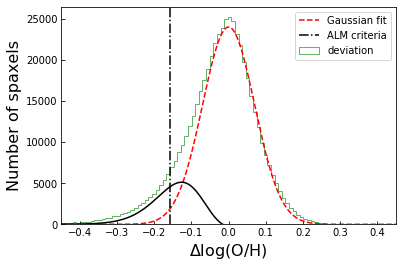

In [11]:
# 在上图中添加 黑色的 剩余值 曲线
# 金属丰度偏差
ZZ_exp = Z_exp[:,0]
Z_dev = sel_Znew - ZZ_exp
sel_density = sel_manga_Z['dep_surface_mass_density'].values.copy()

# 筛选出 星系质量>10^9Msun 的spaxels
cc = np.where(sel_mass_spaxel>=9.0)[0]# 挑选出星系质量>10^9Msun 的spaxels
sel_density = sel_density[cc]
Z_dev = Z_dev[cc]
ZZ_exp = ZZ_exp[cc]
dd = np.where(sel_density>7)[0]# 挑选出surface mass density>10^7的spaxels
sel_Z_dev = Z_dev[dd]
ZZ_exp = ZZ_exp[dd]
sel_density = sel_density[dd]

# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation');
plt.xlim([-0.45,0.45])
###################################################################################
# 高斯拟合【正态分布拟合】
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result
xx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
yy = hist.copy()# 数量
res_xx = xx.copy()
res_yy = yy.copy()
yy = yy[np.where(xx>0.)]
xx = xx[np.where(xx>0.)]
print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差
a = y.max()
popt,pcov = curve_fit(gaus,x,y,p0=[a,mean,sigma])# 开始拟合
popt2,pcov2 = curve_fit(gaus_plus,res_xx,res_yy,p0=[a,mean,sigma,0])

xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
newxx = np.linspace(xmin,xmax,1000)
newy = gaus(newx,*popt)
newyy = gaus_plus(newxx,*popt2)
plt.plot(newx,newy,'r--',label='Gaussian fit')# 画图
###########################################################################

# ALM 标准
y_exp = gaus(x,*popt)
delta_y = y - y_exp
delta_y = delta_y[np.where(x<-0.1)]
x = x[np.where(x<-0.1)]
ALM = x[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')

# 残余项
res_x = newxx
res_y = newyy - newy
res_x = res_x[res_y>=0]
res_y = res_y[res_y>=0]
res_y = res_y[res_x<=0]
res_x = res_x[res_x<=0]

plt.plot(res_x,res_y,'k-')# 画图

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.show()

In [124]:
Z_dev.shape

(584983,)

xx =  [0.00250734 0.01220098 0.02189463 0.03158827 0.04128192 0.05097556
 0.0606692  0.07036285 0.08005649 0.08975014 0.09944378 0.10913743
 0.11883107 0.12852471 0.13821836 0.147912   0.15760565 0.16729929
 0.17699293 0.18668658 0.19638022 0.20607387 0.21576751 0.22546116
 0.2351548  0.24484844 0.25454209 0.26423573 0.27392938 0.28362302
 0.29331667 0.30301031 0.31270395 0.3223976  0.33209124 0.34178489
 0.35147853] 
yy =  [2.5172e+04 2.4698e+04 2.3137e+04 2.1738e+04 1.9731e+04 1.7747e+04
 1.5588e+04 1.3639e+04 1.1862e+04 9.8260e+03 8.4690e+03 7.1970e+03
 5.9600e+03 4.9920e+03 4.0290e+03 3.2210e+03 2.6450e+03 2.0420e+03
 1.5720e+03 1.1720e+03 9.1300e+02 6.4500e+02 4.6800e+02 3.5600e+02
 2.4100e+02 1.8900e+02 1.1600e+02 9.1000e+01 6.0000e+01 4.7000e+01
 3.0000e+01 2.1000e+01 1.3000e+01 1.0000e+01 3.0000e+00 2.0000e+00
 3.0000e+00]


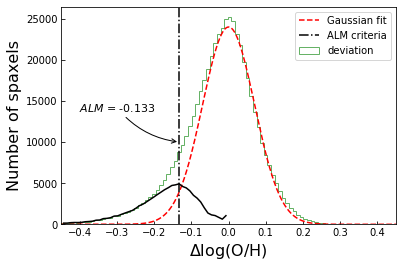

In [12]:
# 在上图中添加 黑色的 剩余值 曲线
# 金属丰度偏差
ZZ_exp = copy(Z_exp[:,0])
Z_dev = sel_Znew - ZZ_exp
sel_density = sel_manga_Z['dep_surface_mass_density'].values.copy()

# 筛选出 星系质量>10^9Msun 的spaxels
cc = np.where(sel_mass_spaxel>=9.0)[0]# 挑选出星系质量>10^9Msun 的spaxels
sel_density = sel_density[cc]
Z_dev = Z_dev[cc]
ZZ_exp = ZZ_exp[cc]
dd = np.where(sel_density>7)[0]# 挑选出surface mass density>10^7的spaxels
sel_Z_dev = Z_dev[dd]
ZZ_exp = ZZ_exp[dd]
sel_density = sel_density[dd]

# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation');
plt.xlim([-0.45,0.45])
###################################################################################
# 高斯拟合【正态分布拟合】
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result
xx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
yy = hist.copy()# 数量
res_xx = xx.copy()
res_yy = yy.copy()
yy = yy[np.where(xx>0.)]
xx = xx[np.where(xx>0.)]
print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差
a = y.max()
popt,pcov = curve_fit(gaus,x,y,p0=[a,mean,sigma])# 开始拟合


xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
# newxx = np.linspace(xmin,xmax,len(res_xx))
newy = gaus(newx,*popt)
# newyy = gaus_plus(newxx,*popt2)
plt.plot(newx,newy,'r--',label='Gaussian fit')# 画图
###########################################################################

# 残余项
res_yy = res_yy[(res_xx>=xmin)&(res_xx<=xmax)]
res_xx = res_xx[(res_xx>=xmin)&(res_xx<=xmax)]
newxx = np.linspace(res_xx.min(),res_xx.max(),len(res_xx))
newyy = gaus(newxx,*popt)

res_x = newxx
res_y = res_yy - newyy 
res_x = res_x[res_y>=0]
res_y = res_y[res_y>=0]
res_y = res_y[res_x<=0]
res_x = res_x[res_x<=0]

plt.plot(res_x,res_y,'k-')# 画图

# ALM 标准
ALM = res_x[np.where(res_y==res_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')
plt.annotate(r'$ALM$ = %.3f' % ALM, xy=(ALM, 10000), xycoords='data', xytext=(-100, +30),
             textcoords='offset points', fontsize=11,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
# plt.plot(newxx,newyy,'k--',label='Plus Gaussian fit')# 画图
plt.show()

In [92]:
'''数据转移备份 | 数据存储'''
sel_spaxel = sel_manga_Z
# save sel_spaxel
tmp_data = {'plate-ifu':sel_spaxel['plate-ifu'],
            'array_id':sel_spaxel['array_id'],
            'bin_id_2800':sel_spaxel['bin_id_2800'],
            'spaxel_x':sel_spaxel['spaxel_x'],
            'spaxel_y':sel_spaxel['spaxel_y'],
            'metallicity_pyqz':sel_spaxel['metallicity_pyqz'],
            'metallicity_expected':Z_exp[:,0],
            'surface_mass_density_VOR':sel_spaxel['surface_mass_density_VOR'],
            'dep_surface_mass_density':sel_spaxel['dep_surface_mass_density'],
            'flux_ha':sel_spaxel['flux_ha'],
            'flux_hb':sel_spaxel['flux_hb'],
            'flux_nii':sel_spaxel['flux_nii'],
            'flux_oii7':sel_spaxel['flux_oii7'],
            'flux_oii9':sel_spaxel['flux_oii9'],
            'flux_oiii':sel_spaxel['flux_oiii']
           }
# 转换为 pandas 数组， dataframe类型
df = pd.DataFrame(tmp_data,columns=['plate-ifu','array_id','bin_id_2800','spaxel_x','spaxel_y',\
                                    'metallicity_pyqz','metallicity_expected','surface_mass_density_VOR','dep_surface_mass_density',\
                                    'flux_ha','flux_hb','flux_nii','flux_oii7','flux_oii9','flux_oiii'])
# df
# pandas 导出为压缩的 序列化 数据
# df.to_pickle("./tmp_storage/MaNGA_exp_metal_spaxel.v3.0.pd.pkl")

In [2]:
import time  # estimate running time
from copy import copy as copy  # avoid to change the value of pointer
import warnings  # shut down the annoying messages
from os.path import join  # stick different variables together
from multiprocessing import Pool  # multi-running!!!
from functools import partial  # convert to single parameter function

import math  # just for some specific calculate
import numpy as np  # array
import pandas as pd  # more powerful array
import matplotlib as mpl
import matplotlib.pyplot as plt  # plot

from astropy.io import fits    # read fits file

from marvin.tools import Maps  # use Marvin to get BPT, flux, image etc.

warnings.filterwarnings('ignore')  # ignore Warnings

In [27]:
# 特定星系的 金属丰度分布
# 特定星系的 金属丰度偏差 分布
# 检测是否和论文的星系区域一致

# read whole data
manga_Z = pd.read_pickle("./tmp_storage/MaNGA_exp_metal_spaxel.v3.0.pd.pkl")
# copy in case of facing errors in multi-running
sel_spaxels = copy(manga_Z)
# path of Marvin's HYB10 data, to get flux etc.
path_marvin_data = '../../bak_la/root/bash_file/manga_maps_data'

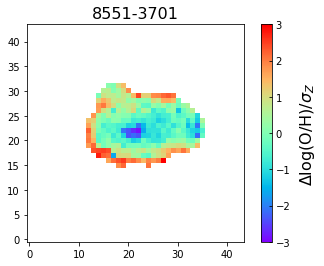

In [91]:
plateifu = '8551-3701'#'8551-3701'#'8945-12705'#'8252-9102'#'8945-12705'
tmp_id = (sel_spaxels['plate-ifu'].values==plateifu)
temp_manga = sel_spaxels[tmp_id]
spaxel_x = temp_manga['spaxel_x'].values.astype(int)
spaxel_y = temp_manga['spaxel_y'].values.astype(int)
pyqz_Z = temp_manga['metallicity_pyqz'].values
exp_Z = temp_manga['metallicity_expected'].values
dev_Z = temp_manga['metallicity_deviation'].values#pyqz_Z - exp_Z
plt_dev_Z = dev_Z / 0.07  #np.abs(dev_Z / (-0.07))
ha_flux = temp_manga['flux_ha'].values

# prepare to plot
filename = join(path_marvin_data, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plateifu))
new_maps = Maps(filename=filename)
ha = new_maps.emline_gflux_ha_6564    # 获取Hα6564
image_sz = np.shape(ha)[0]    # 图像边长
maps = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
def _plt(x,y,ha):
    maps[y,x] = ha
    return None
[ _plt(x,y,z) for (x,y,z) in zip(spaxel_x,spaxel_y,plt_dev_Z)]#dev_Z/(-0.06))] #ha_flux)]
# start_time = time.time()
# pool = Pool(processes=2,maxtasksperchild=1000)

# zip_args = zip(spaxel_x, spaxel_y, dev_Z)
# tmp_test = pool.starmap(_plt, zip_args)


# pool.close()
# pool.join()
# end_time = time.time()
# print("used time is %.2f s" % (end_time-start_time))

# plot!!!
fig, ax = plt.subplots()

# p = ax.imshow(maps.T , origin='lower',cmap='jet',vmin=0.1,vmax=100)
p = ax.imshow(maps , cmap='rainbow',origin='lower',vmin=-3,vmax=3)#,norm=mpl.colors.LogNorm())
# fig.colorbar(p)
# colorbar调整
cbar = plt.colorbar(p)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
plt.title(plateifu,fontsize=16)
plt.show()
# ha.plot(cmap='jet',log_cb=True,cbrange=(0.01,5))
# plt.show()

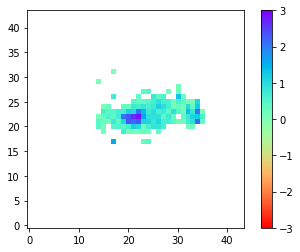

In [83]:
temp_manga['metallicity_deviation'].values

array([ 0.04843142,  0.06856319,  0.00893169, ...,  0.0101582 ,
       -0.01965986,  0.02998595])

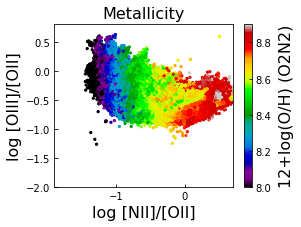

'with extinction correction'

In [68]:
'''检查导出为文件的 metallicity pyqz, expected, deviation 是否正确
'''
'''检查metallicity pyqz数据是否正确【完美！！！，无问题】
做出pyqz计算得到金属丰度的分布图
'''
# 金属丰度分布图.
# import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
# 设置colorbar颜色样式，可以在下面网站查询：
# https://matplotlib.org/tutorials/colors/colormaps.html
cm = plt.cm.get_cmap('nipy_spectral')
x = np.log10(manga_Z['flux_nii'].values/(manga_Z['flux_oii7'].values+manga_Z['flux_oii9'].values))
y = np.log10(manga_Z['flux_oiii'].values/(manga_Z['flux_oii7'].values+manga_Z['flux_oii9'].values))
z = manga_Z['metallicity_pyqz'].values
# 开始画散点图
sc = plt.scatter(x, y,c=z, vmin=8, vmax=8.9, s=5, cmap=cm)
# # 开始画grid格子
# for i in range(7):
#     xx=locals()['line'+str(i+1)+'x']
#     yy=locals()['line'+str(i+1)+'y']
#     plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# 坐标轴范围调整
plt.xlim(-1.9, 0.7)
plt.ylim(-2.0, 0.8)
# 坐标轴标题设置
plt.xlabel('log [NII]/[OII]',fontsize=16)    # x轴标签
plt.ylabel('log [OIII]/[OII]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("12+log(O/H) (O2N2)",fontsize=16,labelpad=8)
plt.title('Metallicity',fontsize=16)
plt.show()
'''with extinction correction'''

xx =  [0.00250734 0.01220098 0.02189463 0.03158827 0.04128192 0.05097556
 0.0606692  0.07036285 0.08005649 0.08975014 0.09944378 0.10913743
 0.11883107 0.12852471 0.13821836 0.147912   0.15760565 0.16729929
 0.17699293 0.18668658 0.19638022 0.20607387 0.21576751 0.22546116
 0.2351548  0.24484844 0.25454209 0.26423573 0.27392938 0.28362302
 0.29331667 0.30301031 0.31270395 0.3223976  0.33209124 0.34178489
 0.35147853] 
yy =  [2.5172e+04 2.4698e+04 2.3137e+04 2.1738e+04 1.9731e+04 1.7747e+04
 1.5588e+04 1.3639e+04 1.1862e+04 9.8260e+03 8.4690e+03 7.1970e+03
 5.9600e+03 4.9920e+03 4.0290e+03 3.2210e+03 2.6450e+03 2.0420e+03
 1.5720e+03 1.1720e+03 9.1300e+02 6.4500e+02 4.6800e+02 3.5600e+02
 2.4100e+02 1.8900e+02 1.1600e+02 9.1000e+01 6.0000e+01 4.7000e+01
 3.0000e+01 2.1000e+01 1.3000e+01 1.0000e+01 3.0000e+00 2.0000e+00
 3.0000e+00]


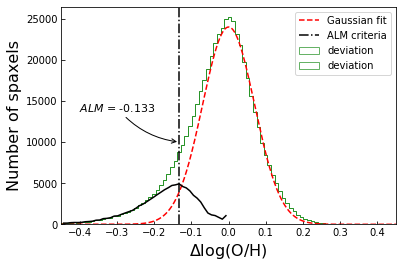

In [72]:
'''检查metallicity deviation 数据是否正确【完美！！！，无问题】
做出 金属丰度的偏差值 分布图
'''
# 金属丰度偏差
ZZ_exp = manga_Z['metallicity_expected'].values.copy()
Z_dev = manga_Z['metallicity_deviation'].values.copy()  #pyqz_Z - exp_Z

sel_density = manga_Z['dep_surface_mass_density'].values.copy()
sel_mass_spaxel = manga_Z['stellar_mass_global'].values.copy()

# 筛选出 星系质量>10^9Msun 的spaxels
cc = np.where(sel_mass_spaxel>=9.0)[0]# 挑选出星系质量>10^9Msun 的spaxels
sel_density = sel_density[cc]
Z_dev = Z_dev[cc]
ZZ_exp = ZZ_exp[cc]
dd = np.where(sel_density>7)[0]# 挑选出surface mass density>10^7的spaxels
sel_Z_dev = Z_dev[dd]
ZZ_exp = ZZ_exp[dd]
sel_density = sel_density[dd]

# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation')
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation')
plt.xlim([-0.45,0.45])
###################################################################################
# 高斯拟合【正态分布拟合】
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result
xx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
yy = hist.copy()# 数量
res_xx = xx.copy()
res_yy = yy.copy()
yy = yy[np.where(xx>0.)]
xx = xx[np.where(xx>0.)]
print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差
a = y.max()
popt,pcov = curve_fit(gaus,x,y,p0=[a,mean,sigma])# 开始拟合


xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
# newxx = np.linspace(xmin,xmax,len(res_xx))
newy = gaus(newx,*popt)
# newyy = gaus_plus(newxx,*popt2)
plt.plot(newx,newy,'r--',label='Gaussian fit')# 画图
###########################################################################

# 残余项
res_yy = res_yy[(res_xx>=xmin)&(res_xx<=xmax)]
res_xx = res_xx[(res_xx>=xmin)&(res_xx<=xmax)]
newxx = np.linspace(res_xx.min(),res_xx.max(),len(res_xx))
newyy = gaus(newxx,*popt)

res_x = newxx
res_y = res_yy - newyy 
res_x = res_x[res_y>=0]
res_y = res_y[res_y>=0]
res_y = res_y[res_x<=0]
res_x = res_x[res_x<=0]

plt.plot(res_x,res_y,'k-')# 画图

# ALM 标准
ALM = res_x[np.where(res_y==res_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')
plt.annotate(r'$ALM$ = %.3f' % ALM, xy=(ALM, 10000), xycoords='data', xytext=(-100, +30),
             textcoords='offset points', fontsize=11,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
# plt.plot(newxx,newyy,'k--',label='Plus Gaussian fit')# 画图
plt.show()


In [75]:
'''检查metallicity expected 数据是否正确【完美！！！，无问题】
将 pyqz - expcted ?= deviation
'''
ZZ_pyqz = manga_Z['metallicity_pyqz'].values.copy()
ZZ_exp = manga_Z['metallicity_expected'].values.copy()
ZZ_dev = manga_Z['metallicity_deviation'].values.copy()

test = (ZZ_pyqz - ZZ_exp - ZZ_dev)
print("test = ",test)
tmp_id = (test!=0)
if len(test[tmp_id])==0:
    print("perfect, everything is OK")
else:
    print("oops, something is bad T_T")

test =  [0. 0. 0. ... 0. 0. 0.]
perfect, everything is OK


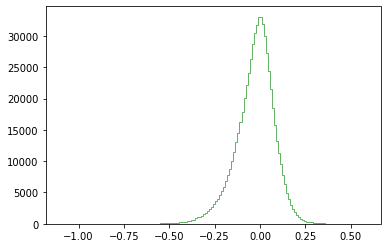

In [129]:

temp_manga = sel_spaxels
spaxel_x = temp_manga['spaxel_x'].values.astype(int)
spaxel_y = temp_manga['spaxel_y'].values.astype(int)
pyqz_Z = temp_manga['metallicity_pyqz'].values
exp_Z = temp_manga['metallicity_expected'].values
dev_Z = pyqz_Z - exp_Z
tmp_dev = dev_Z
hist,bins,__ = plt.hist(tmp_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation');
plt.show()

In [100]:
# reduce spaxels' data 
sel_gal_plifu = firefly_fits[1].data["PLATEIFU"][sel_gal_4675]  # bridge of matching data
def _sel_spaxel_id(plateifu):
    try:
        tmp_id = (sel_gal_plifu==plateifu)
        if len(sel_gal_plifu[tmp_id])==1:
            return True
        else:
            return False
    except Exception as e:
        raise Exception(repr(e)) 
start_time = time.time()
pool = Pool(processes=50,maxtasksperchild=1000)

try:
    sel_spaxel_id = np.array(pool.map(_sel_spaxel_id, lalala_spaxel["plate-ifu"].values))
except Exception as e:
    pool.close()
    print("There is something wrong!")

pool.close()
pool.join()
end_time = time.time()
print("used time is %.2f s" % (end_time-start_time))

(1018,)

In [171]:
sel_manga_Z

plate-ifu  array_id  bin_id_2800  spaxel_x  spaxel_y  \
0         8252-12701       0.0         17.0      32.0      29.0   
1         8252-12701       0.0         17.0      33.0      29.0   
2         8252-12701       0.0         17.0      31.0      30.0   
3         8252-12701       0.0         17.0      32.0      30.0   
4         8252-12701       0.0         17.0      33.0      30.0   
5         8252-12701       0.0         17.0      34.0      30.0   
6         8252-12701       0.0         21.0      35.0      30.0   
7         8252-12701       0.0         17.0      31.0      31.0   
8         8252-12701       0.0         17.0      32.0      31.0   
9         8252-12701       0.0         17.0      33.0      31.0   
10        8252-12701       0.0         17.0      34.0      31.0   
11        8252-12701       0.0         17.0      35.0      31.0   
12        8252-12701       0.0         17.0      32.0      32.0   
13        8252-12701       0.0         17.0      33.0      32.0   
14        8252-12701       0.0         17.0      34.0      32.0   
15        8252-12701       0.0         14.0      36.0      32.0   
16        8252-12701       0.0         14.0      37.0      32.0   
17        8252-12701       0.0         17.0      31.0      33.0   
18        8252-12701       0.0         17.0      32.0      33.0   
19        8252-12701       0.0         17.0      33.0      33.0   
20        8252-12701       0.0         17.0      34.0      33.0   
21        8252-12701       0.0         17.0      35.0      33.0   
22        8252-12701       0.0         17.0      36.0      33.0   
23        8252-12701       0.0         11.0      37.0      33.0   
24        8252-12701       0.0         18.0      48.0      33.0   
25        8252-12701       0.0         17.0      32.0      34.0   
26        8252-12701       0.0         17.0      33.0      34.0   
27        8252-12701       0.0         17.0      34.0      34.0   
28        8252-12701       0.0          9.0      35.0      34.0   
29        8252-12701       0.0          9.0      36.0      34.0   
...              ...       ...          ...       ...       ...   
13087372  8485-12704    4674.0         86.0      31.0      48.0   
13087373  8485-12704    4674.0         86.0      32.0      48.0   
13087374  8485-12704    4674.0         86.0      33.0      48.0   
13087375  8485-12704    4674.0         84.0      34.0      48.0   
13087376  8485-12704    4674.0         84.0      35.0      48.0   
13087377  8485-12704    4674.0         84.0      36.0      48.0   
13087378  8485-12704    4674.0         84.0      37.0      48.0   
13087379  8485-12704    4674.0         84.0      38.0      48.0   
13087380  8485-12704    4674.0         96.0      25.0      49.0   
13087381  8485-12704    4674.0         96.0      26.0      49.0   
13087382  8485-12704    4674.0         96.0      27.0      49.0   
13087383  8485-12704    4674.0         96.0      28.0      49.0   
13087384  8485-12704    4674.0         90.0      29.0      49.0   
13087385  8485-12704    4674.0         90.0      30.0      49.0   
13087386  8485-12704    4674.0         90.0      31.0      49.0   
13087387  8485-12704    4674.0         90.0      32.0      49.0   
13087388  8485-12704    4674.0         90.0      33.0      49.0   
13087389  8485-12704    4674.0         97.0      25.0      50.0   
13087390  8485-12704    4674.0         97.0      26.0      50.0   
13087391  8485-12704    4674.0         97.0      27.0      50.0   
13087392  8485-12704    4674.0         90.0      28.0      50.0   
13087393  8485-12704    4674.0         90.0      29.0      50.0   
13087394  8485-12704    4674.0         90.0      30.0      50.0   
13087395  8485-12704    4674.0         97.0      26.0      51.0   
13087396  8485-12704    4674.0         97.0      27.0      51.0   
13087397  8485-12704    4674.0         90.0      28.0      51.0   
13087398  8485-12704    4674.0         90.0      29.0      51.0   
13087399  8485-12704    4674.0         97.0      27.0     

In [169]:
~np.isinf(manga_Z['surface_mass_density_VOR'].values)

array([ True,  True,  True, ...,  True,  True,  True])

In [69]:
mat = np.zeros(100).reshape(-1,5) #20*5的矩阵

a = mat
b = mat.reshape(-1,)
c = mat.tolist()

# %timeit a[:,3]
# %timeit b[3::5]
# %timeit c[3::5]

b[3::5]




array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fff1290a9e8>)

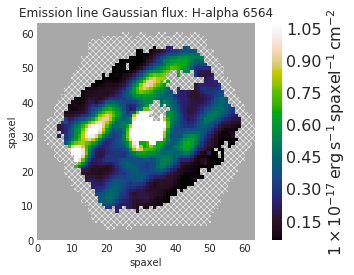

In [129]:
maps = Maps(firefly_fits[1].data['PLATEIFU'][2948])
ha = maps.emline_gflux_ha_6564
ha.plot()


In [139]:
ha.value.flatten(order='C').shape

(4096,)

In [76]:
# _check_HYB('8481-6103')
# path_marvin_data = '../../bak_la/root/bash_file/manga_maps_data'
# MaNGA_plaifu = '9891-9102'
# filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
# try:
#     maps = Maps(filename=filename)
# except:
#     print("lalala")
def _check_HYB(MaNGA_plaifu):
    try:
        filename = join(path_marvin_data, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
        maps = Maps(filename=filename)
        #ha = maps.emline_gflux_ha_6564
        #masks_bpt, __, __ = maps.get_bpt(show_plot=False)
        return 666
    except:
        #pass
        return -999
_check_HYB('8481-6103')
list(map(_check_HYB, ['8481-6103','8252-9102','9883-3701','8481-6103']))

[-999, 666, 666, -999]

# 获取 MaNGA 星系的 SFR 数据

In [92]:
# check the version of data release
from marvin import config
config.release

'DR15'

In [95]:
# import the Query tool
from marvin.tools.query import Query
my_filter = 'nsa.z < 0.1'
q = Query(search_filter=my_filter)
# run the query
r = q.run()

# print some results information
print(r)
print('number of results:', r.totalcount)

Marvin Results(query=nsa.z < 0.1, totalcount=4275, count=100, mode=remote)
number of results: 4275


In [96]:
q.datamodel.groups

[<ParameterGroup name=Metadata, n_parameters=11>,
 <ParameterGroup name=NSA Catalog, n_parameters=158>,
 <ParameterGroup name=ObsInfo, n_parameters=64>,
 <ParameterGroup name=DAPall Summary, n_parameters=804>,
 <ParameterGroup name=Other, n_parameters=134>]

In [99]:
# select and print the NSA parameter group
nsa = q.datamodel.groups['DAPall Summary']
nsa.parameters

[<QueryParameter full=dapall.adist_nsa_z, name=adist_nsa_z, short=adist_nsa_z, remote=adist_nsa_z, display=Adist_Nsa_Z>,
 <QueryParameter full=dapall.adist_z, name=adist_z, short=adist_z, remote=adist_z, display=Adist_Z>,
 <QueryParameter full=dapall.bin_r_n_1, name=bin_r_n_1, short=bin_r_n_1, remote=bin_r_n_1, display=Bin_R_N_1>,
 <QueryParameter full=dapall.bin_r_n_2, name=bin_r_n_2, short=bin_r_n_2, remote=bin_r_n_2, display=Bin_R_N_2>,
 <QueryParameter full=dapall.bin_r_n_3, name=bin_r_n_3, short=bin_r_n_3, remote=bin_r_n_3, display=Bin_R_N_3>,
 <QueryParameter full=dapall.bin_r_snr_1, name=bin_r_snr_1, short=bin_r_snr_1, remote=bin_r_snr_1, display=Bin_R_Snr_1>,
 <QueryParameter full=dapall.bin_r_snr_2, name=bin_r_snr_2, short=bin_r_snr_2, remote=bin_r_snr_2, display=Bin_R_Snr_2>,
 <QueryParameter full=dapall.bin_r_snr_3, name=bin_r_snr_3, short=bin_r_snr_3, remote=bin_r_snr_3, display=Bin_R_Snr_3>,
 <QueryParameter full=dapall.bin_rmax, name=bin_rmax, short=bin_rmax, remote=bin_r

In [100]:
my_filter = 'dapall.sfr_tot > 5'
q = Query(search_filter=my_filter)
r = q.run()
print(r)
print(r.results)

Marvin Results(query=dapall.sfr_tot > 5, totalcount=6, count=6, mode=remote)
<ResultSet(set=1.0/1, index=0:6, count_in_set=6, total=6)>
[ResultRow(mangaid='1-24092', plateifu='7991-1901', sfr_tot=5.5633, bintype_name='VOR10', template_name='GAU-MILESHC'),
 ResultRow(mangaid='1-24092', plateifu='7991-1901', sfr_tot=5.69988, bintype_name='HYB10', template_name='GAU-MILESHC'),
 ResultRow(mangaid='1-37863', plateifu='9193-12704', sfr_tot=6.457, bintype_name='VOR10', template_name='GAU-MILESHC'),
 ResultRow(mangaid='1-37863', plateifu='9193-12704', sfr_tot=6.82693, bintype_name='HYB10', template_name='GAU-MILESHC'),
 ResultRow(mangaid='1-43214', plateifu='8135-1902', sfr_tot=26.4648, bintype_name='VOR10', template_name='GAU-MILESHC'),
 ResultRow(mangaid='1-43214', plateifu='8135-1902', sfr_tot=27.4152, bintype_name='HYB10', template_name='GAU-MILESHC')]


### use DAP [Data Analysis Pipeline] to get SFR total per galaxy
+ https://data.sdss.org/sas/dr15/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits [data download]
+ https://www.sdss.org/dr15/manga/manga-tutorials/dapall/ [some interpretation]
---
> log(SFR) = log LHα - 41.27 (Kennicutt & Evans [2012, ARAA, 50, 531], citing Murphy et al. [2011, ApJ, 737, 67] and Hao et al. [2011, ApJ, 741, 124]; Kroupa IMF), where LHα = 4π EML_FLUX_TOT (LDIST_Z)2 and ''no'' attentuation correction has been applied.

In [39]:
import numpy as np
import matplotlib.pyplot as pyplot
from astropy.io import fits

dapall_fits = fits.open('./tmp_storage/dapall-v2_4_3-2.2.1.fits')
indx = (dapall_fits['DAPALL'].data['DAPTYPE'] == 'HYB10-GAU-MILESHC') & \
       (dapall_fits['DAPALL'].data['DAPDONE'] == 1)
dapall_data = copy(dapall_fits[1].data[indx])

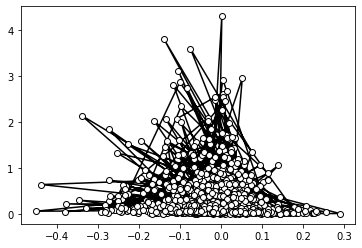

In [151]:
# 取出未重复的星系的 plateifu
sel_plateifu, sel_id = np.unique(manga_Z['plate-ifu'].values,return_index=True)
# 取出对应的星系的 stellar mass
sel_mass = manga_Z['stellar_mass_global'].values[sel_id]
# 计算每个星系的平均金属丰度偏差
sel_dev_avg_Z = [np.mean(manga_Z['metallicity_deviation'].values[plifu==manga_Z['plate-ifu']]) \
                 for plifu in sel_plateifu]
sel_dev_avg_Z = np.array(sel_dev_avg_Z)
# 每个星系的恒星形成率
sel_sfr = [dapall_data['SFR_TOT'][plifu==dapall_data['PLATEIFU']][0] \
           for plifu in sel_plateifu]
sel_sfr = np.array(sel_sfr)



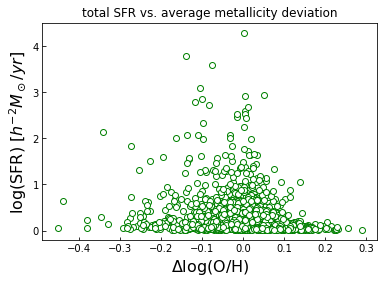

In [162]:
# 画图！
xx = sel_dev_avg_Z
yy = sel_sfr
plt.plot(xx,yy,'o',color='green',markerfacecolor='white')
plt.tick_params(which='both',direction='in')
# plt.legend(loc='best')
plt.title("total SFR vs. average metallicity deviation")
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('log(SFR) [$h^{-2}M_\odot /yr$]',fontsize=16)
plt.show()

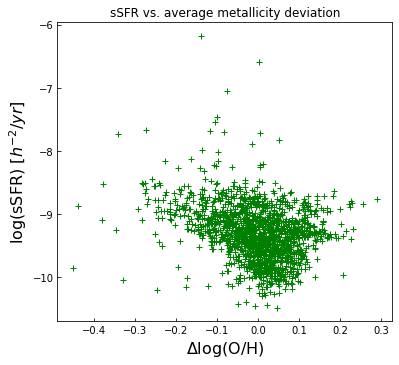

In [186]:
# 画图！
xx = sel_dev_avg_Z
yy = sel_sfr-sel_mass
plt.figure(figsize=(6,5.5))
plt.plot(xx,yy,'+',color='green',markerfacecolor='white')
plt.tick_params(which='both',direction='in')
# plt.legend(loc='best')
plt.title("sSFR vs. average metallicity deviation")
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('log(sSFR) [$h^{-2}/yr$]',fontsize=16)
plt.show()

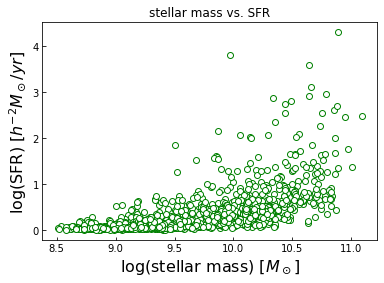

In [171]:
# 画图！
xx = sel_mass
yy = sel_sfr
plt.plot(xx,yy,'o',color='green',markerfacecolor='white')
plt.tick_params(which='both',direction='in')
# plt.legend(loc='best')
plt.title("stellar mass vs. SFR")
plt.xlabel('log(stellar mass) [$M_\odot$]',fontsize=16)
plt.ylabel('log(SFR) [$h^{-2}M_\odot /yr$]',fontsize=16)
plt.show()

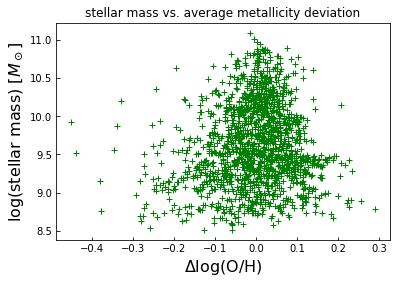

In [176]:
# 画图！
xx = sel_dev_avg_Z
yy = sel_mass
plt.plot(xx,yy,'+',color='green',markerfacecolor='white')
plt.tick_params(which='both',direction='in')
# plt.legend(loc='best')
plt.title("stellar mass vs. average metallicity deviation")
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('log(stellar mass) [$M_\odot$]',fontsize=16)
plt.show()

### 计算 MaNGA　星系的 sSFR
根据 flux Ha 和 surface mass density 进行计算   
+ 凭借 flux 计算 luminosity = L
+ 使用 z 计算 diameter distance = dA
+ SFR(Ha) = 7.9*10^-42 * L
+ sfr(spaxel) = SFR(Ha)/(0.5*dA)^2
+ sSFR = sfr(spaxel) / surface mass density

In [150]:
# use firefly's stellar mass per spaxel to check the 
# relation between stellar mass and metallicity deviation
plateifu = '8252-9102'
tmp_id = (manga_Z['plate-ifu'].values==plateifu)
def _stellar_mass_spaxel(plateifu,x2800):
    tmp_id = (firefly_fits[1].data['PLATEIFU']==plateifu)
    tmp_mass = firefly_fits[11].data[tmp_id]
    
firefly_fits[1].data['STELLAR_MASS_VORONOI'][] for plateifu,x2800 in zip(manga_Z['plate-ifu'].values, manga_Z['x2800'].values)

[-0.004826327137752988,
 0.054869939400807206,
 0.04102942279903808,
 0.03499978207862797,
 0.05117986664115164,
 -0.08162398632852444,
 0.041526609066471265,
 -0.08312340585809969,
 0.03614351344145908,
 -0.06145894605310268]

In [190]:
firefly_fits.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GALAXY_INFO    1 BinTableHDU     31   4675R x 11C   [20A, 20A, I, 20A, E, E, E, E, 20A, 20A, 20A]   
  2  GLOBAL_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  3  GRADIENT_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  SPATIAL_INFO    1 ImageHDU         9   (4, 2800, 4675)   float32   
  5  SPATIAL_BINID    1 ImageHDU         9   (76, 76, 4675)   int16   
  6  LW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  7  MW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  8  LW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  9  MW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
 10  E(B_V)_VORONOI    1 ImageHDU         8   (2800, 4675)  

In [130]:

sel_gal_plifu = dapall_data['PLATEIFU']
def _dap_sfr(plateifu):
    try:
        tmp_id = (sel_gal_plifu==plateifu)
        if len(sel_gal_plifu[tmp_id])==1:
            return dapall_data['SFR_TOT'][tmp_id][0]
        else:
            return -999
    except Exception as e:
        raise Exception(repr(e)) 
start_time = time.time()
pool = Pool(processes=30,maxtasksperchild=1000)

try:
    manga_Z_sfr = np.array(pool.map(_dapsfr, manga_Z["plate-ifu"].values))
except Exception as e:
    pool.close()
    print(e)
    print("There is something wrong!")

pool.close()
pool.join()
# print(list(map(_dapsfr, manga_Z["plate-ifu"].values[0:10000])))
end_time = time.time()
print("used time is %.2f s" % (end_time-start_time))

used time is 11.31 s


## 星系匹配 | MaNGA | ALFALFA   
**数据说明：**

 `../../bak_la/root/cosmos/data/manga_dr15_alfalfa.fits` 
> 存储ALFALFA和MaNGA的星系匹配结果，使用　AGC & plate-ifu 作为编号，无效数据为-999

 `../../bak_la/root/cosmos/data/mangaHIall.fits` 
> 存储的是 MaNGA-HI 项目所观测的，不属于ALFALFA，属于MaNGA的星系的HI数据   
> [datamodel] https://data.sdss.org/datamodel/files/MANGA_HI/HIPVER/mangaHIall.html   
> [intro] https://www.sdss.org/dr15/data_access/value-added-catalogs/?vac_id=hi-manga-data-release-1

 `./tmp_storage/alfalfa.csv` 
> 来源于ALFALFA官网，存储的是ALFALFA的所有数据    
> http://egg.astro.cornell.edu/alfalfa/data/

**功能：**   
+ 统计出ALM星系分别在 MaNGA_sf, ALFALFA_sf, MaNGA-HI_sf 中所占的比例【假定这三者是相互独立的观测】，检查是否一致，论文中为25%
+ 结合 ALFALFA & MaNGA-HI & MaNGA，得到 MaNGA 星系中有 HI数据的【排除那些观测到但是信噪比低或者没有有效数据的星系】
+ 得到 mass_HI vs. flux_HI 关系图 【检查二者是否为简单的正比例关系，实际观测中，一定是用了某些关系，从 flux 推导出了 mass】
+ `得到 ALM_fraction[ALM/sf] vs. mass_HI 关系图`
+ 得到 ALM_fraction[ALM/sf] vs. flux_HI 关系图
+ 得到 ALM_average vs. mass_HI 关系图
+ 得到 ALM_average vs. flux_HI 关系图

In [7]:
# 导入 ALFALFA 数据，没有无效数据
alfalfa_path = './tmp_storage/alfalfa.csv'
alfalfa_data = pd.read_csv(alfalfa_path)

# 导入 drpall (MaNGA数据)
drp_fits = copy(fits.open('../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'))
alfalfa_data

AGCNr      Name   RAdeg_HI  DECdeg_HI   RAdeg_OC  DECdeg_OC  Vhelio  \
0      105367  ........    0.00167    5.44333    0.00333    5.44250   11983   
1      333313  ........    0.00375   24.90889  359.99750   24.90750   11181   
2      331060  478-009b    0.01042   23.08472    0.01417   23.08750    4463   
3      331061  456-013.    0.01042   15.87222    0.00875   15.88167    6007   
4      104570  ........    0.00667   32.70834    0.00500   32.71028   10614   
...       ...       ...        ...        ...        ...        ...     ...   
31497  331054  517-008.  359.92041   34.34722  359.92877   34.34528    4900   
31498  331052  Eder.Dw.  359.93500   27.25778  359.93750   27.25389    4692   
31499  334869  ........  359.96167   21.55028  359.96042   21.55611   10432   
31500  332965  ........  359.98166    5.23889  359.97873    5.23889    3038   
31501  332118  ........  359.98877    4.89722  359.99084    4.90111    9207   

       W50  sigW  W20  HIflux  sigflux   SNR   RMS   Dist  sigDist  logMH  \
0      274    39  281    1.14     0.08   8.1  1.91  166.0      2.3   9.87   
1      313    20  333    1.80     0.09  11.3  2.02  154.8      2.3  10.01   
2      160     4  184    1.96     0.07  14.7  2.35   50.6     10.4   9.07   
3      260    45  268    1.13     0.09   6.5  2.40   85.2      2.4   9.29   
4      245     6  250    0.86     0.07   6.6  1.86  147.0      2.3   9.64   
...    ...   ...  ...     ...      ...   ...   ...    ...      ...    ...   
31497   84    14  152    2.24     0.07  23.3  2.33   69.5      2.3   9.41   
31498   61     2   75    0.58     0.04   7.6  1.95   66.5      2.3   8.78   
31499  171     9  185    0.97     0.07   7.7  2.14  144.0      2.3   9.68   
31500  124     9  158    1.18     0.06  13.4  1.76   42.8      2.3   8.71   
31501  186     4  199    1.58     0.09   9.9  2.62  126.4      2.2   9.77   

       siglogMH  HIcode  
0          0.05       1  
1          0.05       1  
2          0.18       1  
3          0.06       1  
4          0.06       1  
...         ...     ...  
31497      0.05       1  
31498      0.06       1  
31499      0.06       1  
31500      0.07       1  
31501      0.05       1  

[31502 rows x 19 columns]

In [8]:
mg_alfa_data = copy(fits.open('../../bak_la/root/cosmos/data/manga_dr15_alfalfa.fits'))
mgal_HI_mass = mg_alfa_data[1].data['LOGMHI']
mg_alfa = mg_alfa_data[1].data[mgal_HI_mass>0]
type(mg_alfa['PLATEIFU'])

numpy.chararray

In [9]:
mg_alfa.shape

(373,)

In [10]:
mgHI_fits = copy(fits.open('../../bak_la/root/cosmos/data/mangaHIall.fits'))
mgHI_fits.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1896,)   uint8   
  1  MANGAHIALL - HI-MANGA DATA FROM AGBT16A_95 OBSERVING    1 BinTableHDU     65   331R x 26C   [10A, 9A, D, D, I, 12A, E, E, E, E, E, E, E, I, E, I, I, I, I, I, E, E, E, E, E, E]   


In [11]:
# 获取 MaNGA-ALFALFA 匹配数据，源于 MaNGA-HI 论文，无效数据为-999
mg_alfa_fits = copy(fits.open('../../bak_la/root/cosmos/data/manga_dr15_alfalfa.fits'))
mgal_HI_mass = mg_alfa_fits[1].data['LOGMHI']
print("MaNGA和ALFALFA共匹配到 %d 个星系" % np.shape(mgal_HI_mass))
mg_alfa = mg_alfa_data[1].data[mgal_HI_mass>0]  # 去除无效数据
# 正式读取数据
mgal_agc = mg_alfa['AGC']
mgal_HI_mass = mg_alfa['LOGMHI']
mgal_plifu = mg_alfa['PLATEIFU']
print("    去除无效数据后，剩余 %d 个星系" % np.shape(mgal_HI_mass))

# 获取 MaNGA-HI 项目的观测数据，无效数据为 -999
mgHI_fits = copy(fits.open('../../bak_la/root/cosmos/data/mangaHIall.fits'))
mgHI_mass = mgHI_fits[1].data['LOGMHI']
print("\nMaNGA-HI 项目共观测了 %d 个在MaNGA中的星系" % np.shape(mgHI_mass))
mgHI = mgHI_fits[1].data[mgHI_mass>0]  # 去除无效数据
# 正式读取数据
mgHI_plifu = mgHI['plateifu']#.astype(str)
mgHI_mass = mgHI['LOGMHI']
print("    去除无效数据后，剩余 %d 个星系" % np.shape(mgHI_mass))

MaNGA和ALFALFA共匹配到 1021 个星系
    去除无效数据后，剩余 373 个星系

MaNGA-HI 项目共观测了 331 个在MaNGA中的星系
    去除无效数据后，剩余 185 个星系


In [12]:
# 检查 MaNGA 与 ALFALFA 的匹配

# 获取 ra，dec
def _radec_manga(plateifu):
    tmp_id = (drp_fits[1].data['plateifu']==plateifu)
    ra = drp_fits[1].data['objra'][tmp_id][0]    
    dec = drp_fits[1].data['objdec'][tmp_id][0]  
    return ra,dec
def _radec_alfalfa(plateifu):
    # plate-ifu 对应的 agc 编号
    agc = mgal_agc[mgal_plifu==plateifu]
    #print("agc = ",agc)
    tmp_id = (alfalfa_data['AGCNr'].values==agc)
    if len(alfalfa_data['AGCNr'].values[tmp_id])==0:
        print("%s 星系不存在，出错啦！！！" % plateifu)
        return False
    else:
        # 发光目标的 ra，dec
        ra = alfalfa_data['RAdeg_OC'].values[tmp_id][0]
        dec = alfalfa_data['DECdeg_OC'].values[tmp_id][0]
        # HI 气体的 ra，dec
        #ra = alfalfa_data['RAdeg_HI'].values[tmp_id][0]
        #dec = alfalfa_data['DECdeg_HI'].values[tmp_id][0]
        return ra,dec
print(_radec_manga(mgal_plifu[66]))
print(_radec_alfalfa(mgal_plifu[66]))


(166.01663, 22.6354)
(166.01584, 22.636670000000002)


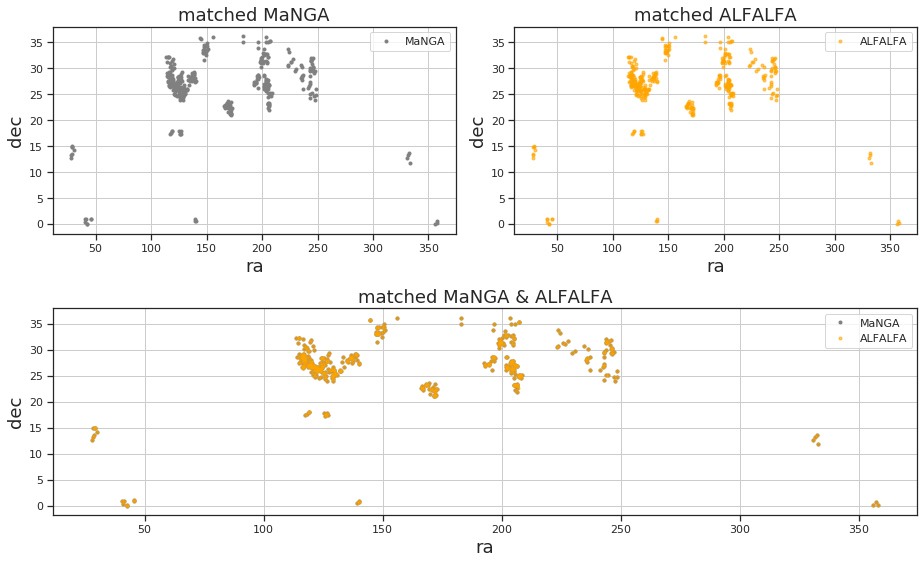

In [14]:
'''检查 MaNGA 和 ALFALFA 匹配结果
'''
import seaborn as sns
sns.set(style="ticks", color_codes=False)

radec_manga = np.array(list(map(_radec_manga, mgal_plifu)))
radec_alfalfa = np.array(list(map(_radec_alfalfa, mgal_plifu)))
#########################################################################################
# 画图 dec vs ra
plt.figure(figsize=(13,8))

# 单独考虑 MaNGA [MaNGA & ALFALFA]
plt.subplot(221)
plt.plot(radec_manga[:,0],radec_manga[:,1],'.',color = 'grey',label='MaNGA')
plt.grid()
plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("matched MaNGA",fontsize = 18)

# 单独考虑 ALFALFA [MaNGA & ALFALFA]
plt.subplot(222)
plt.plot(radec_alfalfa[:,0],radec_alfalfa[:,1],'.',color = 'orange',label='ALFALFA',alpha = 0.6)
plt.grid()
plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("matched ALFALFA",fontsize = 18)

# 二者重叠在一起 [MaNGA & ALFALFA]
plt.subplot(212)
plt.plot(radec_manga[:,0],radec_manga[:,1],'.',color = 'grey',label='MaNGA')
plt.plot(radec_alfalfa[:,0],radec_alfalfa[:,1],'.',color = 'orange',label='ALFALFA',alpha = 0.6)
plt.grid()
plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("matched MaNGA & ALFALFA",fontsize = 18)
plt.tight_layout()
plt.show()

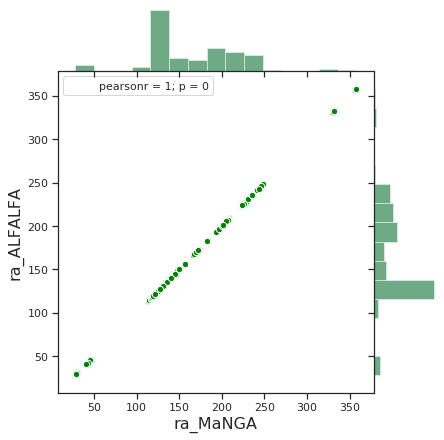

In [17]:
'''检查 MaNGA 和 ALFALFA 匹配结果
'''
# sns.jointplot(x="x", y="y", data=df);
la = sns.jointplot(radec_manga[:,0],radec_alfalfa[:,0],space=0)
la.set_axis_labels('ra_MaNGA', 'ra_ALFALFA', fontsize=16)#,fontweight='bold')
# plt.legend()
# plt.tight_layout()
# la.plot(sns.regplot, sns.distplot)
la.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
# la.plot_joint(plt.plot,(0, 500), (0, 500), c=".2", ls="--")
la.plot_marginals(sns.distplot, kde=False, color="g")
la.annotate(stats.pearsonr)



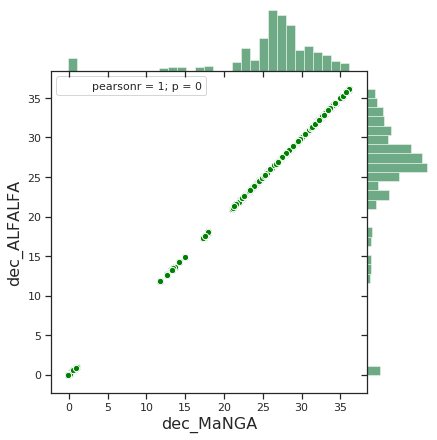

In [18]:
la = sns.jointplot(radec_manga[:,1],radec_alfalfa[:,1],space=0)
la.set_axis_labels('dec_MaNGA', 'dec_ALFALFA', fontsize=16)#,fontweight='bold')
# plt.legend()
# plt.tight_layout()
# la.plot(sns.regplot, sns.distplot)
la.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
# la.plot_joint(plt.plot,(0, 500), (0, 500), c=".2", ls="--")
la.plot_marginals(sns.distplot, kde=False, color="g")
la.annotate(stats.pearsonr)

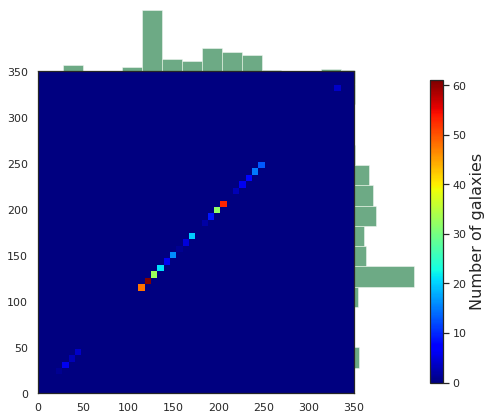

In [19]:
sns.set_style('white')
la = sns.jointplot(radec_manga[:,0],radec_alfalfa[:,0],space=0)
la.set_axis_labels('ra_MaNGA', 'ra_ALFALFA', fontsize=16)#,fontweight='bold')
# plt.legend()
# plt.tight_layout()
# la.plot(sns.regplot, sns.distplot)
# la.plot_joint(plt.scatter,color="g", s=80, edgecolor="white")
la.plot_marginals(sns.distplot, kde=False, color="g")
la.annotate(stats.pearsonr)

la.ax_joint.cla()
plt.sca(la.ax_joint)
my_cmap = plt.cm.jet
my_cmap.set_under('w',1)
plt.hist2d(radec_manga[:,0],radec_alfalfa[:,0], bins=(50, 50), cmap=my_cmap,range=np.array([(0, 350), (0, 350)]));
cbar_ax = la.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)

cb.set_label(r'Number of galaxies',fontsize=16)
# la.axes.flat.ax.plot((0, 500), (0, 500), c=".2", ls="--")

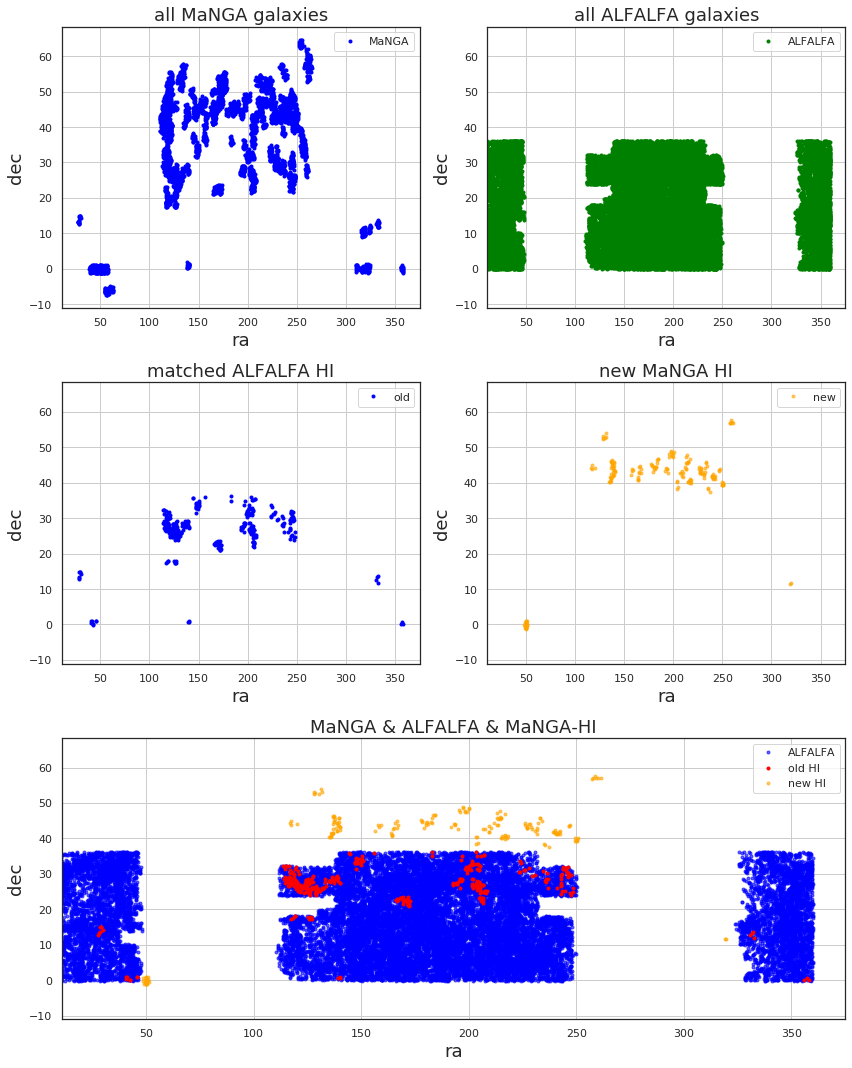

In [20]:
'''查看 ALFALFA and MaNGA with HI data galaxies
'''
radec_manga = np.array(list(map(_radec_manga, mgal_plifu)))
radec_alfalfa = np.array(list(map(_radec_alfalfa, mgal_plifu)))
#########################################################################################
# 画图 dec vs ra
plt.figure(figsize=(12,15))

# 只画出所有的 MaNGA 星系
plt.subplot(321)
plt.plot(firefly_fits[1].data["OBJRA"],firefly_fits[1].data["OBJDEC"],'.',color = 'blue',label='MaNGA')
plt.grid()
plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("all MaNGA galaxies",fontsize = 18)
xlim = plt.xlim()
ylim = plt.ylim()

# 只画出所有的 ALFALFA 星系
plt.subplot(322)
plt.plot(alfalfa_data['RAdeg_HI'],alfalfa_data['DECdeg_HI'],'.',color = 'green',label='ALFALFA')
plt.grid()
plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("all ALFALFA galaxies",fontsize = 18)
plt.xlim(xlim)
plt.ylim(ylim)

# 单独考虑 ALFALFA [MaNGA & ALFALFA]=matched HI, old data of HI
plt.subplot(323)
plt.plot(radec_manga[:,0],radec_manga[:,1],'.',color = 'blue',label='old')
plt.grid()
plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("matched ALFALFA HI",fontsize = 18)
plt.xlim(xlim)
plt.ylim(ylim)

# 单独考虑 MaNGA [MaNGA-HI], new data of HI
plt.subplot(324)
plt.plot(mgHI['objra'],mgHI['objdec'],'.',color = 'orange',label='new',alpha = 0.6)
plt.grid()
plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("new MaNGA HI",fontsize = 18)
plt.xlim(xlim)
plt.ylim(ylim)

# 二者重叠在一起 [MaNGA-HI & matched-HI & ALFALFA]
plt.subplot(313)
plt.plot(alfalfa_data['RAdeg_HI'],alfalfa_data['DECdeg_HI'],'.',color = 'blue',label='ALFALFA',alpha = 0.6)
plt.plot(radec_manga[:,0],radec_manga[:,1],'.',color = 'red',label='old HI')
plt.plot(mgHI['objra'],mgHI['objdec'],'.',color = 'orange',label='new HI',alpha = 0.6)
plt.grid()
plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("MaNGA & ALFALFA & MaNGA-HI",fontsize = 18)
plt.xlim(xlim)
plt.ylim(ylim)

plt.tight_layout()  # 间距调整
plt.show()

In [21]:
'''检查 old HI 和 new HI 是否有重叠部分 【结果：无重叠】
有重合则为 1，没有重合则为 0
'''
chek = [len(mgal_plifu[mgal_plifu==plateifu]) for plateifu in mgHI_plifu]
chek = np.array(chek)
if len(np.where(chek>0)[0])>0:
    print("旧ALFALFA的HI数据和新的MaNGA的HI数据有有有重叠！！！")
else:
    print("旧ALFALFA的HI数据和新的MaNGA的HI数据无无无重叠！！！")
    print("目前拥有HI数据的MaNGA星系数量为： %d  个" % (np.size(mgal_plifu)+np.size(mgHI_plifu)))

旧ALFALFA的HI数据和新的MaNGA的HI数据无无无重叠！！！
目前拥有HI数据的MaNGA星系数量为： 558  个


### star forming 星系 匹配 【根据plateifu编号】
+ MaNGA中筛选出的 star forming & late type & .........
+ MaNGA HI 中 star forming 星系
+ ALFALFA 中 star forming 星系

In [22]:
# MaNGA 中筛选出的星系的 plate-ifu
sf_gal_plifu, sel_id = np.unique(manga_Z['plate-ifu'].values,return_index=True)
a = firefly_fits[1].data.shape[0]
b = sf_gal_plifu.shape[0]
print("在MaNGA中，共有 %d 个星系，\n共筛选出 %d 个星系" % (a,b))

在MaNGA中，共有 4675 个星系，
共筛选出 1547 个星系


In [23]:
# MaNGA-HI 中的 sf 星系
mgHI_plateifu = mgHI_fits[1].data['plateifu']
chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgHI_plateifu])
# chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgHI_plifu])
mgHI_sf_plateifu = mgHI_plateifu[chek==1]
# mgHI_sf_plateifu = mgHI_plifu[chek==1]

c = mgHI_plateifu.shape[0]
d = mgHI_sf_plateifu.shape[0]
print("在 MaNGA-HI 中，共有 %d 个星系，\n共筛选出 %d 个星系" % (c,d))

在 MaNGA-HI 中，共有 331 个星系，
共筛选出 149 个星系


In [24]:
# ALFALFA和MaNGA 匹配星系中的 sf 星系
mgal_plateifu = mg_alfa_fits[1].data['plateifu']
chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgal_plateifu])
# chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgal_plifu])
mgal_sf_plateifu = mgal_plateifu[chek==1]
# mgal_sf_plateifu = mgal_plifu[chek==1]
e = mgal_plateifu.shape[0]
f = mgal_sf_plateifu.shape[0]
print("在 MaNGA & ALFALFA 中，共有 %d 个星系，\n共筛选出 %d 个星系" % (e,f))


在 MaNGA & ALFALFA 中，共有 1021 个星系，
共筛选出 388 个星系


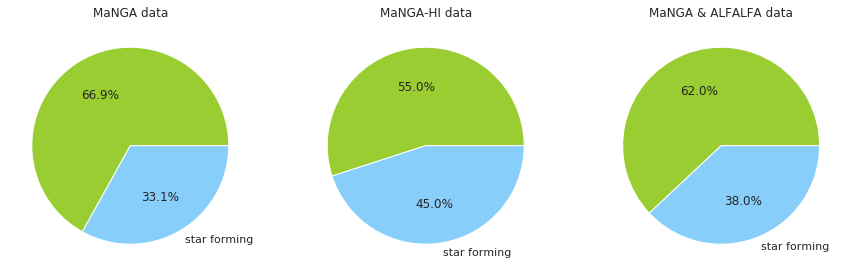

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.pie(x=[a-b,b],labels=['','star forming'],autopct='%.1f%%',colors=['yellowgreen','lightskyblue'])#,explode=[0,1])
plt.title("MaNGA data")

plt.subplot(132)
plt.pie(x=[c-d,d],labels=['','star forming'],autopct='%.1f%%',colors=['yellowgreen','lightskyblue'])#,explode=[0,1])
plt.title("MaNGA-HI data")

plt.subplot(133)
plt.pie(x=[e-f,f],labels=['','star forming'],autopct='%.1f%%',colors=['yellowgreen','lightskyblue'])#,explode=[0,1])
plt.title("MaNGA & ALFALFA data")

plt.show()

### ALM 星系 匹配 【根据plateifu编号】
+ MaNGA中筛选出的 star forming & late type & .........
+ MaNGA HI 中 star forming 星系
+ ALFALFA 中 star forming 星系

In [28]:
# # 判断单个星系是否为 最后要求的星系 【surface mass density>7】
# def _density_galaxy(plateifu):
#     tmp_id = (manga_Z['plate-ifu'].values==plateifu)
#     sur_density = manga_Z['dep_surface_mass_density'].values[tmp_id]
#     mass = manga_Z['stellar_mass_global'].values[tmp_id]
#     num_spaxels = len(dev_Z[(sur_density>7)&(mass>9)])
#     return num_spaxels
# 判断单个星系是否为 ALM？通过ALMspaxels的数量进行判断【ALM_spaxels>=20】
def _alm_galaxy(plateifu):
    # ALM 判断条件
    cri = -0.133
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    dev_Z = manga_Z['metallicity_deviation'].values[tmp_id]
    sur_density = manga_Z['dep_surface_mass_density'].values[tmp_id]
    mass = manga_Z['stellar_mass_global'].values[tmp_id]
    num_spaxels = len(dev_Z[(dev_Z <= cri)&(sur_density>7)&(mass>9)])
    return num_spaxels
# test
_alm_galaxy(sf_gal_plifu[666])
# chek=np.array([_alm_galaxy(plateifu) for plateifu in sf_gal_plifu])
# chek.shape

21

In [29]:
start_time = time.time()
pool = Pool(processes=30,maxtasksperchild=1000)

chek = np.array(pool.map(_alm_galaxy, sf_gal_plifu))

pool.close()
pool.join()
# print(list(map(_dapsfr, manga_Z["plate-ifu"].values[0:10000])))
end_time = time.time()
print("used time is %.2f s" % (end_time-start_time))

used time is 5.63 s


In [30]:
alm_plifu = sf_gal_plifu[chek>20]
alm_plifu.shape

(399,)

In [31]:
manga_Z['dep_surface_mass_density'].min()

5.109655521726847

In [32]:
# MaNGA 中筛选出的星系的 plate-ifu
sf_gal_plifu, sel_id = np.unique(manga_Z['plate-ifu'].values,return_index=True)
# mg_ALM = manga_Z['metallicity_deviation'].values[sel_id]
# alm_plifu = sf_gal_plifu[mg_ALM<=-0.133]
b2 = alm_plifu.shape[0]
print("在MaNGA sf中，共有 %d 个星系，\n共筛选出 %d 个星系" % (b,b2))

# MaNGA-HI 中的 sf 星系
mgHI_plateifu = mgHI_fits[1].data['plateifu']
chek = np.array([len(alm_plifu[alm_plifu==plateifu]) for plateifu in mgHI_plateifu])
mgHI_sf_plateifu = mgHI_plateifu[chek==1]
d2 = mgHI_sf_plateifu.shape[0]
print("在 MaNGA-HI sf中，共有 %d 个星系，\n共筛选出 %d 个星系" % (d,d2))

# ALFALFA和MaNGA 匹配星系中的 sf 星系
mgal_plateifu = mg_alfa_fits[1].data['plateifu']
chek = np.array([len(alm_plifu[alm_plifu==plateifu]) for plateifu in mgal_plateifu])
mgal_sf_plateifu = mgal_plateifu[chek==1]
f2 = mgal_sf_plateifu.shape[0]
print("在 MaNGA & ALFALFA sf中，共有 %d 个星系，\n共筛选出 %d 个星系" % (f,f2))

在MaNGA sf中，共有 1547 个星系，
共筛选出 399 个星系
在 MaNGA-HI sf中，共有 149 个星系，
共筛选出 35 个星系
在 MaNGA & ALFALFA sf中，共有 388 个星系，
共筛选出 109 个星系


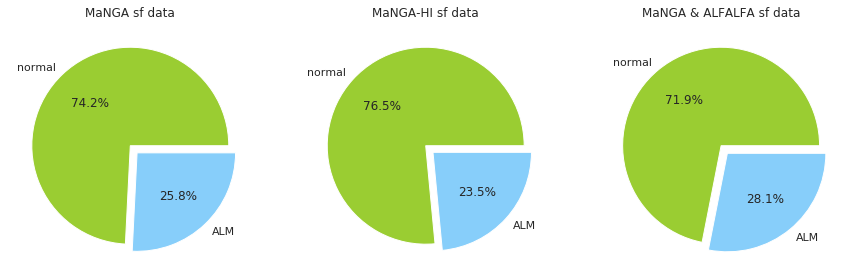

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.pie(x=[b-b2,b2],labels=['normal','ALM'],autopct='%.1f%%',colors=['yellowgreen','lightskyblue'],explode = (0,0.1))
plt.title("MaNGA sf data")

plt.subplot(132)
plt.pie(x=[d-d2,d2],labels=['normal','ALM'],autopct='%.1f%%',colors=['yellowgreen','lightskyblue'],explode = (0,0.1))
plt.title("MaNGA-HI sf data")

plt.subplot(133)
plt.pie(x=[f-f2,f2],labels=['normal','ALM'],autopct='%.1f%%',colors=['yellowgreen','lightskyblue'],explode = (0,0.1))
#        wedgeprops = {'linewidth': 1.5, 'edgecolor':'green'})  # 边框属性
plt.title("MaNGA & ALFALFA sf data")

plt.show()

### 得到 ALM 星系的 ALM spaxels 比例 和 sfr 关系

In [34]:
# 判断单个星系是否为 ALM？通过ALMspaxels的数量进行判断【ALM_spaxels>=20】
def _alm_galaxy(plateifu):
    # ALM 判断条件
    cri = -0.133
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    dev_Z = manga_Z['metallicity_deviation'].values[tmp_id]
    sur_density = manga_Z['dep_surface_mass_density'].values[tmp_id]
    mass = manga_Z['stellar_mass_global'].values[tmp_id]
    num_spaxels = len(dev_Z[(dev_Z <= cri)&(sur_density>7)&(mass>9)])
    return num_spaxels
# test
_alm_galaxy(sf_gal_plifu[666])

21

In [35]:
# 得到单个星系的 ALM/sf 的比值
def _alm_sf_galaxy(plateifu):
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    num_sf = len(manga_Z['plate-ifu'].values[tmp_id])
    num_alm = _alm_galaxy(plateifu)
    return num_alm / num_sf
# test
_alm_sf_galaxy(sf_gal_plifu[666])

0.05236907730673317

In [ ]:
# 每个 ALM 星系的 sfr
sel_sfr = [dapall_data['SFR_TOT'][plifu==dapall_data['PLATEIFU']][0] \
           for plifu in alm_plifu]
sel_sfr = np.array(sel_sfr)

# 每个 ALM 星系的 alm/sf 比例
alm_sf = np.array([_alm_sf_galaxy(plateifu) for plateifu in alm_plifu])


In [658]:
# 每个 ALM 星系的 sSFR
sel_ssfr = [dapall_data['SFR_TOT'][plifu==dapall_data['PLATEIFU']][0]- \
           manga_Z['stellar_mass_global'].values[manga_Z['plate-ifu'].values==plifu][0] \
           for plifu in alm_plifu]
sel_ssfr = np.array(sel_ssfr)
sel_ssfr.shape

(399,)

In [654]:
plifu = '8252-9102'
manga_Z['stellar_mass_global'].values[manga_Z['plate-ifu'].values==plifu][0]

9.973582700505737

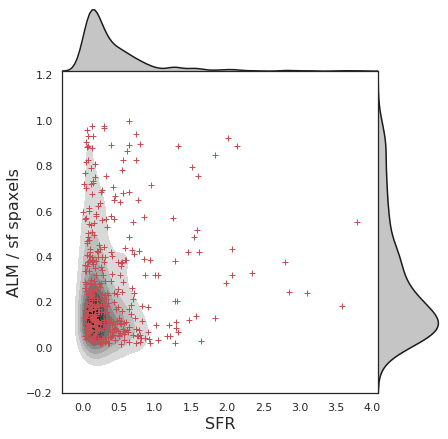

In [644]:
g = sns.jointplot(x=sel_sfr, y=alm_sf,kind="kde", color="k",shade_lowest=False,space=0)
# 创建密度图
g.plot_joint(plt.scatter,c="r", s=30, linewidth=1, marker="+")

g.set_axis_labels('SFR', 'ALM / sf spaxels', fontsize=16)

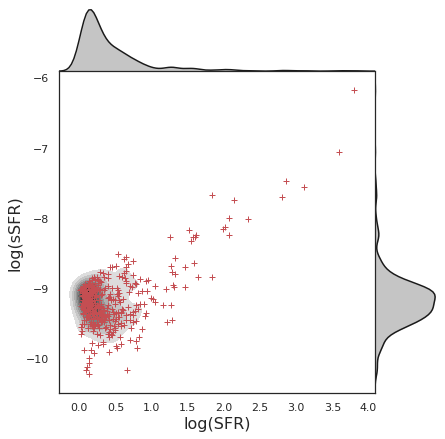

In [661]:
g = sns.jointplot(x=sel_sfr, y=sel_ssfr,kind="kde", color="k",shade_lowest=False,space=0)
# 创建密度图
g.plot_joint(plt.scatter,c="r", s=30, linewidth=1, marker="+")

g.set_axis_labels('log(SFR)', 'log(sSFR)', fontsize=16)

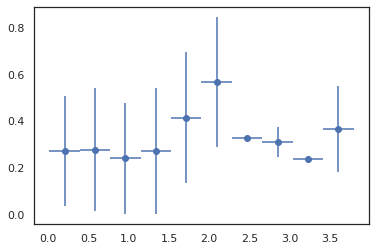

[0.01184699 0.39005768 0.76826835 1.146479   1.5246898  1.9029005
 2.2811112  2.6593218  3.0375326  3.415743  ]
[0.39005768 0.76826835 1.146479   1.5246898  1.9029005  2.2811112
 2.6593218  3.0375326  3.415743   3.793954  ]


In [643]:
# 复现论文图： 将散点图化为带有误差棒的 点图
x_dot = sel_sfr
y_dot = alm_sf
# 将 x 轴数据点分组
yhist, xbins = np.histogram(x_dot,bins=10);

# 调整最后画图的 x 轴数据
x = xbins[1:]-(xbins[1]-xbins[0])/2
x_start = xbins[0:np.size(xbins)-1]
x_end = xbins[1:]
x_error = np.array([])
y_error = np.array([])
y = np.array([])
for i in range(np.size(xbins)-1):
    y_data = y_dot[(x_dot>=x_start[i])&(x_dot<=x_end[i])]
    x_error = np.append(x_error,(x[1]-x[0])/2)
    y_error = np.append(y_error,np.std(y_data))
    y = np.append(y,np.mean(y_data))
plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o')
plt.show()
print(x_start)
print(x_end)

In [666]:
mgHI_fits[1].data['logMHI']

array([  10.04,    9.54, -999.  ,    9.43, -999.  , -999.  ,    9.28,
         10.05,    8.97,   10.  ,    9.44,    9.94, -999.  , -999.  ,
       -999.  , -999.  ,    9.55,    9.79,    9.97,    9.94, -999.  ,
       -999.  ,    9.81,   10.03,    9.5 , -999.  ,    9.3 ,   10.13,
       -999.  ,   10.09, -999.  , -999.  , -999.  , -999.  ,   10.35,
       -999.  , -999.  , -999.  ,    9.52, -999.  ,    9.8 ,    6.96,
       -999.  ,    7.5 , -999.  ,   10.13, -999.  , -999.  , -999.  ,
       -999.  , -999.  ,   10.18, -999.  ,   10.12, -999.  ,    9.42,
         10.2 , -999.  ,    9.78, -999.  ,   10.06, -999.  ,   10.03,
       -999.  ,    9.82, -999.  ,    9.83, -999.  , -999.  , -999.  ,
       -999.  , -999.  ,    9.7 , -999.  , -999.  , -999.  , -999.  ,
       -999.  ,    9.84,    9.37, -999.  ,    9.87, -999.  , -999.  ,
          9.6 ,   10.09, -999.  , -999.  , -999.  , -999.  , -999.  ,
       -999.  ,    9.85,    9.49, -999.  ,   10.12, -999.  , -999.  ,
          9.72,    9

### ALM / sf  vs HI data | galaxies
+ 包括 HI mass, flux, velocity

In [674]:
'''复现论文图： 将散点图化为带有误差棒的 点图
ALM /sf galaxies fraction vs. stellar mass
alm_plifu : ALM galaies in MaNGA
sf_gal_plifu : star-forming galaies in MaNGA
'''
# def _stellar_mass(plateifu):
#     tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    
#     ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
#     #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id][0]
#     ste_mass = math.log10(ste_mass)
#     return ste_mass


0.0
9694710.0


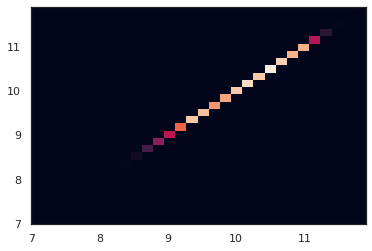

In [928]:
tmp_plifu = firefly_fits[1].data['PLATEIFU']
# tmp_firefly_mass = np.array([firefly_fits[1].data['PHOTOMETRIC_MASS'][firefly_fits[1].data['PLATEIFU']==plateifu] for plateifu in tmp_plifu])
tmp_firefly_mass = firefly_fits[1].data['PHOTOMETRIC_MASS']
tmp_drp_mass = np.array([drp_fits[1].data["NSA_ELPETRO_MASS"][drp_fits[1].data["PLATEIFU"]==plateifu] for plateifu in tmp_plifu])
print(tmp_drp_mass.min())
# tmp_id = ~np.isinf(tmp_drp_mass)[:,0]
tmp_id = np.where(tmp_drp_mass>0)[0]
tmp_firefly_mass = tmp_firefly_mass[tmp_id]
tmp_drp_mass = tmp_drp_mass[tmp_id]
tmp_drp_mass.shape
print(tmp_drp_mass.min())
tmp_firefly_mass = np.log10(tmp_firefly_mass)
tmp_drp_mass = np.log10(tmp_drp_mass)

plt.hist2d(tmp_firefly_mass,tmp_drp_mass[:,0],bins=30);
plt.show()


In [965]:
a = np.arange(1,10)
print(a)
print(a[:-1])
print(a[1:])

[1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 6 7 8]
[2 3 4 5 6 7 8 9]


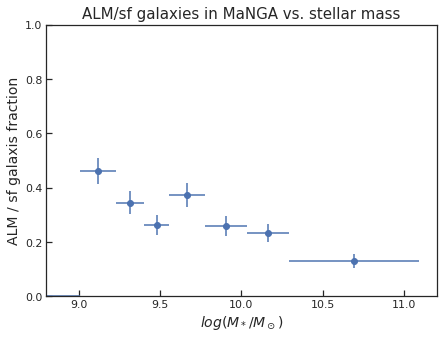

In [1111]:
'''ALM / sf galaxies vs. stellar mass in MaNGA 
'''
# get data we wanna look 
# ALM /sf 
sf_stellar_mass = np.array([_stellar_mass(plateifu) for plateifu in sf_gal_plifu])
sf_alm_01 = np.array([len(alm_plifu[alm_plifu==plateifu]) for plateifu in sf_gal_plifu])
sf_stellar_mass = np.log10([firefly_fits[1].data['PHOTOMETRIC_MASS'][firefly_fits[1].data['PLATEIFU']==plateifu] for plateifu in sf_gal_plifu])[:,0]
# sf_stellar_mass = sf_stellar_mass[:,0]
# ALM / all
# sf_stellar_mass = firefly_fits[1].data['PHOTOMETRIC_MASS']
# sf_stellar_mass = np.log10(sf_stellar_mass)
# sf_alm_01 = np.array([len(alm_plifu[alm_plifu==plateifu]) for plateifu in firefly_fits[1].data['PLATEIFU']])
# 分bin，每组数据相同。
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
x_dot = sf_stellar_mass
y_dot = sf_alm_01
# 将 x 轴数据点分组
# yhist, xbins = np.histogram(x_dot,bins=histedges_equalN(sf_stellar_mass, 10));
xbins = histedges_equalN(sf_stellar_mass, 8)
# 调整最后画图的 x 轴数据
# x = xbins[1:]-(xbins[1]-xbins[0])/2
x = (xbins[:-1]+xbins[1:])/2
x_start = xbins[0:np.size(xbins)-1]
x_end = xbins[1:]
x_error = np.array([])
y_error = np.array([])
y = np.array([])
for i in range(np.size(xbins)-1):
    y_data = y_dot[(x_dot>=x_start[i])&(x_dot<=x_end[i])]
    #y_data = ((x_dot>=x_start[i])&(x_dot<=x_end[i]))
    x_error = np.append(x_error,(x_end[i]-x_start[i])/2)
    #y_error = np.append(y_error,np.std(y_data))
    y_error = np.append(y_error,np.sqrt(np.sum(y_data))/np.size(y_data))
    #y_error = np.append(y_error,0)
    #print("np.sum(y_data) = ",np.sum(y_data))
    #print("np.size(y_data) = ",np.size(y_data))
    #y = np.append(y,np.mean(y_data))
    y = np.append(y,np.sum(y_data)/np.size(y_data))

# plot
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)

plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o')
plt.xlim(8.8,11.2)
plt.ylim(0,1.0)
# plt.legend(loc = "best")# 设置图例

plt.xlabel("$log(M_* / M_\odot)$",fontsize = 14)
plt.ylabel("ALM / sf galaxis fraction",fontsize = 14)
plt.title("ALM/sf galaxies in MaNGA vs. stellar mass",fontsize = 15)
# plt.ylabel("ALM / all galaxis fraction",fontsize = 14)
# plt.title("ALM/all galaxies in MaNGA vs. stellar mass",fontsize = 15)
ax.tick_params(which='both',direction='in')
plt.show()
# print(x_start)
# print(x_end)

In [993]:
y_dot.shape

(1547,)

In [739]:
mgHI_fits[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  117 / width of table in bytes                        
NAXIS2  =                  331 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   26 / number of columns                              
EXTNAME = 'MANGAHIALL - HI-MANGA DATA FROM AGBT16A_95 OBSERVING' / tab          
TTYPE1  = 'plateifu'           / label for column 1                             
TFORM1  = '10A     '           / format for column 1                            
TTYPE2  = 'mangaid '           / label for column 2                             
TFORM2  = '9A      '        

In [769]:
# 排除 non-detection 星系
# # HI 气体的质量，单位为太阳质量，已经 log10 了
# def _mgHI_mass(plateifu):
#     tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
#     HI_mass = mgHI_fits[1].data['LOGMHI'][tmp_id][0]
#     return HI_mass
# # test
# _mgHI_mass(mgHI_sf_plateifu[18])

# 考虑 non-detection 星系，按照最低的质量估计
# HI 气体的质量，单位为太阳质量，已经 log10 了
def _mgHI_mass(plateifu):
    tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
    HI_mass = mgHI_fits[1].data['LOGMHI'][tmp_id][0]
    if HI_mass==-999:
        HI_mass_non = mgHI_fits[1].data['logHIlim200kms'][tmp_id][0]
        return HI_mass_non
    else:
        return HI_mass
# test
_mgHI_mass(mgHI_sf_plateifu[18])

# # HI 气体的 速度，单位： km/s
# def _mgHI_velocity(plateifu):
#     tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
#     HI_velocity = mgHI_fits[1].data['VHI'][tmp_id][0]
#     return HI_velocity
# # test
# _mgHI_velocity(mgHI_sf_plateifu[18])

9.84

In [812]:
mgHI_sf_plateifu.shape

(108,)

In [952]:
'''ALM / sf galaxies vs. HI mass in MaNGA-HI
MaNGA-HI data: mgHI_fits[1].data
plateifu : mgHI_fits[1].data['plateifu']
HI mass : mgHI_fits[1].data['LOGMHI']
star-forming MaNGA-HI plateifu : mgHI_sf_plateifu
'''
# 排除 non-detection 星系
# HI 气体的质量，单位为太阳质量，已经 log10 了
def _mgHI_mass(plateifu):
    tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
    HI_mass = mgHI_fits[1].data['LOGMHI'][tmp_id][0]
    return HI_mass
# test
_mgHI_mass(mgHI_sf_plateifu[18])

# # 考虑 non-detection 星系，按照最低的质量估计
# # HI 气体的质量，单位为太阳质量，已经 log10 了
# def _mgHI_mass(plateifu):
#     tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
#     HI_mass = mgHI_fits[1].data['LOGMHI'][tmp_id][0]
#     if HI_mass==-999:
#         HI_mass_non = mgHI_fits[1].data['logHIlim200kms'][tmp_id][0]
#         return HI_mass_non
#     else:
#         return HI_mass
# # test
# _mgHI_mass(mgHI_sf_plateifu[18])

# HI 气体的 速度，单位： km/s
def _mgHI_velocity(plateifu):
    tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
    HI_velocity = mgHI_fits[1].data['VHI'][tmp_id][0]
    return HI_velocity
# test
_mgHI_velocity(mgHI_sf_plateifu[18])

# get data we wanna look
# mgHI_mass = np.array([_mgHI_mass(plateifu) for plateifu in mgHI_fits[1].data['plateifu']])
# sf_alm_01 = np.array([len(alm_plifu[alm_plifu==plateifu]) for plateifu in mgHI_fits[1].data['plateifu']])
# mgHI_mass = np.array([_mgHI_mass(plateifu) for plateifu in mgHI_sf_plateifu])
sf_alm_01 = np.array([len(alm_plifu[alm_plifu==plateifu]) for plateifu in mgHI_sf_plateifu])
mgHI_velocity = np.array([_mgHI_velocity(plateifu) for plateifu in mgHI_sf_plateifu])

print("去除无效数据前，星系个数为： ",sf_alm_01.size)
# 去除 'logHIlim200kms' 无效数据
sf_alm_01 = sf_alm_01[ mgHI_velocity!=-999]
mgHI_velocity = mgHI_velocity[mgHI_velocity!=-999]
# sf_alm_01 = sf_alm_01[mgHI_mass!=-999]
# mgHI_mass = mgHI_mass[mgHI_mass!=-999]
print("去除无效数据后，星系个数为： ",sf_alm_01.size)

去除无效数据前，星系个数为：  149
去除无效数据后，星系个数为：  107


In [850]:
mgHI_sf_plateifu.shape

(149,)

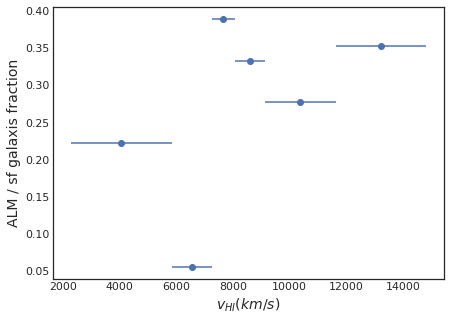

In [956]:
# 分bin，每组数据相同。
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
x_dot = mgHI_velocity
y_dot = sf_alm_01
# 将 x 轴数据点分组
# yhist, xbins = np.histogram(x_dot,bins=histedges_equalN(sf_stellar_mass, 10));
xbins = histedges_equalN(x_dot,6)
# 调整最后画图的 x 轴数据
# x = xbins[1:]-(xbins[1]-xbins[0])/2
x = (xbins[:-1]+xbins[1:])/2
x_start = xbins[0:np.size(xbins)-1]
x_end = xbins[1:]
x_error = np.array([])
y_error = np.array([])
y = np.array([])
for i in range(np.size(xbins)-1):
    y_data = y_dot[(x_dot>=x_start[i])&(x_dot<=x_end[i])]
    x_error = np.append(x_error,(x_end[i]-x_start[i])/2)
    #y_error = np.append(y_error,np.std(y_data))
    #y_error = np.append(y_error,np.sqrt(np.sum(y_data)/np.size(y_data)))
    y_error = np.append(y_error,0)
    #print("np.sum(y_data) = ",np.sum(y_data))
    #print("np.size(y_data) = ",np.size(y_data))
    #y = np.append(y,np.mean(y_data))
    y = np.append(y,np.sum(y_data)/np.size(y_data))

# plot
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)

plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o')
# plt.xlim(8.5,11.2)
# plt.ylim(0,1.0)
# plt.legend(loc = "best")# 设置图例

plt.xlabel("$log(M_{HI} / M_\odot)$",fontsize = 14)
plt.xlabel("$v_{HI} (km/s)$",fontsize = 14)
plt.ylabel("ALM / sf galaxis fraction",fontsize = 14)
# plt.ylabel("ALM / all galaxis fraction",fontsize = 14)
# plt.title("ALM/all galaxies vs. HI mass in MaNGA-HI",fontsize = 15)
ax.tick_params(which='both',direction='in')
plt.show()
# print(x_start)
# print(x_end)

In [840]:
# a = mg_alfa_fits[1].data['LOGMHI']
# b = mg_alfa_fits[1].data['LOGHILIM200KMS']
# i=1000
# print(a[i:i+9])
# print(b[i:i+9])
mg_alfa_data[1].data['LOGMHI']
mg_alfa_data[1].data['LOGHILIM200KMS'].shape

(1021,)

In [790]:
alfalfa_data

AGCNr      Name   RAdeg_HI  DECdeg_HI   RAdeg_OC  DECdeg_OC  Vhelio  \
0      105367  ........    0.00167    5.44333    0.00333    5.44250   11983   
1      333313  ........    0.00375   24.90889  359.99750   24.90750   11181   
2      331060  478-009b    0.01042   23.08472    0.01417   23.08750    4463   
3      331061  456-013.    0.01042   15.87222    0.00875   15.88167    6007   
4      104570  ........    0.00667   32.70834    0.00500   32.71028   10614   
5      331405  ........    0.01375   26.01639    0.01458   26.01389   10409   
6      102896  ........    0.02833   28.20194    0.02500   28.20194   16254   
7      630358  382-015.    0.03125   -0.04694    0.03250   -0.04056    7089   
8      105368  ........    0.04542    4.28167    0.04875    4.27694    3845   
9      331066  382-016.    0.04792    1.12306    0.05292    1.12000    7370   
10     102571  ........    0.07167   27.39972    0.07208   27.40083    4654   
11     102728  ........    0.08833   31.01056    0.08917   31.02194     566   
12     331067  517-010.    0.08333   34.61139    0.09250   34.61611   12687   
13     104678  ........    0.09333   20.80222    0.09292   20.79667    6852   
14     105370  ........    0.11542    5.54889    0.12333    5.55639   13133   
15      12893  456-014.    0.11667   17.22083    0.11708   17.21917    1105   
16      12896  478-010.    0.12542   26.32445    0.13083   26.32528    7653   
17     102729  ........    0.13375   30.86444    0.13333   30.86917    4618   
18     331070  ........    0.14083   22.77917    0.14000   22.77833   11715   
19      12895  ........    0.16500   20.05917    0.15958   20.05889    6746   
20     102730  ........    0.16708   31.93611    0.16458   31.93833   12631   
21     105297  ........    0.19375   10.76389    0.21458   10.76722    5468   
22     105091  ........    0.20500   12.77778    0.19833   12.77417    5328   
23     101866  ........    0.20875   14.27000    0.19958   14.27750   10877   
24     102303  ........    0.21125    5.10028    0.20708    5.10500    3095   
25     103576  ........    0.21375    8.21167    0.21208    8.22750   12859   
26     103581  ........    0.22250    9.87083    0.22583    9.87139   10060   
27     331943  ........    0.22667   18.50250    0.22667   18.50611   16678   
28      12900  456-015.    0.23000   20.34083    0.23292   20.33806    6804   
29     103040  ........    0.23500   33.35000    0.24250   33.34389   12951   
...       ...       ...        ...        ...        ...        ...     ...   
31472  335629  ........  359.70416   32.67250  359.70251   32.68195   13122   
31473  630775  ........  359.72626    0.19361  359.74335    0.17083    7065   
31474   12877  N7797...  359.74918    3.63889  359.74500    3.63472    8837   
31475   12879  456-008.  359.75711   18.83917  359.75540   18.83389    5375   
31476  331046  I1522...  359.76334    1.72306  359.76416    1.71972    6487   
31477  335028  2MFGC...  359.77960    6.72667  359.77542    6.72417   11977   
31478  331047  478-008.  359.80167   25.94167  359.80707   25.94083    7010   
31479  333443  ........  359.80542   31.73500  359.80002   31.73083    9776   
31480  335210  KAZ701..  359.80124    2.72556  359.80542    2.72361    2614   
31481  332890  ........  359.81458   14.15139  359.82001   14.15306    8280   
31482  730035  ........  359.82376    0.83972  359.85291    0.85389   16271   
31483   12882  FGC2562.  359.83710   31.28278  359.83417   31.28500    4997   
31484   12881  408-005.  359.83499    4.75556  359.83127    4.76056    3868   
31485  331048  382-012.  359.83957    1.87417  359.84210    1.87583    6840   
31486  333224  ........  359.84918   26.54750  359.85083   26.54806    7717   
31487  332891  ........  359.84918   16.10889  359.85876   16.12083   12801   
31488   12884  N7798...  359.86084   20.75250  359.85709   20.74972    2402   
31489  331049  456-011.  359.86792   21.41389  359.86917   21.41500   10354   
31490  333253  ........  359.86249   15.02528  359.86624  

In [886]:
'''ALM / sf galaxies vs. HI mass in ALFALFA
ALFALFA data: alfalfa_data
MaNGA-ALFALFA data: mg_alfa_fits

plateifu : mg_alfa_fits[1].data['plateifu']
plateifu (discard non-detection) : 
HI mass : mg_alfa_fits[1].data['LOGMHI']
HI mass (non-detection): mg_alfa_fits[1].data['LOGHILIM200KMS']
star-forming ALFALFA & MaNGA plateifu : mgal_sf_plateifu
'''
# # 排除 non-detection 星系
# # HI 气体的质量，单位为太阳质量，已经 log10 了
# def _mgal_mass(plateifu):
#     tmp_id = (plateifu==mg_alfa_fits[1].data['plateifu'])
#     HI_mass = mg_alfa_fits[1].data['LOGMHI'][tmp_id][0]
#     return HI_mass
# # test
# _mgHI_mass(mgHI_sf_plateifu[18])

# 考虑 non-detection 星系，按照最低的质量估计
# HI 气体的质量，单位为太阳质量，已经 log10 了
def _mgal_mass(plateifu):
    tmp_id = (plateifu==mg_alfa_fits[1].data['plateifu'])
    HI_mass = mg_alfa_fits[1].data['LOGMHI'][tmp_id][0]
    if HI_mass==-999:
        HI_mass_non = mg_alfa_fits[1].data['LOGHILIM200KMS'][tmp_id][0]
        return HI_mass_non
    else:
        return HI_mass
# test
_mgal_mass(mgal_sf_plateifu[18])

# # HI 气体的 速度，单位： km/s
# def _mgHI_velocity(plateifu):
#     tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
#     HI_velocity = mgHI_fits[1].data['VHI'][tmp_id][0]
#     return HI_velocity
# # test
# _mgHI_velocity(mgHI_sf_plateifu[18])

# get data we wanna look
# we have 2 choices: mgal_sf_plateifu or mg_alfa_fits[1].data['plateifu']
# mgHI_mass = np.array([_mgal_mass(plateifu) for plateifu in mg_alfa_fits[1].data['plateifu']])
# sf_alm_01 = np.array([len(alm_plifu[alm_plifu==plateifu]) for plateifu in mg_alfa_fits[1].data['plateifu']])
mgHI_mass = np.array([_mgal_mass(plateifu) for plateifu in mgal_sf_plateifu])
sf_alm_01 = np.array([len(alm_plifu[alm_plifu==plateifu]) for plateifu in mgal_sf_plateifu])
# mgHI_velocity = np.array([_mgHI_velocity(plateifu) for plateifu in mgHI_sf_plateifu])

print("去除无效数据前，星系个数为： ",mgHI_mass.size)
# 去除 'logHIlim200kms' 无效数据
sf_alm_01 = sf_alm_01[mgHI_mass!=-999]
mgHI_mass = mgHI_mass[mgHI_mass!=-999]
print("去除无效数据后，星系个数为： ",mgHI_mass.size)

去除无效数据前，星系个数为：  388
去除无效数据后，星系个数为：  388


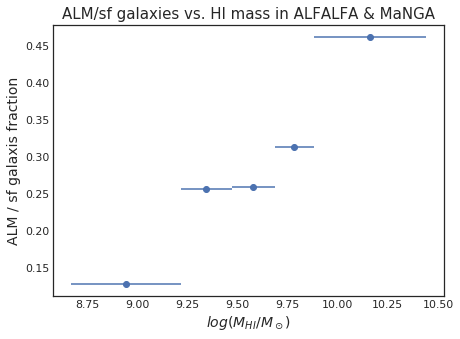

In [887]:
# 分bin，每组数据相同。
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
x_dot = mgHI_mass
y_dot = sf_alm_01
# 将 x 轴数据点分组
# yhist, xbins = np.histogram(x_dot,bins=histedges_equalN(sf_stellar_mass, 10));
xbins = histedges_equalN(x_dot, 5)
# 调整最后画图的 x 轴数据
# x = xbins[1:]-(xbins[1]-xbins[0])/2
x = (xbins[:-1]+xbins[1:])/2
x_start = xbins[0:np.size(xbins)-1]
x_end = xbins[1:]
x_error = np.array([])
y_error = np.array([])
y = np.array([])
for i in range(np.size(xbins)-1):
    y_data = y_dot[(x_dot>=x_start[i])&(x_dot<=x_end[i])]
    x_error = np.append(x_error,(x_end[i]-x_start[i])/2)
    #y_error = np.append(y_error,np.std(y_data))
    #y_error = np.append(y_error,np.sqrt(np.sum(y_data)/np.size(y_data)))
    y_error = np.append(y_error,0)
    #print("np.sum(y_data) = ",np.sum(y_data))
    #print("np.size(y_data) = ",np.size(y_data))
    #y = np.append(y,np.mean(y_data))
    y = np.append(y,np.sum(y_data)/np.size(y_data))

# plot
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)

plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o')
# plt.xlim(8.5,11.2)
# plt.ylim(0,1.0)
# plt.legend(loc = "best")# 设置图例

plt.xlabel("$log(M_{HI} / M_\odot)$",fontsize = 14)
# plt.xlabel("$v_{HI} (km/s)$",fontsize = 14)
plt.ylabel("ALM / sf galaxis fraction",fontsize = 14)
plt.title("ALM/sf galaxies vs. HI mass in ALFALFA & MaNGA",fontsize = 15)
# plt.ylabel("ALM / all galaxis fraction",fontsize = 14)
# plt.title("ALM/all galaxies vs. HI mass in ALFALFA & MaNGA",fontsize = 15)
ax.tick_params(which='both',direction='in')
plt.show()
# print(x_start)
# print(x_end)

### ALM / sf  vs HI data | spaxels
+ 包括 HI mass, flux, velocity

In [ ]:
'''HI gas mass, 结合 MaNGA-HI 和 ALFALFA 两组数据
考虑 non-detection 星系，按照最低的质量估计
HI 气体的质量，单位为太阳质量，已经 log10 了
'''
def _HI_gas_mass(plateifu):
    tmp_id = (plateifu==mg_alfa_fits[1].data['plateifu'])
    if len(mg_alfa_fits[1].data['plateifu'])==0:
        HI_mass = _mgHI_mass(plateifu)
        return HI_mass
    elif len()==0:
        return -999
    else:
        HI_mass = _mgal_mass(plateifu)
        return HI_mass


In [4]:
# 得到单个星系的 ALM/sf 的比值
def _alm_o_sf_spaxels(plateifu):
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    num_sf = len(manga_Z['plate-ifu'].values[tmp_id])
    num_alm = _alm_galaxy(plateifu)
    return num_alm / num_sf
# test
_alm_sf_galaxy(sf_gal_plifu[666])
# HI 气体的质量，单位为太阳质量，已经 log10 了
def _mgHI_mass(plateifu):
    tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
    HI_mass = mgHI_fits[1].data['LOGMHI'][tmp_id][0]
    if HI_mass==-999:
        HI_mass_non = mgHI_fits[1].data['logHIlim200kms'][tmp_id][0]
        return HI_mass_non
    else:
        return HI_mass
# 考虑 non-detection 星系，按照最低的质量估计
# HI 气体的质量，单位为太阳质量，已经 log10 了
def _mgal_mass(plateifu):
    tmp_id = (plateifu==mg_alfa_fits[1].data['plateifu'])
    HI_mass = mg_alfa_fits[1].data['LOGMHI'][tmp_id][0]
    if HI_mass==-999:
        HI_mass_non = mg_alfa_fits[1].data['LOGHILIM200KMS'][tmp_id][0]
        return HI_mass_non
    else:
        return HI_mass

NameError: name '_alm_sf_galaxy' is not defined

In [1103]:
# 得到单个星系的 ALM数量，sf数量，ALM/sf比值
def _alm_o_sf_spaxels(plateifu):
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    num_sf = len(manga_Z['plate-ifu'].values[tmp_id])
    num_alm = _alm_galaxy(plateifu)
    return num_alm, num_sf, num_alm / num_sf

In [1102]:
mg_alfa_fits[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.12b          
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   79 /Number of bytes per row                         
NAXIS2  =                 1021 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   17 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [ ]:
def _possion_err_spaxel(plateifu):
    alm_num,sf_num,almosf = _alm_o_sf_spaxels(plateifu)
    err = math.sqrt(alm_num)/sf_num
    return err

In [1346]:
# 得到单个星系的 ALM数量，sf数量，ALM/sf比值
def _alm_o_sf_spaxels(plateifu):
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    num_sf = len(manga_Z['plate-ifu'].values[tmp_id])
    num_alm = _alm_galaxy(plateifu)
    return num_alm, num_sf, num_alm / num_sf
alm_o_sf = np.array([_alm_o_sf_spaxels(plateifu)[2] for plateifu in mgal_sf_plateifu])
# 去除 'logHIlim200kms' 无效数据
alm_o_sf = alm_o_sf[mgal_mass!=-999]

203

In [1347]:
alm_o_sf

array([0.31680912, 0.20879842, 0.5620155 , 0.27824519, 0.01981707,
       0.19508563, 0.04347826, 0.03142857, 0.13086913, 0.01712329,
       0.02226721, 0.02079304, 0.02020202, 0.01431981, 0.37617555,
       0.06900801, 0.17945691, 0.40471092, 0.03066038, 0.03104925,
       0.01898734, 0.01369863, 0.04      , 0.35500879, 0.01754386,
       0.61417323, 0.08355795, 0.11238671, 0.43842365, 0.16845329,
       0.07665505, 0.01949861, 0.96481481, 0.11990408, 0.04583333,
       0.0063234 , 0.16099773, 0.20365034, 0.10888252, 0.10434783,
       0.00492611, 0.11123471, 0.00661058, 0.015625  , 0.01818182,
       0.01677852, 0.03409091, 0.03076923, 0.56962025, 0.2464455 ,
       0.01654846, 0.13207547, 0.0141844 , 0.01285141, 0.0419092 ,
       0.01388889, 0.11486486, 0.00337838, 0.00838574, 0.06428571,
       0.08988764, 0.04255319, 0.02969562, 0.00840336, 0.29694323,
       0.0212766 , 0.01257862, 0.01041667, 0.00342075, 0.01524033,
       0.10693069, 0.00537634, 0.01574803, 0.01234568, 0.41941

In [1113]:
# # MaNGA-HI data, ALM/sf spaxels vs. HI mass
# mgHI_mass = np.array([_mgHI_mass(plateifu) for plateifu in mgHI_sf_plateifu])#mgal_sf_plateifu
# alm_o_sf = np.array([_alm_o_sf_spaxels(plateifu) for plateifu in mgHI_sf_plateifu])
# sf_stellar_mass = np.array([_stellar_mass(plateifu) for plateifu in mgHI_sf_plateifu])
# print("去除无效数据前，星系个数为： ",mgHI_mass.size)
# # 去除 'logHIlim200kms' 无效数据
# alm_o_sf = alm_o_sf[mgHI_mass!=-999]
# sf_stellar_mass = sf_stellar_mass[mgHI_mass!=-999]
# mgHI_mass = mgHI_mass[mgHI_mass!=-999]
# print("去除无效数据后，星系个数为： ",mgHI_mass.size)

# ALFALFA data, ALM/sf spaxels vs. HI mass
mgal_mass = np.array([_mgal_mass(plateifu) for plateifu in mgal_sf_plateifu])#mgal_sf_plateifu
alm_o_sf = np.array([_alm_o_sf_spaxels(plateifu)[2] for plateifu in mgal_sf_plateifu])
sf_stellar_mass = np.array([_stellar_mass(plateifu) for plateifu in mgal_sf_plateifu])

print("去除无效数据前，星系个数为： ",mgal_mass.size)
# 去除 'logHIlim200kms' 无效数据
alm_o_sf = alm_o_sf[mgal_mass!=-999]
sf_stellar_mass = sf_stellar_mass[mgal_mass!=-999]
mgal_mass = mgal_mass[mgal_mass!=-999]
print("去除无效数据后，星系个数为： ",mgal_mass.size)

去除无效数据前，星系个数为：  388
去除无效数据后，星系个数为：  388


In [1108]:
np.array([_alm_o_sf_spaxels(plateifu)[2] for plateifu in mgal_sf_plateifu[3:8]])

array([0.5620155 , 0.27824519, 0.01981707, 0.19508563, 0.        ])

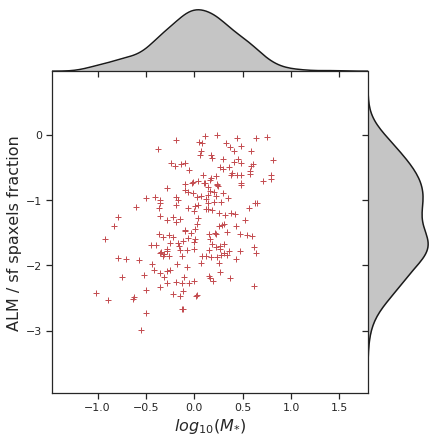

In [1114]:

g = sns.jointplot(x=mgal_mass-sf_stellar_mass, y=np.log10(alm_o_sf),kind="kde", color="k",shade_lowest=False,space=0)
# 创建密度图
g.plot_joint(plt.scatter,c="r", s=30, linewidth=1, marker="+")

g.set_axis_labels('$log_{10}(M_{*}$)', 'ALM / sf spaxels fraction', fontsize=16)
# manga_Z

### 相关系数： 


#### ALFALFA & MaNGA star forming glalaxies

In [1348]:
# 得到单个星系的 ALM数量，sf数量，ALM/sf比值
def _alm_o_sf_spaxels(plateifu):
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    num_sf = len(manga_Z['plate-ifu'].values[tmp_id])
    num_alm = _alm_galaxy(plateifu)
    return num_alm, num_sf, num_alm / num_sf
# 泊松误差
def _possion_err_spaxel(plateifu):
    alm_num,sf_num,almosf = _alm_o_sf_spaxels(plateifu)
    err = math.sqrt(alm_num)/sf_num
    return err

cri_almsf = 0.003
plateifu_tmp = mgal_sf_plateifu  # mgal_sf_plateifu  # mgHI_sf_plateifu

try:
    tmp_id = (plateifu_tmp==mgal_sf_plateifu)
except:
    tmp_id = np.zeros(6)
    pass

if tmp_id.all():
    HI_mass = np.array([_mgal_mass(plateifu) for plateifu in plateifu_tmp])
elif (plateifu_tmp==mgHI_sf_plateifu).all():
    HI_mass = np.array([_mgHI_mass(plateifu) for plateifu in plateifu_tmp])
else:
    raise ValueError("Unknown plateifu data set")
    pass
# plateifu_tmp = mgal_sf_plateifu[5:10]
# HI_mass = np.array([_mgal_mass(plateifu) for plateifu in plateifu_tmp])
sf_stellar_mass = np.array([_stellar_mass(plateifu) for plateifu in plateifu_tmp])
alm_o_sf = np.array([_alm_o_sf_spaxels(plateifu)[2] for plateifu in plateifu_tmp])
alm_number = np.array([_alm_o_sf_spaxels(plateifu)[0] for plateifu in plateifu_tmp])
y_rand
possion_err = np.array([_possion_err_spaxel(plateifu) for plateifu in plateifu_tmp])

print("去除无效数据前，星系个数为： ",HI_mass.size)
# 去除 'logHIlim200kms' 无效数据 & 去除 alm/sf < cri_almsf
tmp_id = copy((HI_mass!=-999)&(alm_o_sf>cri_almsf)&((HI_mass - sf_stellar_mass)>-1))
alm_o_sf = alm_o_sf[tmp_id]
alm_number = alm_number[tmp_id]
sf_number = sf_number[tmp_id]
sf_stellar_mass = sf_stellar_mass[tmp_id]
possion_err = possion_err[tmp_id]
HI_mass = HI_mass[tmp_id]
print("去除无效数据后，星系个数为： ",HI_mass.size)

去除无效数据前，星系个数为：  388
去除无效数据后，星系个数为：  203


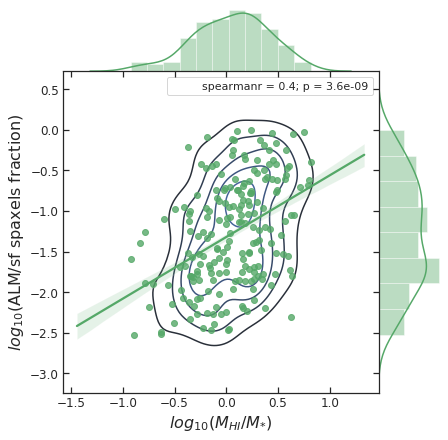

In [1209]:
'''ALM/sf spaxels vs. HI mass/ stellar mass

correlation coefficient: 皮尔逊相关系数=协方差/(X方差*Y方差)，[-1,1]
The p-value roughly indicates the probability of an uncorrelated system 
producing datasets that have a Pearson correlation at least as extreme as 
the one computed from these datasets.

expectation value: pearonr=1, p=0
'''
# Plotting variable
x = HI_mass - sf_stellar_mass
y = np.log10(alm_o_sf)
y_err = possion_err/alm_o_sf/np.log(10)
# x = np.power(10,HI_mass-sf_stellar_mass)
# y = alm_o_sf
# y_err = possion_err

# Plot!!!
# la = (sns.jointplot(x,y,space=0,kind="reg").plot_joint(sns.kdeplot, zorder=0, n_levels=6))
sns.set(style="ticks", color_codes=False)
# la = (sns.JointGrid(x=x, y=y,space=0).plot_joint(sns.kdeplot, zorder=0, n_levels=6))
# la= la.plot(sns.regplot,sns.distplot)

la = sns.jointplot(x,y,space=0,kind="reg", color='g',ci=68)

la = la.plot_joint(sns.kdeplot, zorder=0, n_levels=5)
# la.plot_joint(sns.regplot,color='g', ci=68,label='68%')
# plt.errorbar(x,y,yerr=y_err,fmt='o')#,fmt='o')
# ax = sns.pointplot(x,y,dodge=True, join=False, ci=None)
# print(ax.collections)
# x_coords = []
# y_coords = []
# for point_pair in ax.collections:
#     for tmp_x, tmp_y in point_pair.get_offsets():
#         x_coords.append(tmp_x)
#         y_coords.append(tmp_y)
# ax.errorbar(x_coords, y_coords, yerr=y_err, fmt=' ', zorder=-1)

# label
la.set_axis_labels('$log_{10}(M_{HI}/M_{*})$', '$log_{10}$(ALM/sf spaxels fraction)', fontsize=16)#,fontweight='bold')  
# plt.tight_layout()
# la.plot(sns.regplot, sns.distplot)
# la.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
# la.plot_joint(plt.plot,(0, 500), (0, 500), c=".2", ls="--")
# la.plot_marginals(sns.distplot, kde=False, color="g")
# la.annotate(stats.pearsonr)
la.annotate(stats.spearmanr)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.tick_params(axis="x",direction="in",pad=3)
# plt.tick_params(axis="y",direction="in",pad=3)
plt.tick_params(which='both',direction='in')

# plt.legend()
# plt.xscale('log')
# plt.yscale('log')

tmp_xlim = plt.xlim()
tmp_ylim = plt.ylim()

plt.show()

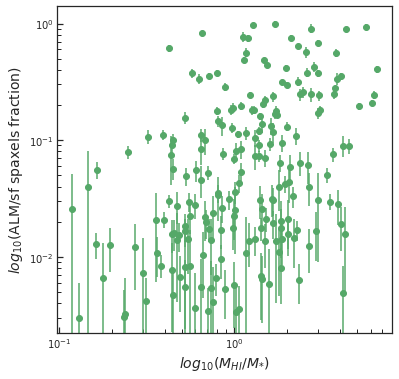

In [1252]:
plt.figure(figsize=(6,6))
x = np.power(10,HI_mass-sf_stellar_mass)
y = alm_o_sf
y_err = possion_err
plt.errorbar(x,y,yerr=y_err,fmt='o',color='g')#,fmt='o')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(np.power(10,tmp_xlim))
# plt.ylim(np.power(10,tmp_ylim))

plt.tick_params(which='both',direction='in')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$log_{10}(M_{HI}/M_{*})$",fontsize=14)
plt.ylabel("$log_{10}$(ALM/sf spaxels fraction)",fontsize=14)
plt.show()

### weighted correlation coefficient

```
Data needed:
X
Y
X_error
Y_error

Equeation:
sum(weighted coefficient)=sum(1/error coefficient)=1
```

In [1223]:
# Data used
# data is in normal meaurement
x = np.power(10,HI_mass-sf_stellar_mass)
y = alm_o_sf
y_err = possion_err
# # data is in log10 measure
# x = HI_mass - sf_stellar_mass
# y = np.log10(alm_o_sf)
# y_err = possion_err/alm_o_sf/np.log(10)

# calculate weighted correlation coefficient
coeff = 1./y_err
coeff /= np.sum(coeff)
fenzi = np.sum( coeff * (x-np.sum(coeff*x)) * (y-np.sum(coeff*y)) )
fenmu = (np.power(np.sum( coeff * (x-np.sum(coeff*x)) * (x-np.sum(coeff*x)) ),0.5) \
         * np.power(np.sum( coeff * (y-np.sum(coeff*y)) * (y-np.sum(coeff*y)) ),0.5))
weighted = fenzi/fenmu
print(weighted)

0.2997070827021043


In [1217]:
np.power(np.sum( coeff * (y-np.sum(coeff*y)) * (y-np.sum(coeff*y)) ),0.5)

1.0475154062996963

#### 按照 stellar mass 分组，做出 ALM/sf vs. HI mass


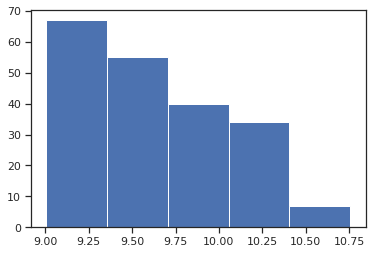

In [1232]:
# stellar mass 分布
x = sf_stellar_mass
plt.hist(x,bins=5)
plt.show()

203
203
203


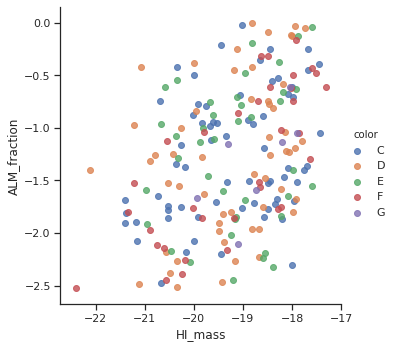

In [1260]:
x = HI_mass-3*sf_stellar_mass
y = np.log10(alm_o_sf)
z_sort = sf_stellar_mass
tmp_colors = ['C','D','E','F','G']
yhist, xbins = np.histogram(z_sort,bins=5)
x_start = xbins[:-1]
x_end = xbins[1:]
colors = np.array([])
for i,j,k in zip(x_start,x_end,tmp_colors):
    tmp_id = ((z_sort>=i)&(z_sort<=j))
    colors = np.append(colors,np.repeat(k, np.size(z_sort[tmp_id])))
    pass
print(colors.size)
print(x.size)
print(y.size)
# plot
df = pd.DataFrame(dict(HI_mass=x, ALM_fraction=y, color=colors))

sns.lmplot('HI_mass', 'ALM_fraction', data=df, hue='color', fit_reg=False)

plt.show()

In [1270]:
x[np.argsort(x)]


array([-0.92413212, -0.60394368, -0.56783093, -0.4447439 , -0.35084993,
       -0.31258785, -0.22253334, -0.19878629, -0.19167057, -0.18886425,
       -0.16647479, -0.15044189, -0.09267383, -0.07463625, -0.068623  ,
       -0.05537963, -0.05408347, -0.01541432, -0.00370503, -0.00298902,
        0.00236515,  0.0379081 ,  0.08768081,  0.11029884,  0.1188332 ,
        0.11996693,  0.15892097,  0.17445668,  0.17658915,  0.22102048,
        0.22281227,  0.23803827,  0.24179948,  0.32398289,  0.34164321,
        0.36627657,  0.42773799,  0.43828138,  0.45504929,  0.59484069])

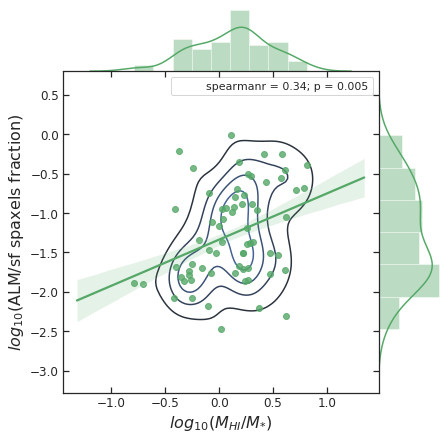

In [1292]:
# 单独画出 每个分组的 散点图
# x = HI_mass-3*sf_stellar_mass
# y = np.log10(alm_o_sf)
z_sort = sf_stellar_mass
tmp_colors = ['C','D','E','F','G']
yhist, xbins = np.histogram(z_sort,bins=5)
x_start = xbins[:-1]
x_end = xbins[1:]
colors = np.array([])
for i,j,k in zip(x_start,x_end,tmp_colors):
    tmp_id = ((z_sort>=i)&(z_sort<=j))
    colors = np.append(colors,np.repeat(k, np.size(z_sort[tmp_id])))
    pass

# Plotting variable
tmp_id = (colors==tmp_colors[0])
x = (HI_mass - sf_stellar_mass)[tmp_id]
y = np.log10(alm_o_sf)[tmp_id]

# # 丢弃某些值
# tmp_id = np.argsort(x)
# y = y[tmp_id]
# x = x[tmp_id]
# y = y[2:-1]
# x = x[2:-1]

# # 丢弃某些值
# tmp_id = np.argsort(y)
# y = y[tmp_id]
# x = x[tmp_id]
# y = y[1:]
# x = x[1:]

# Plot!!!
sns.set(style="ticks", color_codes=False)

la = sns.jointplot(x,y,space=0,kind="reg", color='g',ci=68)
la = la.plot_joint(sns.kdeplot, zorder=0, n_levels=5)

# label
la.set_axis_labels('$log_{10}(M_{HI}/M_{*})$', '$log_{10}$(ALM/sf spaxels fraction)', fontsize=16)#,fontweight='bold')  

la.annotate(stats.spearmanr)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(which='both',direction='in')
tmp_xlim = plt.xlim()
tmp_ylim = plt.ylim()

plt.show()

In [1263]:
HI_mass.shape

(203,)

In [ ]:
# 第一种：普通分bin
x = HI_mass
y = np.log10(alm_o_sf)
z_sort = sf_stellar_mass
# generate colors array according to stellar mass
bins_num = 5

color =['D', 'D', 'D', 'E', 'E', 'E', 'F', 'F', 'F', 'G', 'G', 'G',]

df = pd.DataFrame(dict(HI_mass=x, ALM_fraction=y, color=color))

sns.lmplot('HI_mass', 'ALM_fraction', data=df, hue='color', fit_reg=False)

plt.show()

In [ ]:
i = 0# 循环计数变量
plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    pass

plt.figure(figsize=(6,6))
x = np.power(10,HI_mass-sf_stellar_mass)
y = alm_o_sf
y_err = possion_err
plt.errorbar(x,y,yerr=y_err,fmt='o',color='g')#,fmt='o')
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.power(10,tmp_xlim))
plt.ylim(np.power(10,tmp_ylim))

plt.tick_params(which='both',direction='in')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$log_{10}(M_{HI}/M_{*})$",fontsize=14)
plt.ylabel("$log_{10}$(ALM/sf spaxels fraction)",fontsize=14)
plt.show()

In [1230]:
# x = (xbins[:-1]+xbins[1:])/2
x = np.arange(5)
x[:-2]

array([0, 1, 2])

### Correlation Coefficient Error 【蒙特卡罗】
`Assuming every data point is normal distribution, its \sigma=error, mean=itself`   
Then, we can get several coefficient as much as the data number.   
Last, we calculate the error of coefficient.   

New correlation coefficient is  (0.2809511190677963, 4.900909790166305e-05)
the error of correlation coefficient is  [10.04017908  0.38892736  0.01773479]


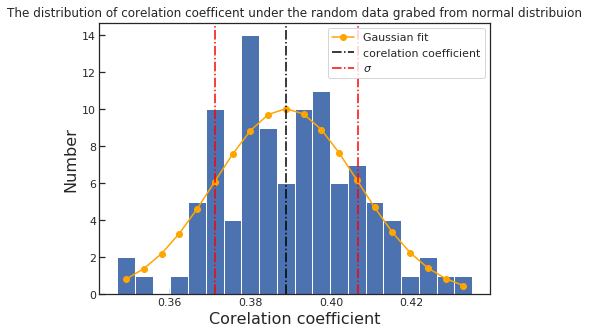

In [1376]:
# generate random number which is normal distribution
# according to the data and error we have
from scipy import asarray as ar,exp
from scipy.optimize import curve_fit
# 一般高斯函数
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

x = np.power(10,HI_mass-sf_stellar_mass)
y = alm_number  # alm_o_sf
coeff = stats.pearsonr(x, y)
# coeff = stats.spearmanr(x_rand, y_rand)

print("New correlation coefficient is ", coeff)
y_err = possion_err

num_random = 100

# generate random data
y_rand = np.ones([num_random, x.size])*np.nan
for i in range(x.size):
    tmp_yrand = np.random.poisson(y[i], num_random)
    #tmp_yrand = np.random.poisson(y[i], y_err[3], num_random)
    y_rand[:,i] = tmp_yrand/sf_number[i]
    pass
x_rand = x

y_rand = np.log10(y_rand)
x_rand = np.log10(x_rand)

# calculate correlation coefficient per group
coeff_rand = np.ones(num_random)*np.nan
for i in range(num_random):
    coeff_rand[i] = stats.spearmanr(x_rand, y_rand[i,:])[0]
    #coeff_rand[i] = stats.pearsonr(x_rand, y_rand[i,:])
    pass

# view the distribution of coefficient
plt.figure(figsize=(7,5))
ycount, xbins, ignored = plt.hist(coeff_rand, 20)#, normed=True)


# calculate the error of coefficient
x = (xbins[:-1]+xbins[1:])/2
y = ycount
n = len(x)# 拟合数据长度
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差
ymax = np.max(y)# y轴最大值，即拟合函数的幅度[高度]大小

popt0,pcov0 = curve_fit(gaus,x,y,p0=[ymax,mean,sigma])
newx0 = np.linspace(x.min(),x.max(),20)
print("the error of correlation coefficient is ", popt0)

plt.plot(newx0,gaus(newx0,*popt0),'o-',color='orange',label='Gaussian fit')

# ALM 标准
rand_coeff = popt0[1]
rand_sigma = popt0[2]
plt.axvline(rand_coeff,color='black',linestyle='-.',label='corelation coefficient')
plt.axvline(rand_coeff+rand_sigma,color='red',linestyle='-.',label='$\sigma$')
plt.axvline(rand_coeff-rand_sigma,color='red',linestyle='-.')
# plt.annotate(r'$\sigma$ = %.3f' % rand_sigma, xy=(rand_coeff+rand_sigma+0.03, 10), xycoords='data', xytext=(0,0),
#              textcoords='offset points', fontsize=11,
#              arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.title("The distribution of corelation coefficent under the random data grabed from normal distribuion")
plt.xlabel('Corelation coefficient',fontsize=16)
plt.ylabel('Number',fontsize=16)
# plt.plot(newxx,newyy,'k--',label='Plus Gaussian fit')# 画图
plt.show()

In [1380]:
np_std = np.std(x, ddof=1)

n = len(x)# 拟合数据长度
mean = sum(x)/n# 平均数
my_std = (sum((x-mean)**2)/n)**0.5# 标准差

print("My std is %.3f \nBut numpy's std is %.3f" % (my_std,np_std))

My std is 0.025 
But numpy's std is 0.026


New correlation coefficient is  (0.2809511190677963, 4.900909790166305e-05)
the error of correlation coefficient is  [6.49357859e+02 3.91380800e-01 1.60441908e-02]


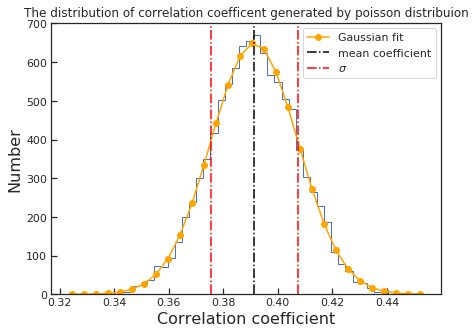

In [1401]:
# generate random number which is normal distribution
# according to the data and error we have
from scipy import asarray as ar,exp
from scipy.optimize import curve_fit
# 一般高斯函数
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

x = np.power(10,HI_mass-sf_stellar_mass)
y = alm_number  # alm_o_sf
coeff = stats.pearsonr(x, y)
# coeff = stats.spearmanr(x_rand, y_rand)

print("New correlation coefficient is ", coeff)
y_err = possion_err

num_random = 10000

# initialize array
y_rand = np.ones([num_random, x.size])*np.nan
for i in range(x.size):
    # generate random number with poisson distribution
    tmp_yrand = np.random.poisson(y[i], num_random)
    
    # generate random number with normal distribution
    #tmp_yrand = np.random.normal(y[i],y_err[i],num_random)
    y_rand[:,i] = tmp_yrand/sf_number[i]
    pass
x_rand = x

y_rand = np.log10(y_rand)
x_rand = np.log10(x_rand)

# calculate correlation coefficient per group
coeff_rand = np.ones(num_random)*np.nan
for i in range(num_random):
    coeff_rand[i] = stats.spearmanr(x_rand, y_rand[i,:])[0]
    #coeff_rand[i] = stats.pearsonr(x_rand, y_rand[i,:])
    pass

# view the distribution of coefficient
plt.figure(figsize=(7,5))
ycount, xbins, ignored = plt.hist(coeff_rand, 50,histtype='step')#, normed=True)


# calculate the error of coefficient
x = (xbins[:-1]+xbins[1:])/2
y = ycount
n = len(x)# 拟合数据长度
mean = sum(x)/n# 平均数
sigma = np.std(x, ddof=1)  # 标准差
ymax = np.max(y)# y轴最大值，即拟合函数的幅度[高度]大小

popt0,pcov0 = curve_fit(gaus,x,y,p0=[ymax,mean,sigma])
newx0 = np.linspace(x.min(),x.max(),30)
print("the error of correlation coefficient is ", popt0)

plt.plot(newx0,gaus(newx0,*popt0),'o-',color='orange',label='Gaussian fit')

# ALM 标准
rand_coeff = popt0[1]
rand_sigma = popt0[2]
plt.axvline(rand_coeff,color='black',linestyle='-.',label='mean coefficient')
plt.axvline(rand_coeff+rand_sigma,color='red',linestyle='-.',label='$\sigma$')
plt.axvline(rand_coeff-rand_sigma,color='red',linestyle='-.')
# plt.annotate(r'$\sigma$ = %.3f' % rand_sigma, xy=(rand_coeff+rand_sigma, 500), xycoords='data', xytext=(-2,10),
#              textcoords='offset points', fontsize=11,
#              arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.title("The distribution of correlation coefficent generated by poisson distribuion")
plt.xlabel('Correlation coefficient',fontsize=16)
plt.ylabel('Number',fontsize=16)
# plt.plot(newxx,newyy,'k--',label='Plus Gaussian fit')# 画图
plt.show()

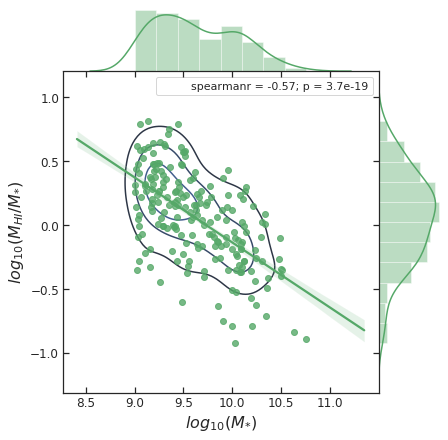

In [1408]:
# scatter relation of HI mass and stellar mass
x = sf_stellar_mass
y = HI_mass

# plt.figure(figsize=(7,5))
# plt.scatter(x,y)
# plt.title("Relation between $M_{HI}$ and $M_{*}$")
# plt.show()
# Plot!!!
# sns.set(style="ticks", color_codes=False)

la = sns.jointplot(x,y-x,space=0,kind="reg", color='g',ci=68)
la = la.plot_joint(sns.kdeplot, zorder=0, n_levels=3)

# label
la.set_axis_labels('$log_{10}(M_{*})$', '$log_{10}(M_{HI}/M_{*})$', fontsize=16)#,fontweight='bold')  

la.annotate(stats.spearmanr)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(which='both',direction='in')
tmp_xlim = plt.xlim()
tmp_ylim = plt.ylim()

plt.show()

In [ ]:
from scipy import asarray as ar,exp
from scipy.optimize import curve_fit
# 一般高斯函数
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
# 加强版高斯函数【plus=0就是一般高斯函数】
def gua_plus(x,a,x0,sigma,plus):
    #norm = a/sigma*exp(-(x-x0)**2/(2*sigma**2))
    #cdf = stats.norm.cdf(plus*x, loc=x0, scale=sigma)
    #cdf = stats.norm.cdf(plus*(x-x0)/sigma, loc=0, scale=1)
    #return 2*norm*cdf
    result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return result
n = len(x)# 拟合数据长度
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差
ymax = np.max(y)# y轴最大值，即拟合函数的幅度[高度]大小
# 开始拟合！！！
popt,pcov = curve_fit(gua_plus,x,y,p0=[ymax,mean,sigma,-3])
popt0,pcov0 = curve_fit(gaus,x,y,p0=[ymax,mean,sigma])

# 拟合曲线画图
newx = np.linspace(xmin,xmax,200)
newx0 = np.linspace(xmin,xmax,20)
# plt.show()
plt.plot(newx,gua_plus(newx,*popt), 'r--', linewidth=2,label='skew Gaussian fit')
# plt.show()
plt.plot(newx0,gaus(newx0,*popt0),'o-',color='orange',label='Gaussian fit')

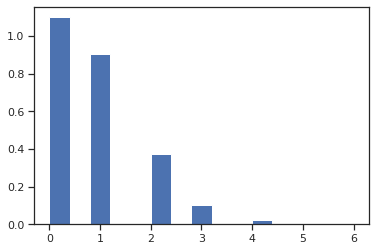

In [1344]:
s = np.random.poisson(0.8, 10000)
count, bins, ignored = plt.hist(s, 15, normed=True)
plt.show()

In [1311]:
y_rand

array([-0.57018953, -0.55822076, -0.54359394, -0.57105193, -0.5448311 ,
       -0.52318681, -0.58050417, -0.53949786, -0.54445838, -0.56455783,
       -0.5488844 , -0.56809754, -0.57049686, -0.54601131, -0.55833173,
       -0.57020341, -0.53548574, -0.56566315, -0.5594784 , -0.53752506,
       -0.53679737, -0.54568618, -0.58290668, -0.53491085, -0.54179558,
       -0.56112023, -0.55320123, -0.5551962 , -0.55524217, -0.58747011,
       -0.5545301 , -0.5637392 , -0.56834616, -0.5317126 , -0.55364777,
       -0.57773576, -0.56295839, -0.56627072, -0.54468828, -0.54183502,
       -0.55171501, -0.56131118, -0.58689294, -0.53816579, -0.53309046,
       -0.55286484, -0.52486052, -0.55464727, -0.53230781, -0.5525454 ,
       -0.58495678, -0.54405552, -0.58862802, -0.56678685, -0.53771868,
       -0.54019382, -0.54023506, -0.55678879, -0.48380543, -0.58307953,
       -0.55003257, -0.56838182, -0.57442135, -0.57662563, -0.55680127,
       -0.54313777, -0.54992565, -0.56015045, -0.59802532, -0.56

#### MaNGA-HI & MaNGA star forming glalaxies

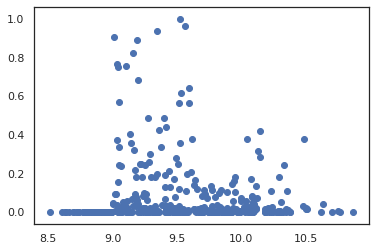

In [1054]:
x=sf_stellar_mass
# y=np.log10(alm_o_sf)
y=alm_o_sf
plt.scatter(x,y)

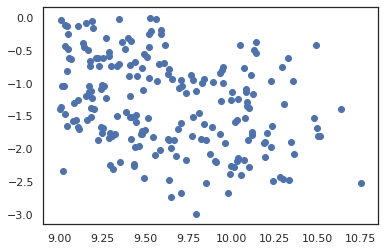

In [662]:
# 获取三类数据的 star forming 星系的编号：plate-ifu

# MaNGA 中筛选出的星系的 plate-ifu
sf_gal_plifu, sel_id = np.unique(manga_Z['plate-ifu'].values,return_index=True)

# MaNGA-HI 中的 sf 星系
mgHI_plateifu = mgHI_fits[1].data['plateifu']
mgHI_HI_mass = mgHI_fits[1].data['logMHI']
chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgHI_plateifu])
# chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgHI_plifu])
mgHI_sf_plateifu = mgHI_plateifu[chek==1]
# mgHI_sf_plateifu = mgHI_plifu[chek==1]

# ALFALFA和MaNGA 匹配星系中的 sf 星系
mgal_plateifu = mg_alfa_fits[1].data['plateifu']
chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgal_plateifu])
# chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgal_plifu])
mgal_sf_plateifu = mgal_plateifu[chek==1]
# mgal_sf_plateifu = mgal_plifu[chek==1]

# # 得到单个星系的 ALM/sf 的比值
# def _alm_sf_galaxy(plateifu):
#     tmp_id = (manga_Z['plate-ifu'].values==plateifu)
#     num_sf = len(manga_Z['plate-ifu'].values[tmp_id])
#     num_alm = _alm_galaxy(plateifu)
#     return num_alm / num_sf
# # test
# _alm_sf_galaxy(sf_gal_plifu[666])

0.05236907730673317

In [ ]:
# 每个星系的 HI mass
sel_HI_mass = np.array([dapall_data['SFR_TOT'][plifu==dapall_data['PLATEIFU']][0] for plifu in alm_plifu])


# 每个 ALM 星系的 alm/sf 比例
alm_sf = np.array([_alm_sf_galaxy(plateifu) for plateifu in alm_plifu])

In [ ]:
g = sns.jointplot(x=sel_sfr, y=alm_sf,kind="kde", color="k",shade_lowest=False,space=0)
# 创建密度图
g.plot_joint(plt.scatter,c="r", s=30, linewidth=1, marker="+")

g.set_axis_labels('SFR', 'ALM / sf spaxels', fontsize=16)

In [ ]:
la = sns.jointplot(radec_manga[:,1],radec_alfalfa[:,1],space=0)
la.set_axis_labels('dec_MaNGA', 'dec_ALFALFA', fontsize=16)#,fontweight='bold')
# plt.legend()
# plt.tight_layout()
# la.plot(sns.regplot, sns.distplot)
la.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
# la.plot_joint(plt.plot,(0, 500), (0, 500), c=".2", ls="--")
la.plot_marginals(sns.distplot, kde=False, color="g")
la.annotate(stats.pearsonr)

In [6]:
# 取出MaNGA中的 star-forming 星系
sf_gal_plifu, sel_id = np.unique(manga_Z['plate-ifu'].values,return_index=True)
# sf_gal_plifu = manga_Z['plate-ifu'].values[sel_id]
print("4675个MaNGA星系中，有 %d 个star-forming & late-type 星系" % sf_gal_plifu.shape[0])



def _match(x, MaNGA): 
    a = np.where(MaNGA==x)
    if np.size(a)==0:
        return 0
    else:
        return 1
_mtch = partial(_match, MaNGA=sf_gal_plifu)    # 转换为单参数函数

# ALM_galaxy & HI-MaNGA
matched_01 = np.array(list(map(_mtch, HI_plifu)),dtype=int)
matched_plifu_sfHI = HI_plifu[matched_01==1].astype(str)
print("sf MaNGA & HI-MaNGA 匹配总星系数量为： ", matched_plifu_sfHI.shape)

4675个MaNGA星系中，有 1547 个star-forming & late-type 星系


NameError: name 'HI_plifu' is not defined

In [316]:
def _radec_manga(plateifu):
    tmp_id = (drp_fits[1].data['plateifu']==plateifu)
    ra = drp_fits[1].data['objra'][tmp_id][0]    
    dec = drp_fits[1].data['objdec'][tmp_id][0]  
    return ra,dec
def _radec_alfalfa(plateifu):
    tmp_id = (mgHI[1].data['plateifu']==plateifu)
    if len(mgHI[1].data['objra'][tmp_id])==0:
        print(plateifu)
        return False
    else:
        ra = mgHI[1].data['objra'][tmp_id][0]
        dec = mgHI[1].data['objdec'][tmp_id][0]
        return ra,dec
# _ra_manga('8551-3701')
# _ra_alfalfa('8551-3701')


radec_manga = np.array(list(map(_radec_manga, matched_plifu_sfHI)))
radec_alfalfa = np.array(list(map(_radec_alfalfa, matched_plifu_sfHI)))


In [321]:
firefly_fits[1].data["OBJRA"]
firefly_fits[1].data["OBJDEC"]

array([144.23926 , 241.34177 , 194.85555 , ...,  50.636642,  49.949562,
       233.68521 ], dtype=float32)

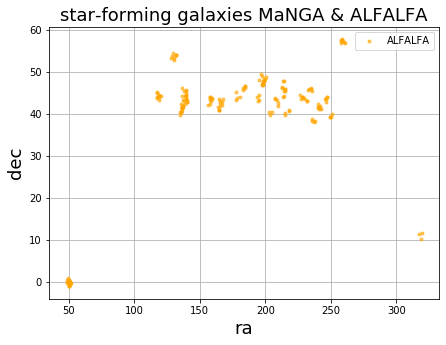

In [293]:
plt.figure(figsize=(7,5))
# plt.plot(radec_manga[:,0],radec_manga[:,1],'.',color = 'grey',label='MaNGA')
plt.plot(radec_alfalfa[:,0],radec_alfalfa[:,1],'.',color = 'orange',label='ALFALFA',alpha = 0.6)
plt.grid()

plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("star-forming galaxies MaNGA & ALFALFA",fontsize = 18)
plt.show()

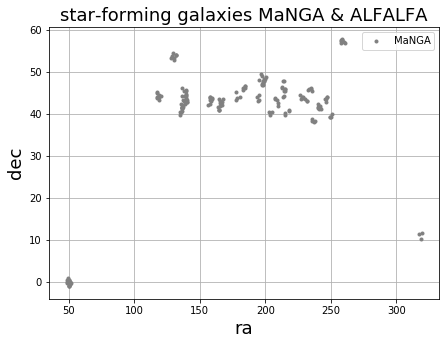

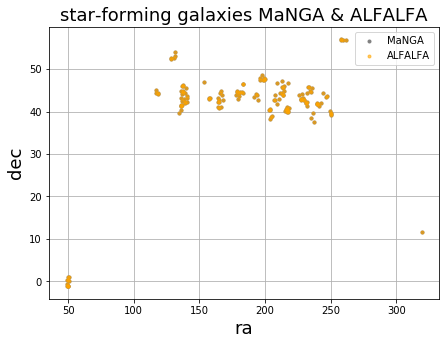

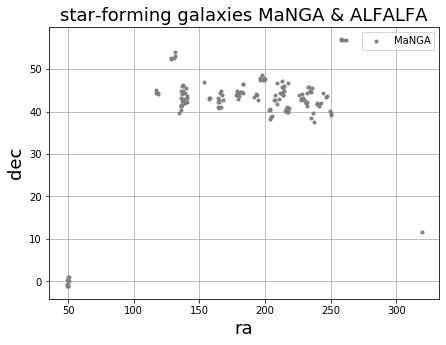

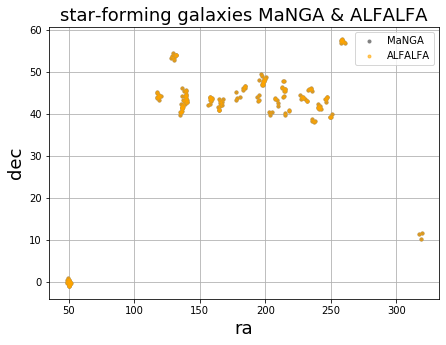

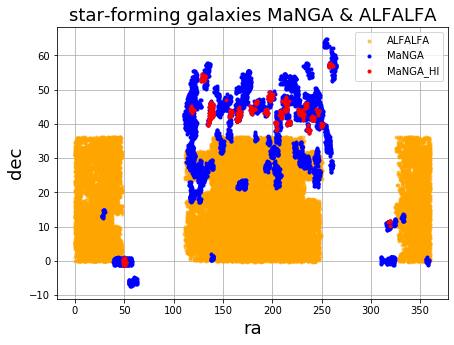

In [325]:
plt.figure(figsize=(7,5))

# plt.plot(alfalfa_data['RAdeg_OC'],alfalfa_data['DECdeg_OC'],'.',color = 'orange',label='ALFALFA',alpha = 0.6)
plt.plot(alfalfa_data['RAdeg_HI'],alfalfa_data['DECdeg_HI'],'.',color = 'orange',label='ALFALFA',alpha = 0.6)
plt.plot(firefly_fits[1].data["OBJRA"],firefly_fits[1].data["OBJDEC"],'.',color = 'blue',label='MaNGA')
# plt.plot(radec_manga[:,0],radec_manga[:,1],'.',color = 'grey',label='MaNGA')
plt.plot(mgHI[1].data['objra'],mgHI[1].data['objdec'],'.',color = 'red',label='MaNGA_HI')
plt.grid()

plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("star-forming galaxies MaNGA & ALFALFA",fontsize = 18)
plt.show()

In [193]:
manga_Z

plate-ifu  array_id  bin_id_2800  spaxel_x  spaxel_y  \
0         8252-12701       0.0         17.0      32.0      29.0   
1         8252-12701       0.0         17.0      33.0      29.0   
2         8252-12701       0.0         17.0      31.0      30.0   
3         8252-12701       0.0         17.0      32.0      30.0   
4         8252-12701       0.0         17.0      33.0      30.0   
5         8252-12701       0.0         17.0      34.0      30.0   
6         8252-12701       0.0         21.0      35.0      30.0   
7         8252-12701       0.0         17.0      31.0      31.0   
8         8252-12701       0.0         17.0      32.0      31.0   
9         8252-12701       0.0         17.0      33.0      31.0   
10        8252-12701       0.0         17.0      34.0      31.0   
11        8252-12701       0.0         17.0      35.0      31.0   
12        8252-12701       0.0         17.0      32.0      32.0   
13        8252-12701       0.0         17.0      33.0      32.0   
14        8252-12701       0.0         17.0      34.0      32.0   
15        8252-12701       0.0         14.0      36.0      32.0   
16        8252-12701       0.0         14.0      37.0      32.0   
17        8252-12701       0.0         17.0      31.0      33.0   
18        8252-12701       0.0         17.0      32.0      33.0   
19        8252-12701       0.0         17.0      33.0      33.0   
20        8252-12701       0.0         17.0      34.0      33.0   
21        8252-12701       0.0         17.0      35.0      33.0   
22        8252-12701       0.0         17.0      36.0      33.0   
23        8252-12701       0.0         11.0      37.0      33.0   
24        8252-12701       0.0         18.0      48.0      33.0   
25        8252-12701       0.0         17.0      32.0      34.0   
26        8252-12701       0.0         17.0      33.0      34.0   
27        8252-12701       0.0         17.0      34.0      34.0   
28        8252-12701       0.0          9.0      35.0      34.0   
29        8252-12701       0.0          9.0      36.0      34.0   
...              ...       ...          ...       ...       ...   
13087372  8485-12704    4674.0         86.0      31.0      48.0   
13087373  8485-12704    4674.0         86.0      32.0      48.0   
13087374  8485-12704    4674.0         86.0      33.0      48.0   
13087375  8485-12704    4674.0         84.0      34.0      48.0   
13087376  8485-12704    4674.0         84.0      35.0      48.0   
13087377  8485-12704    4674.0         84.0      36.0      48.0   
13087378  8485-12704    4674.0         84.0      37.0      48.0   
13087379  8485-12704    4674.0         84.0      38.0      48.0   
13087380  8485-12704    4674.0         96.0      25.0      49.0   
13087381  8485-12704    4674.0         96.0      26.0      49.0   
13087382  8485-12704    4674.0         96.0      27.0      49.0   
13087383  8485-12704    4674.0         96.0      28.0      49.0   
13087384  8485-12704    4674.0         90.0      29.0      49.0   
13087385  8485-12704    4674.0         90.0      30.0      49.0   
13087386  8485-12704    4674.0         90.0      31.0      49.0   
13087387  8485-12704    4674.0         90.0      32.0      49.0   
13087388  8485-12704    4674.0         90.0      33.0      49.0   
13087389  8485-12704    4674.0         97.0      25.0      50.0   
13087390  8485-12704    4674.0         97.0      26.0      50.0   
13087391  8485-12704    4674.0         97.0      27.0      50.0   
13087392  8485-12704    4674.0         90.0      28.0      50.0   
13087393  8485-12704    4674.0         90.0      29.0      50.0   
13087394  8485-12704    4674.0         90.0      30.0      50.0   
13087395  8485-12704    4674.0         97.0      26.0      51.0   
13087396  8485-12704    4674.0         97.0      27.0      51.0   
13087397  8485-12704    4674.0         90.0      28.0      51.0   
13087398  8485-12704    4674.0         90.0      29.0      51.0   
13087399  8485-12704    4674.0         97.0      27.0     

In [326]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

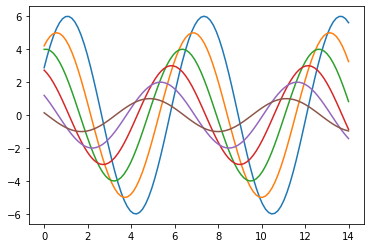

In [327]:
def sinplot(flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, 7):
        plt.plot(x, np.sin(x + i * .5) * (7 - i) * flip)
sinplot()

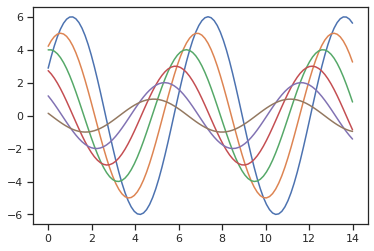

In [330]:
# 对两种画图进行比较
fig = plt.figure()
# sns.set()
sns.set_style('ticks')
sinplot()

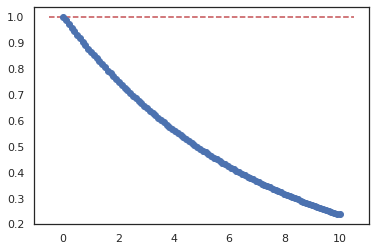

In [980]:

nmax = 10
num = 100
n_arr = np.linspace(0,nmax,num)
y = np.array(list(map(lambda n:math.pow(math.sqrt(3)/2,n),n_arr)))
plt.plot(n_arr,y,'o-')
xmin,xmax = plt.xlim()
plt.hlines(1,xmin,xmax,colors = "r", linestyles = "dashed")
plt.show()


In [971]:
math

16.0

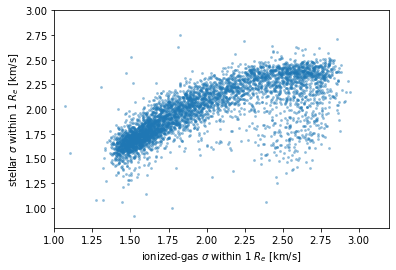

In [108]:
import matplotlib.pyplot as pyplot
pyplot.scatter(np.ma.log10(tbdata['ha_gsigma_1re']),
               np.ma.log10(tbdata['stellar_sigma_1re']),
               alpha=0.5, marker='.', s=30, lw=0)
pyplot.xlim(1,3.2)
pyplot.ylim(0.8,3)
pyplot.xlabel(r'ionized-gas $\sigma$ within 1 $R_e$ [km/s]')
pyplot.ylabel(r'stellar $\sigma$ within 1 $R_e$ [km/s]')
pyplot.show()

In [1333]:
# 定义函数
def KahanSum(input_array):
	sum = 0
	c = 0
	for i in range(len(input_array)):
		y = input_array[i] - c 
		t = sum + y 
		c = (t - sum) - y 
		sum = t
	return sum

# 运行示例
input_array = input("请输入：");
print("你输入的内容是: ", input_array)
output = KahanSum(input_array)  # 利用函数计算
print(output)  # 打印结果


29


In [1334]:
input_array = input("请输入：");
print ("你输入的内容是: ", input_array)

TypeError: 'numpy.ndarray' object is not callable

In [1332]:
input_array[2]

2

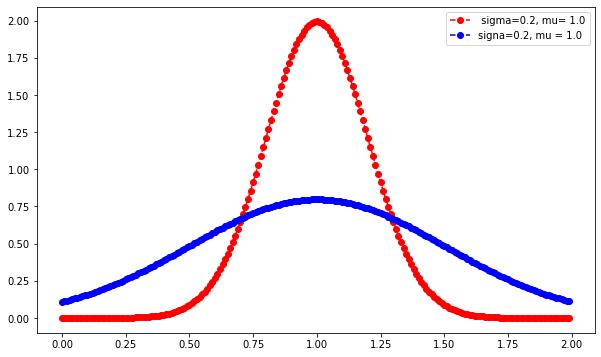

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sigma1 = 0.2
sigma2 = 0.5
mu1=1.0
a = np.arange(0,2,0.01)
b1 = 1.0/(np.sqrt(2.0 * np.pi)*sigma1) * np.exp(-0.5 * np.power((a - mu1) /sigma1, 2))
b2 = 1.0/(np.sqrt(2.0 * np.pi)*sigma2) * np.exp(-0.5 * np.power((a - mu1) /sigma2, 2))
plt.plot(a, b1, 'r--o',label=" sigma=0.2, mu= 1.0")
plt.plot(a,b2,'b--o', label="signa=0.2, mu = 1.0")
plt.legend()
plt.show()

In [1443]:
b1 = 1.0/(np.sqrt(2.0 * np.pi)*sigma1) * np.exp(-0.5 * np.power((a - mu1) /sigma1, 2))
plt.plot(a, b1)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fffc90bff28> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/TeX Live for SUSE Linux)
 restricted \write18 enabled.
entering extended mode
(/home/yhwang/.cache/matplotlib/tex.cache/6f32e64deb25eb64a74d89351c10ed88.tex
LaTeX2e <2011/06/27>
Babel <3.9f> and hyphenation patterns for 78 languages loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.4 ^^M
       
No pages of output.
Transcript written on 6f32e64deb25eb64a74d89351c10ed88.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/TeX Live for SUSE Linux)
 restricted \write18 enabled.
entering extended mode
(/home/yhwang/.cache/matplotlib/tex.cache/6f32e64deb25eb64a74d89351c10ed88.tex
LaTeX2e <2011/06/27>
Babel <3.9f> and hyphenation patterns for 78 languages loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.4 ^^M
       
No pages of output.
Transcript written on 6f32e64deb25eb64a74d89351c10ed88.log.




<Figure size 432x288 with 1 Axes>

In [1437]:
b1 = 1.0/(np.sqrt(2.0 * np.pi)*sigma1) * np.exp(-0.5 * np.power((a - mu1) /sigma1, 2))
b2 = 1.0/(np.sqrt(2.0 * np.pi)*sigma2) * np.exp(-0.5 * np.power((a - mu1) /sigma2, 2))
plt.plot(a, b1, 'r--o',labe1=" sigma=0.2, mu= 1.0")
plt.plot(a,b2,'b--o', labe1="signa=0.2, mu = 1.0")
plt.legend()
plt.show()

AttributeError: 'Line2D' object has no property 'labe1'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fffc90bff28> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/TeX Live for SUSE Linux)
 restricted \write18 enabled.
entering extended mode
(/home/yhwang/.cache/matplotlib/tex.cache/6f32e64deb25eb64a74d89351c10ed88.tex
LaTeX2e <2011/06/27>
Babel <3.9f> and hyphenation patterns for 78 languages loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.4 ^^M
       
No pages of output.
Transcript written on 6f32e64deb25eb64a74d89351c10ed88.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/TeX Live for SUSE Linux)
 restricted \write18 enabled.
entering extended mode
(/home/yhwang/.cache/matplotlib/tex.cache/6f32e64deb25eb64a74d89351c10ed88.tex
LaTeX2e <2011/06/27>
Babel <3.9f> and hyphenation patterns for 78 languages loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.4 ^^M
       
No pages of output.
Transcript written on 6f32e64deb25eb64a74d89351c10ed88.log.




<Figure size 720x432 with 1 Axes>

In [1429]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.15',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'a